<a href="https://colab.research.google.com/github/AlejandroDopico2/AlejandroDopico2/blob/main/hp-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [297]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import os 
import copy
from datetime import datetime, timedelta

# Nueva sección

In [298]:
train_df = pd.read_csv('train.csv')

In [299]:
train_df.dtypes

id                  object
date                object
year_week            int64
product_number       int64
reporterhq_id        int64
prod_category       object
specs                int64
display_size       float64
segment             object
sales_units        float64
inventory_units    float64
dtype: object

In [300]:
train_df.isna().sum()

id                   0
date                 0
year_week            0
product_number       0
reporterhq_id        0
prod_category        0
specs                0
display_size         0
segment              0
sales_units        491
inventory_units    493
dtype: int64

In [301]:
subset = train_df[["id", "reporterhq_id"]]
dup = np.sum(subset.duplicated())
print(f"Existen {dup} columnas duplicadas")

Existen 0 columnas duplicadas


In [302]:
sales_unit_na= train_df["sales_units"].isna().sum()/train_df.shape[0]
inventory_unit_na= train_df["inventory_units"].isna().sum()/train_df.shape[0]

print(f"Un {sales_unit_na*100}% de sales_unit son nulos y {inventory_unit_na*100}% de inventory null")

Un 3.1771709589750223% de sales_unit son nulos y 3.190112592209137% de inventory null


In [303]:
non_na = train_df.dropna()
non_na.isna().sum()

id                 0
date               0
year_week          0
product_number     0
reporterhq_id      0
prod_category      0
specs              0
display_size       0
segment            0
sales_units        0
inventory_units    0
dtype: int64

In [304]:
test = non_na
test = test.groupby("id")[["id", "inventory_units"]].sum()
new_df = non_na.drop_duplicates(subset=['id'],keep = 'first')
test.reset_index(inplace=True)

new_df = pd.merge(new_df, test, on = 'id', how = 'left')
new_df.loc[new_df['inventory_units_y'].notnull(), 'inventory_units'] = new_df['inventory_units_y']
new_df.drop(['inventory_units_y', 'inventory_units_x', 'reporterhq_id'], axis=1, inplace=True)
new_df["date"] = pd.to_datetime(new_df["date"])
new_df.describe()

<ipython-input-304-40e6df7d8e12>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test = test.groupby("id")[["id", "inventory_units"]].sum()


year_week  product_number          specs  display_size  \
count    7542.000000     7542.000000    7542.000000   7542.000000   
mean   202228.855741   126547.873906  110023.623972     15.157704   
std        64.456047    80560.155233   63865.270865      1.422126   
min    201915.000000     6909.000000     967.000000     11.000000   
25%    202210.000000    51324.000000   56086.000000     14.000000   
50%    202232.000000   114492.000000  108304.000000     15.600000   
75%    202252.000000   201348.000000  155687.000000     15.600000   
max    202318.000000   247737.000000  236915.000000     17.300000   

       sales_units  inventory_units  
count  7542.000000      7542.000000  
mean     27.761204       137.733890  
std      29.988587       118.812817  
min       0.000000         0.000000  
25%       4.000000        55.000000  
50%      19.000000       111.000000  
75%      41.000000       186.000000  
max     186.000000       889.000000

In [305]:
new_df = new_df[new_df.year_week >= 202101]
new_df = new_df.sort_values(by = 'id').reset_index(drop = True)

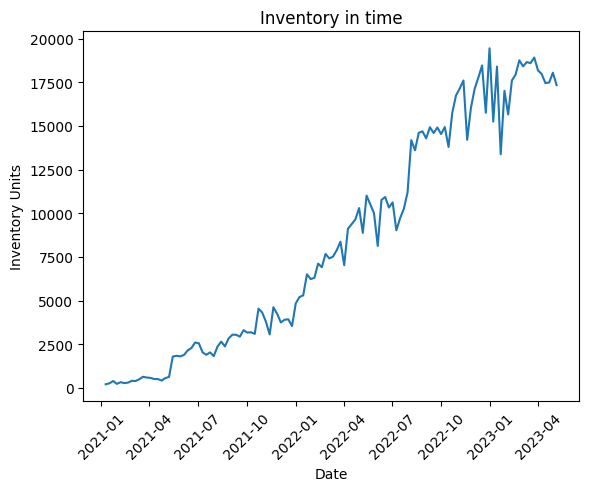

In [306]:
gd = new_df.groupby('date').sum(numeric_only = True)
plt.plot(gd.index, gd.inventory_units)
plt.xticks(rotation = 45)
plt.xlabel('Date') 
plt.ylabel('Inventory Units')
plt.title('Inventory in time')
plt.show()

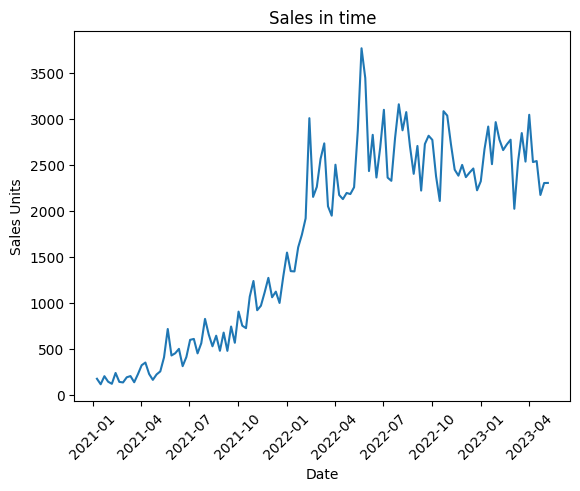

In [307]:
plt.plot(gd.index, gd.sales_units)
plt.xticks(rotation = 45)
plt.xlabel('Date') 
plt.ylabel('Sales Units')
plt.title('Sales in time')
plt.show()

In [308]:
for i,row in new_df[:-1].iterrows():
    date = row["date"]
    product_number = row["product_number"]
    row2 = new_df.iloc[i+1]
    if row2["product_number"] == product_number:
        diff = row2["date"] - date
        if diff.days > 7:
            p_num = row["product_number"]
            weeks_diff = int(diff.days / 7)
            if weeks_diff <= 3:
                incremento = (row2["sales_units"] -  row["sales_units"]) / (weeks_diff)
                current_date = date
                for k in range(1,weeks_diff):
                    new_row = copy.copy(row)
                    current_date += timedelta(days=7)
                    new_row["date"] = current_date
                    new_row["sales_units"] = row["sales_units"] + k * incremento
                    anho, semana, _ = current_date.isocalendar()
                    new_row["identifier"] = str(anho) + str('{:0>2d}'.format(semana)) + "-" + str(row["product_number"])
                    new_df.loc[i+k-1] = new_row

In [309]:
new_df[['sales_units', 'inventory_units', 'year_week']] = new_df[['sales_units', 'inventory_units', 'year_week']].astype(int)

In [310]:
error = []
for i, row in new_df[1:].iterrows():
  if row.sales_units + row.inventory_units < new_df.loc[i-1].inventory_units:
      error.append(new_df.loc[i-1].inventory_units - (row.sales_units + row.inventory_units))
      if new_df.loc[i-1].inventory_units - (row.sales_units + row.inventory_units) < 0:
          print(f"Fila {i} tiene un error con una medida de {new_df.loc[i-1].inventory_units - (row.sales_units + row.inventory_units)}")

print("Numero de errores es ", len(error))
print("Min de errores es ", np.array(error).min())
print("Min de errores es ", np.array(error).max())
print("Media de errores es ", np.array(error).mean())
print("Std de errores es ", np.array(error).std())


Numero de errores es  3004
Min de errores es  1
Min de errores es  837
Media de errores es  109.04494007989348
Std de errores es  114.55070998246332


In [311]:
new_df["purchases_units"] =  0

for i in range(1, len(new_df)):
    compras = new_df.at[i, 'inventory_units'] - (new_df.at[i, 'sales_units'] + new_df.at[i-1, 'inventory_units'])
    new_df.at[i, 'purchases_units'] = compras
    
new_df.head()
new_df.purchases_units[new_df.purchases_units < 0 ] = 0


<ipython-input-311-f3ee59b97159>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.purchases_units[new_df.purchases_units < 0 ] = 0


In [312]:

def cast_to_sin_and_cos(dataframe):
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  dataframe = dataframe.drop(["date"], axis = 1)

  week = 24*60*60*7
  year = 52*week

  dataframe['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
  dataframe['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
  dataframe['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  dataframe['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

  return dataframe


In [313]:
new_df = cast_to_sin_and_cos(new_df)

## Separación validación

In [314]:
n = len(new_df)
train_df = new_df[0:int(n*0.8)]
val_df = new_df[int(n*0.8):]
num_features = new_df.shape[1]

## Normalización

In [315]:
X_train = train_df.drop(["id"], axis =1)
X_val = val_df.drop(["id"], axis =1)

X_train = pd.get_dummies(X_train, columns=['product_number', 'segment', 'prod_category'])
X_val = pd.get_dummies(X_val, columns=['product_number', 'segment', 'prod_category'])

In [316]:
num_columns = ["inventory_units", "year_week", "display_size", "sales_units", "specs", "Week sin", "Week cos", "Year sin", "Year cos"]

sub_X_train = X_train[num_columns]
sub_X_val = X_val[num_columns]

train_mean = sub_X_train.mean()
train_std = sub_X_train.std()

sub_X_train = (sub_X_train - train_mean) / train_std
sub_X_val = (sub_X_val - train_mean) / train_std

X_train[num_columns] = sub_X_train[num_columns]

X_val[num_columns] = sub_X_val[num_columns]

In [317]:
test_df = []

product_number = [c for c in X_train.columns if c.startswith("product_number")]
for pn in product_number:
  test_df.append((pn, X_train[X_train[pn] == 1][-36:]))


In [318]:
def sliding_window(data, labels, input_width, label_width=1, offset=1):
    x = []
    y = []

    for i in range(len(data)-input_width-label_width-offset):
        _x = data[i:i+input_width]
        _y = labels[i+input_width+offset:i+input_width+offset+label_width]
        x.append(_x)
        y.append(_y)

    x, y = np.array(x),np.array(y)

    if len(x.shape) == 2:
        x = x[:,:,np.newaxis]

    if len(y.shape) == 2:
        y = y[:,:,np.newaxis]
    
    return x, y

## Ventanas

In [334]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train, val, test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train
    self.val_df = val
    self.test_df = test

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  WindowGenerator.example = example
  
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  def plot(self, model=None, plot_col='inventory_units', max_subplots=1):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      #plt.scatter(self.label_indices, labels[n, :, label_col_index],
       #           edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        print(predictions.shape)
        #predictions[n, :, label_col_index] = predictions[n, :, label_col_index] * train_std + train_mean
        print(self.label_indices.shape)
        print(f"Prediccion es {predictions[n, :, label_col_index]}")
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
        #plt.savefig(object_number, dpi='figure', format=None)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

    return predictions[n, :, label_col_index]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels



### Baseline


In [325]:
OUT_STEPS = 13

In [345]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [327]:
MAX_EPOCHS = 150

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val, callbacks=[early_stopping])
  return history

In [346]:
wide_window = WindowGenerator(
    input_width=15, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['inventory_units'], train = X_train, val = X_val, test = None)

history = compile_and_fit(multi_lstm_model, wide_window)

Epoch 1/150
184/184 [==============================] - 6s 18ms/step - loss: 0.9542 - root_mean_squared_error: 0.9769 - val_loss: 1.4361 - val_root_mean_squared_error: 1.1984
Epoch 2/150
184/184 [==============================] - 4s 21ms/step - loss: 0.9007 - root_mean_squared_error: 0.9491 - val_loss: 1.3703 - val_root_mean_squared_error: 1.1706
Epoch 3/150
184/184 [==============================] - 3s 15ms/step - loss: 0.8788 - root_mean_squared_error: 0.9374 - val_loss: 1.3677 - val_root_mean_squared_error: 1.1695
Epoch 4/150
184/184 [==============================] - 3s 13ms/step - loss: 0.8568 - root_mean_squared_error: 0.9256 - val_loss: 1.3547 - val_root_mean_squared_error: 1.1639
Epoch 5/150
184/184 [==============================] - 4s 24ms/step - loss: 0.8392 - root_mean_squared_error: 0.9161 - val_loss: 1.3989 - val_root_mean_squared_error: 1.1828
Epoch 6/150
184/184 [==============================] - 5s 27ms/step - loss: 0.8250 - root_mean_squared_error: 0.9083 - val_loss: 1

In [ ]:
multi_lstm_model.save('./model.h5')

(32, 13, 14)
(13,)
Prediccion es [ 0.09062031  0.1470185   0.17827705  0.17900398  0.08907631  0.1027823
  0.1282067   0.21805924  0.14941007 -0.01409388 -0.1400033  -0.20940855
 -0.19527406]
(32, 13, 14)
(13,)
Prediccion es [-0.7009012  -0.7475311  -0.6308774  -0.4822844  -0.15246743  0.04621191
  0.09279214  0.07565591 -0.01573925 -0.03463842  0.02571464  0.07051044
  0.04707415]
(32, 13, 14)
(13,)
Prediccion es [ 0.21667361  0.10803373 -0.06823551 -0.11192143 -0.02201648  0.01326989
  0.0547783   0.17226195  0.23830009  0.38260204  0.59989345  0.73574895
  0.8377032 ]
(32, 13, 14)
(13,)
Prediccion es [ 0.33192515  0.26458484  0.06386151 -0.1433929   0.13869888  0.27445486
  0.30836076  0.24583864  0.33618122  0.48392516  0.66181386  0.73390377
  0.7118807 ]
(32, 13, 14)
(13,)
Prediccion es [-0.01988119  0.09189574  0.1708644   0.25858194  0.24769053  0.33590436
  0.32409596  0.2804379   0.08999701 -0.1016192  -0.09697984 -0.04693746
 -0.00171599]
(32, 13, 14)
(13,)
Prediccion es [ 0

<ipython-input-334-b697076f1920>:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 8))


Prediccion es [-0.5766279  -0.56900686 -0.5574286  -0.5372741  -0.3408662  -0.3117342
 -0.3815264  -0.4190783  -0.4170307  -0.34273738 -0.28882676 -0.3235751
 -0.37863988]
(32, 13, 14)
(13,)
Prediccion es [0.27997515 0.15978542 0.28264588 0.38729963 0.4269143  0.5713222
 0.63360345 0.7948193  0.77152276 0.7480594  0.6963445  0.6495583
 0.67485154]
(32, 13, 14)
(13,)
Prediccion es [ 0.23896594  0.13044825 -0.01357377 -0.1356558  -0.18397227 -0.15640393
 -0.19020864 -0.13771823 -0.17654338 -0.14385141  0.02850268  0.19722538
  0.3654824 ]
(32, 13, 14)
(13,)
Prediccion es [0.14558938 0.16526374 0.06604835 0.12239583 0.1765787  0.19209555
 0.2314292  0.29692426 0.4473553  0.5473009  0.60875714 0.41412488
 0.23004028]
(32, 13, 14)
(13,)
Prediccion es [-0.09983412 -0.2224127  -0.26635298 -0.17881262 -0.02376597  0.11627942
  0.28169075  0.49695015  0.6912959   0.87448716  0.9727969   0.8569038
  0.7429606 ]
(32, 13, 14)
(13,)
Prediccion es [-0.46688426 -0.55626255 -0.46041152 -0.3015091  -0.

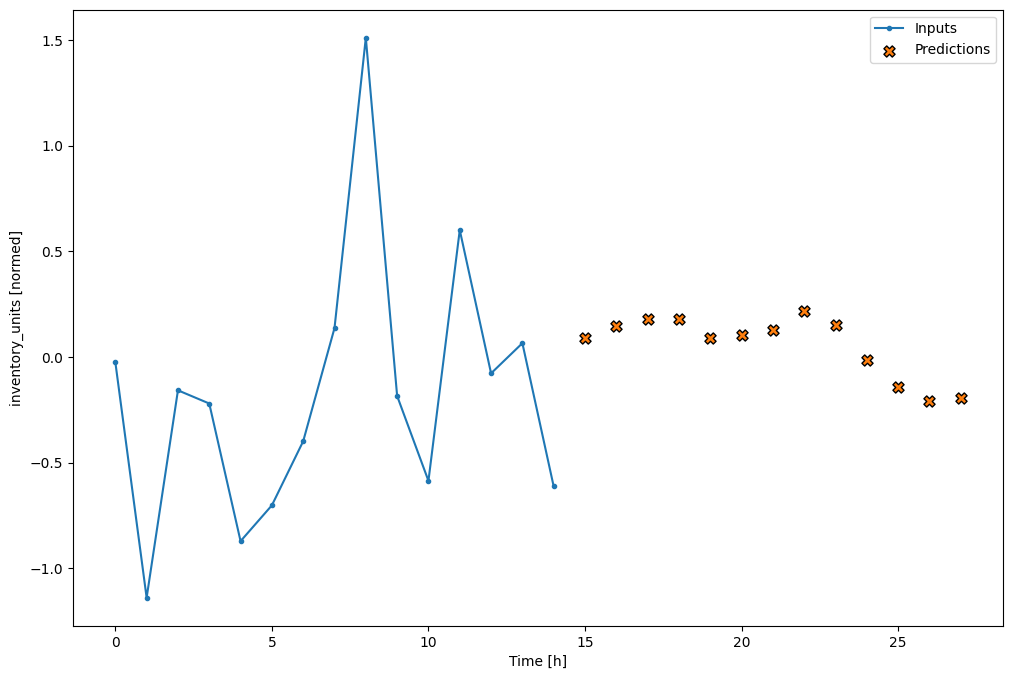

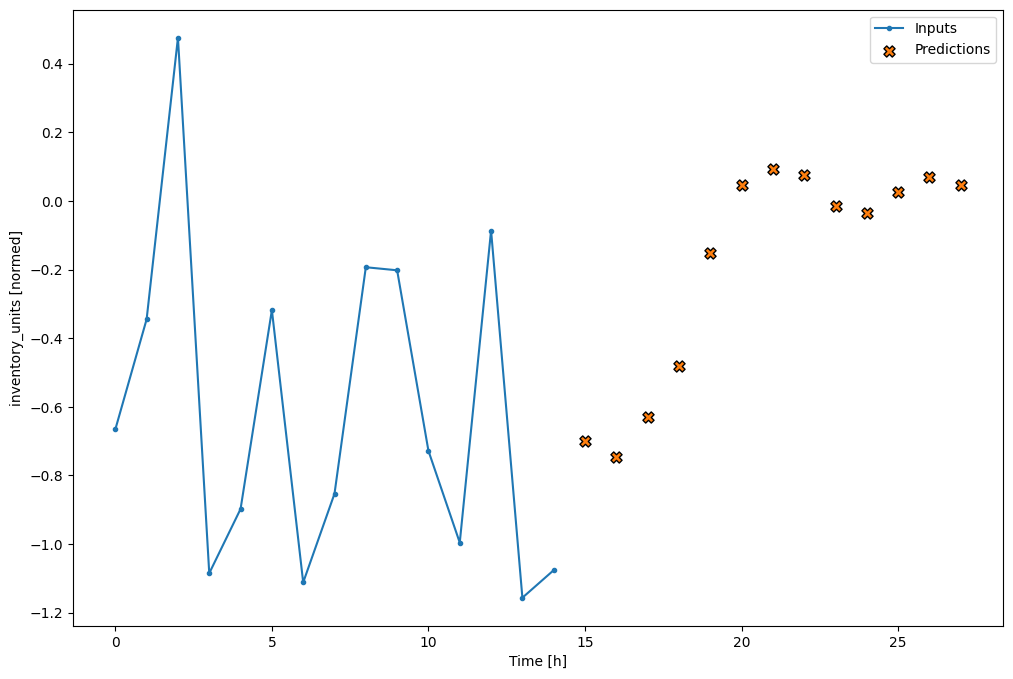

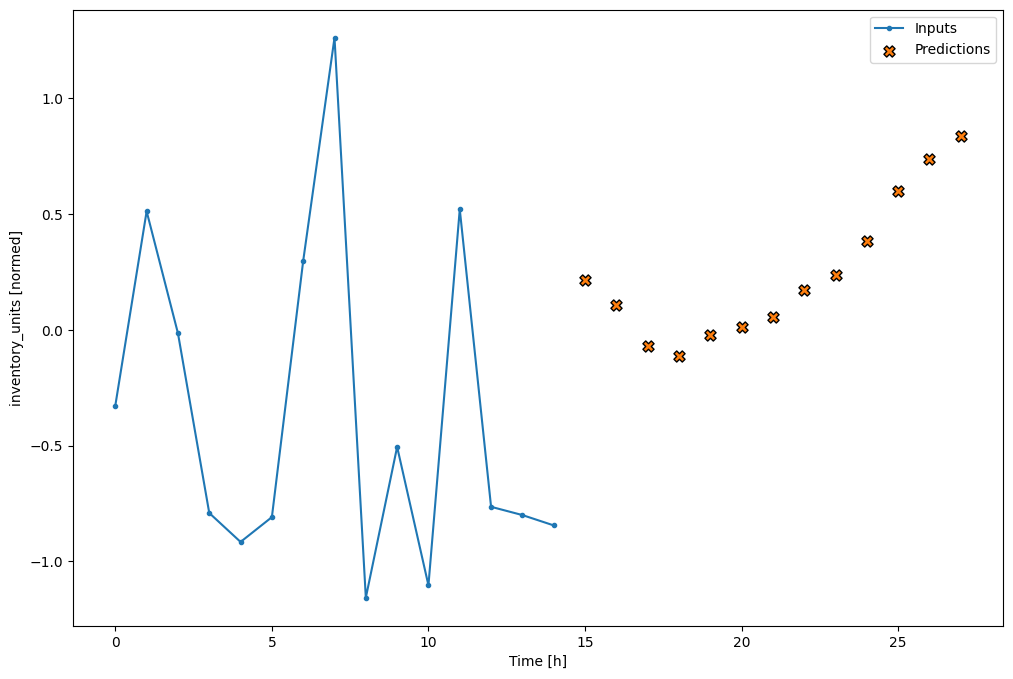

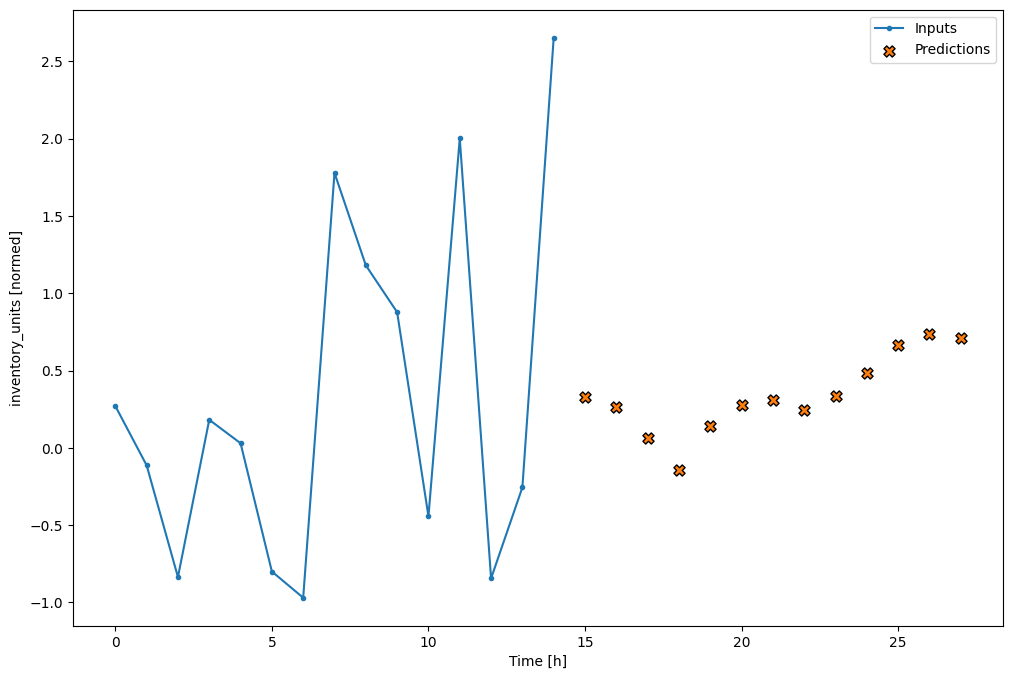

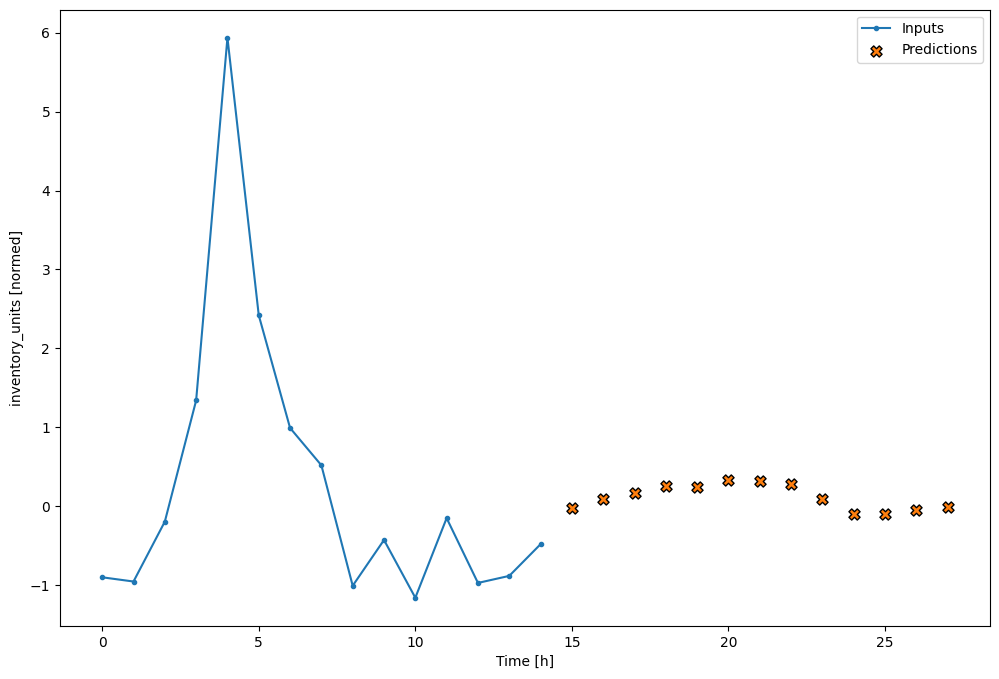

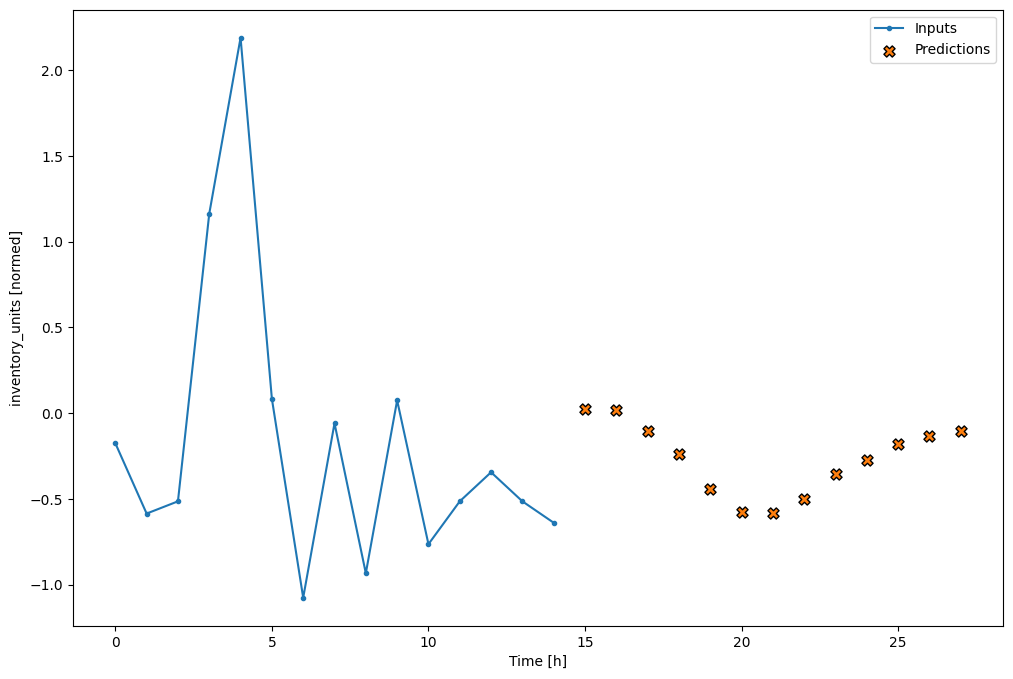

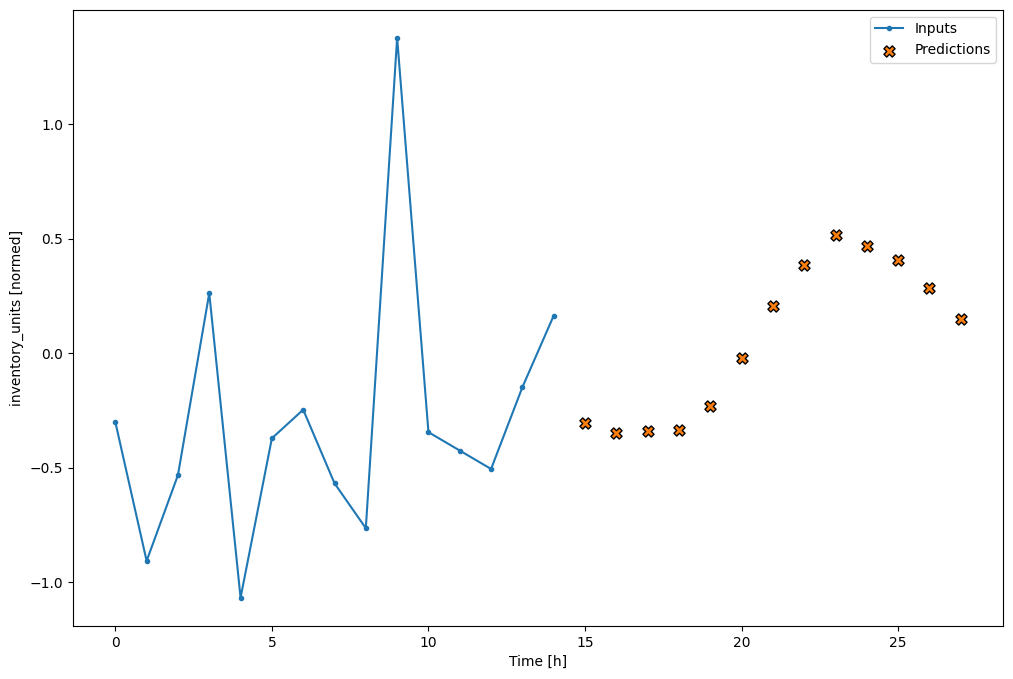

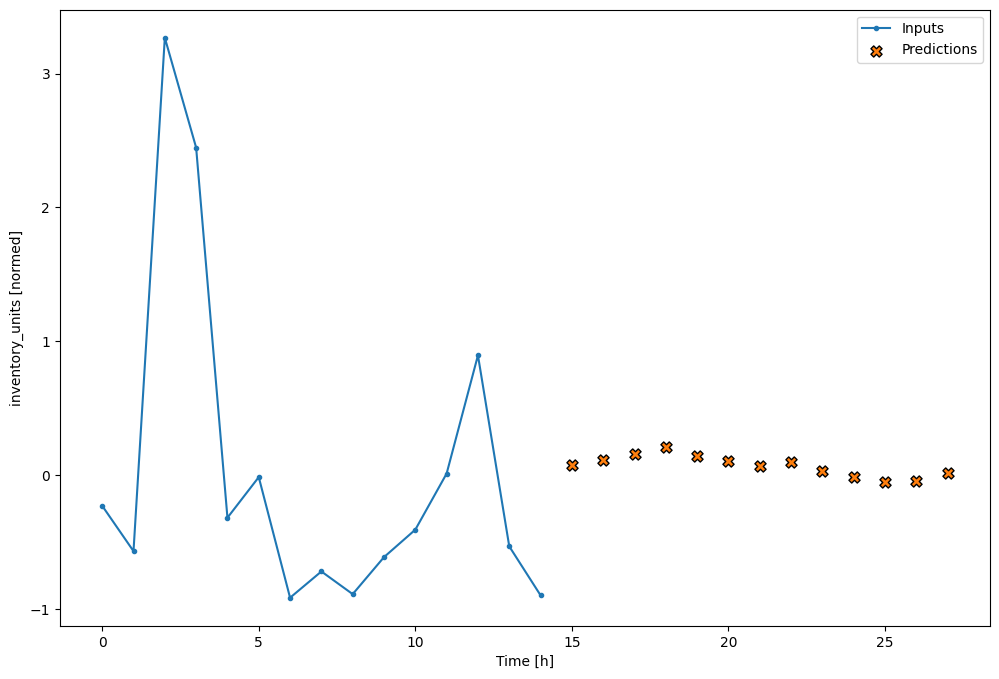

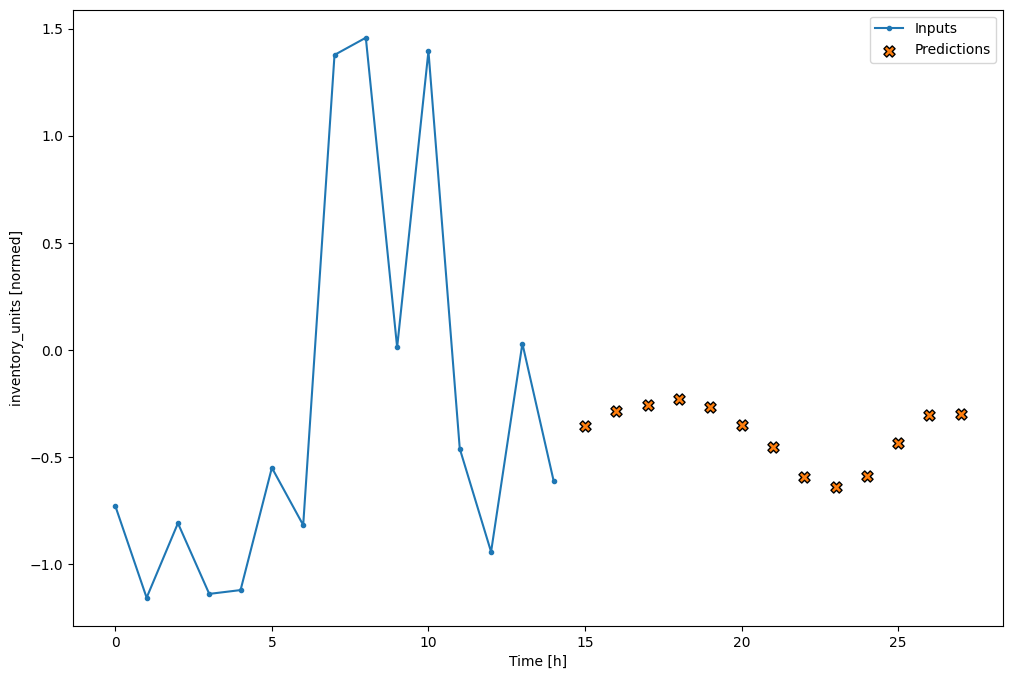

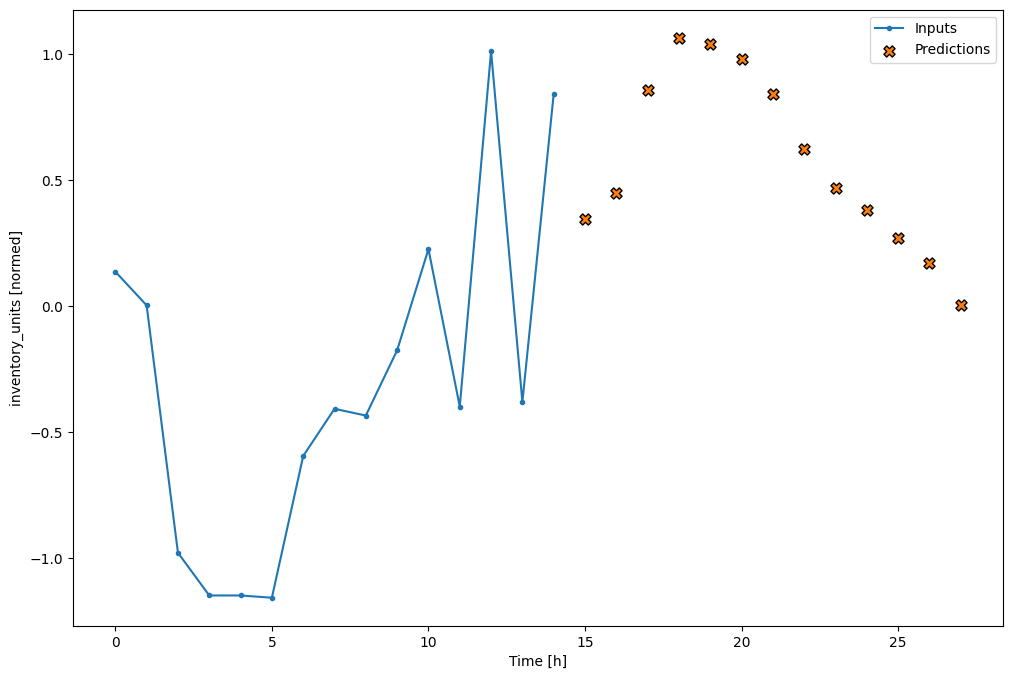

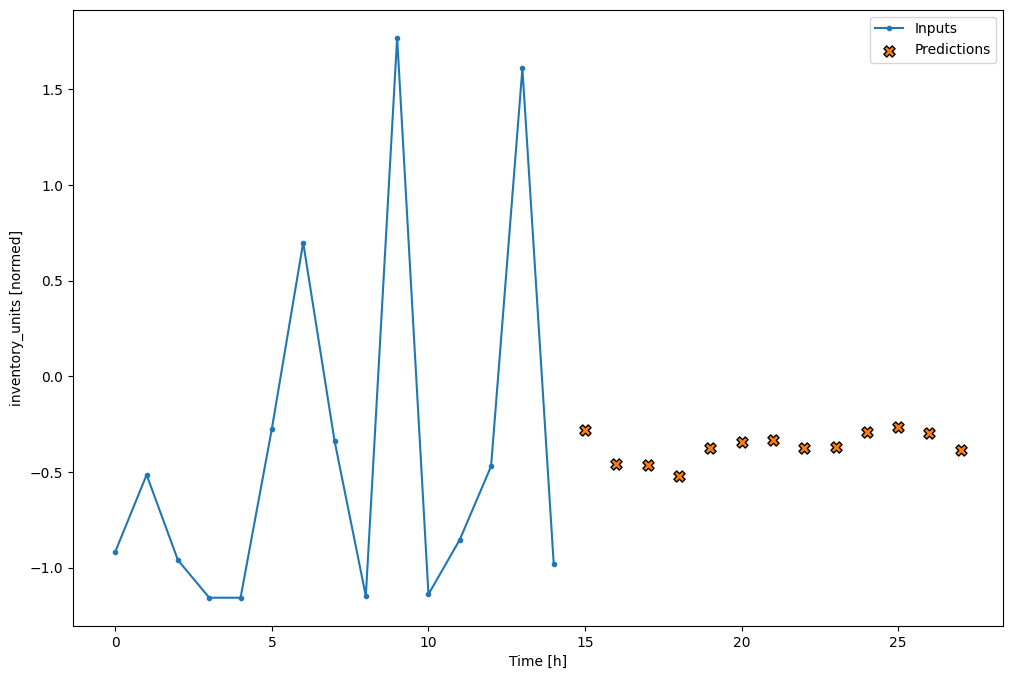

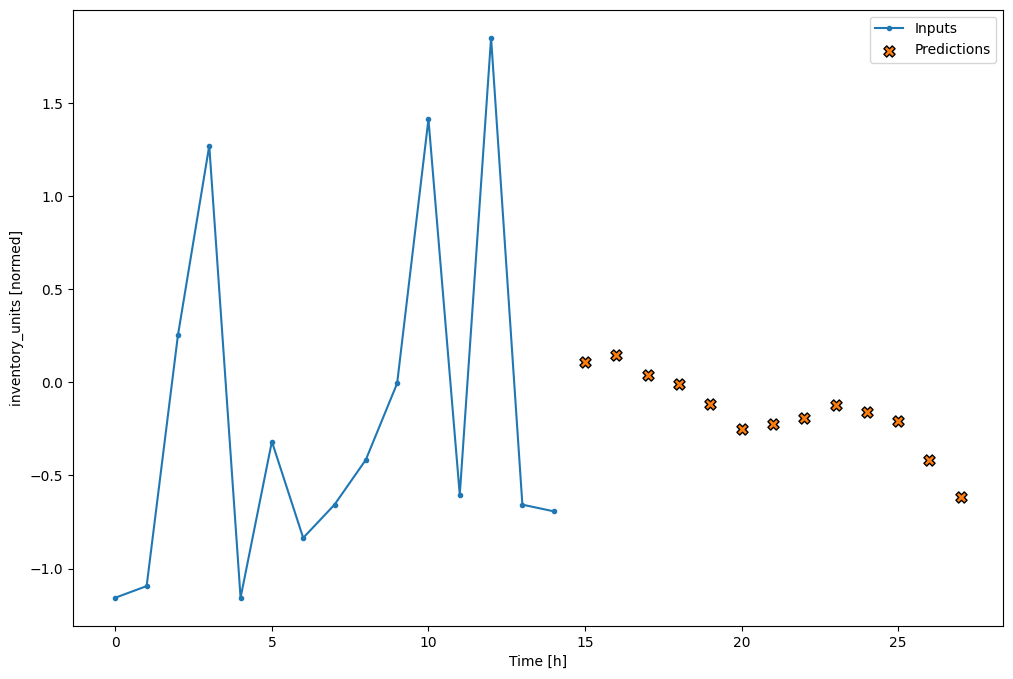

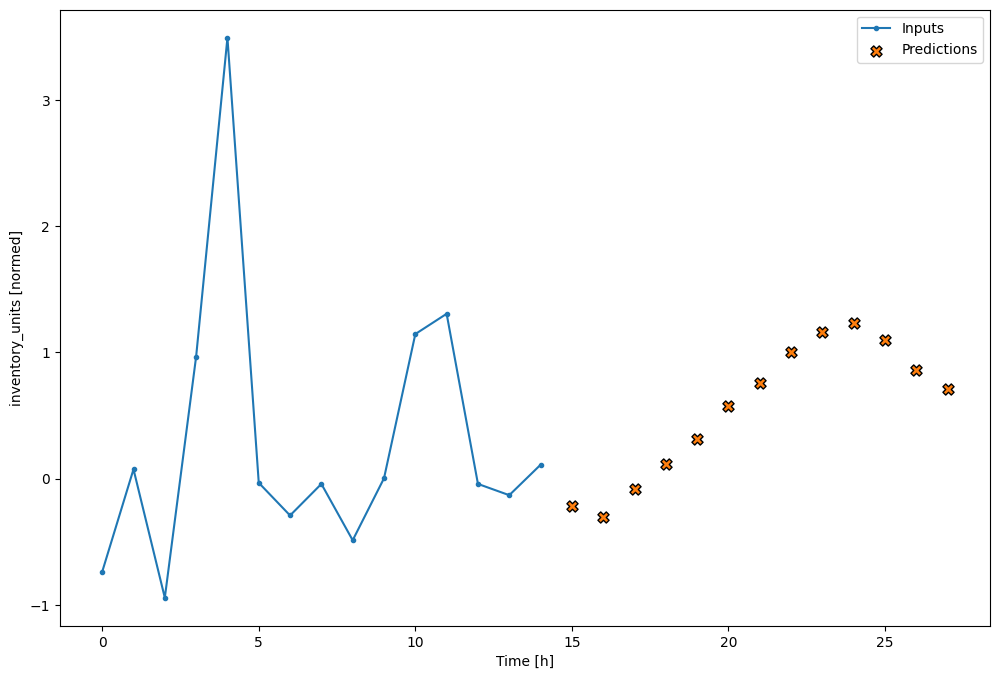

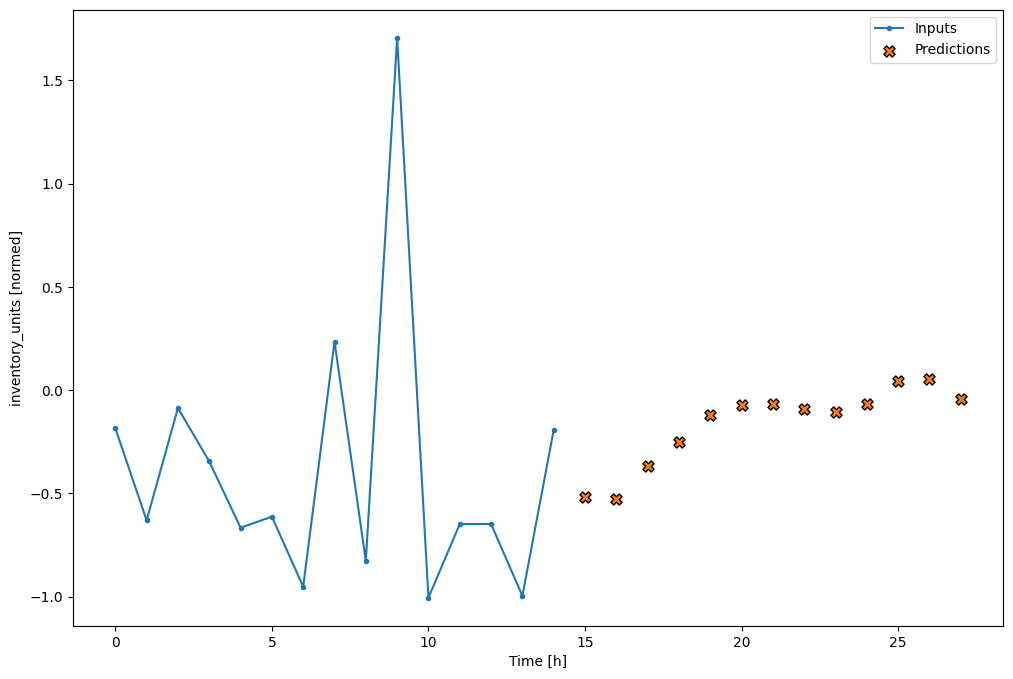

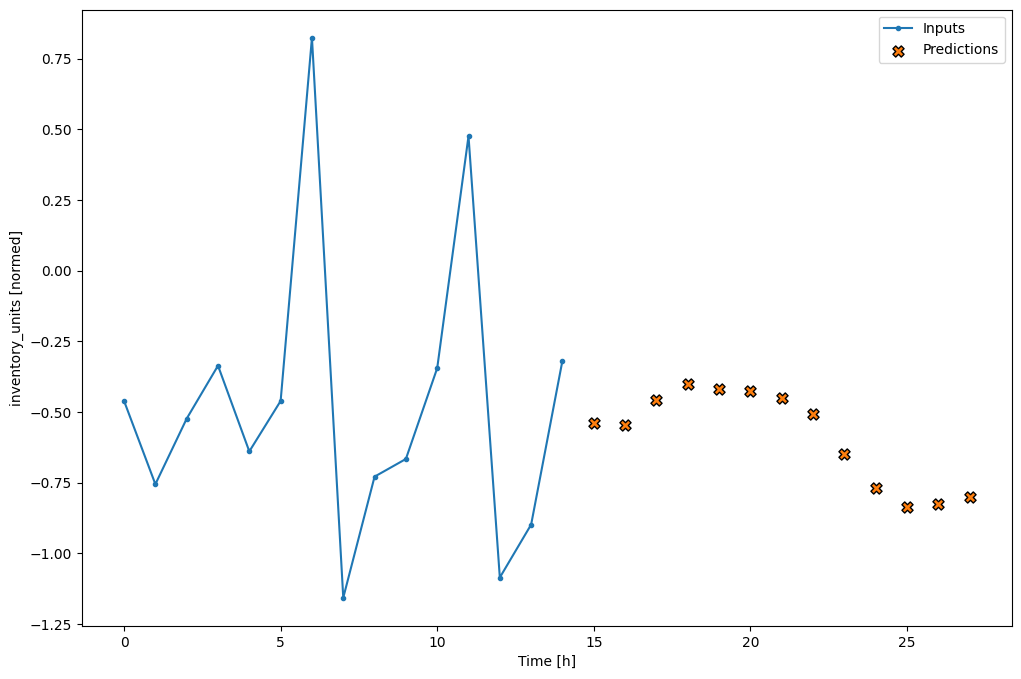

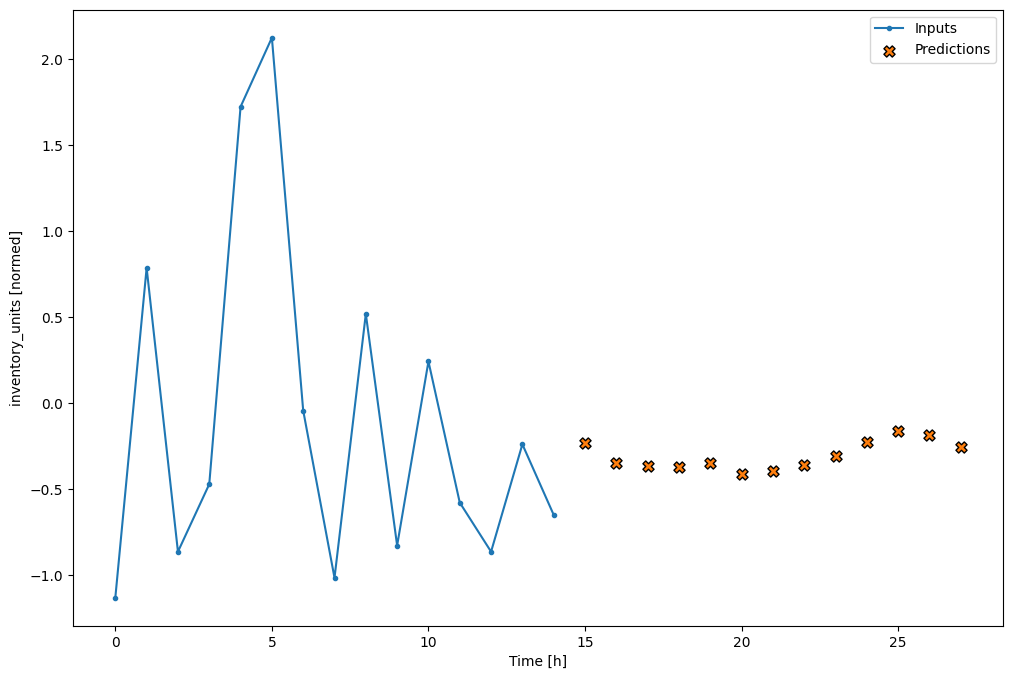

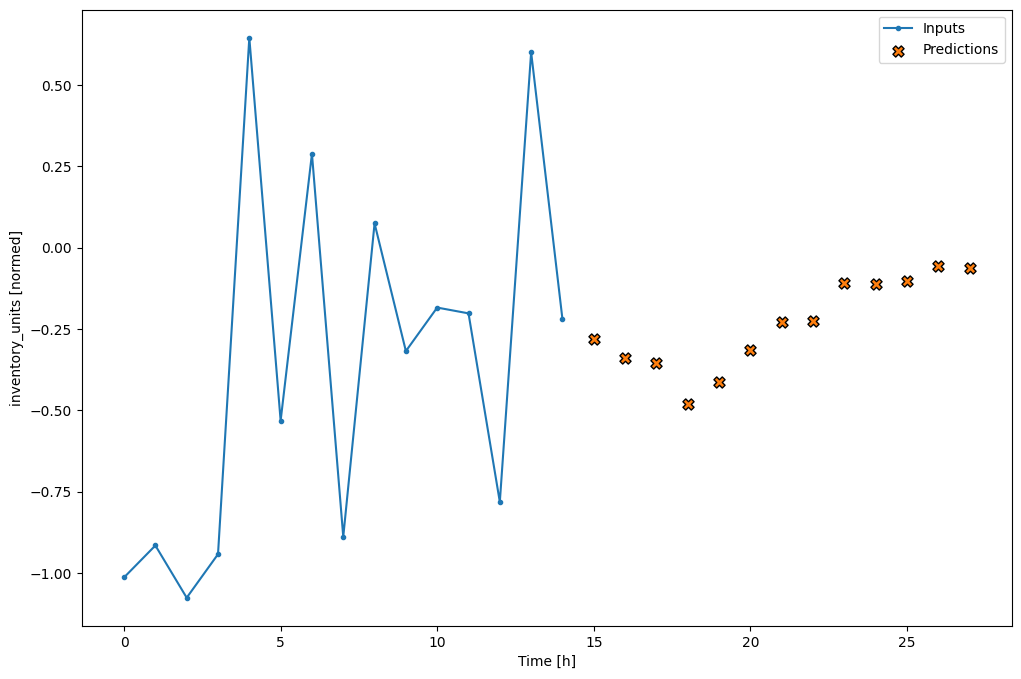

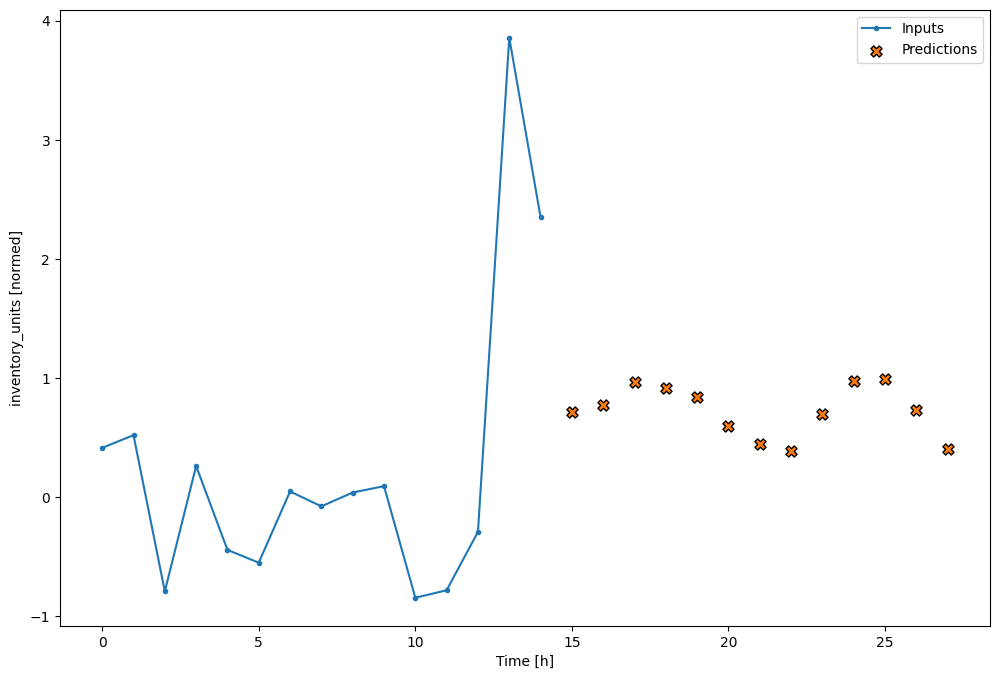

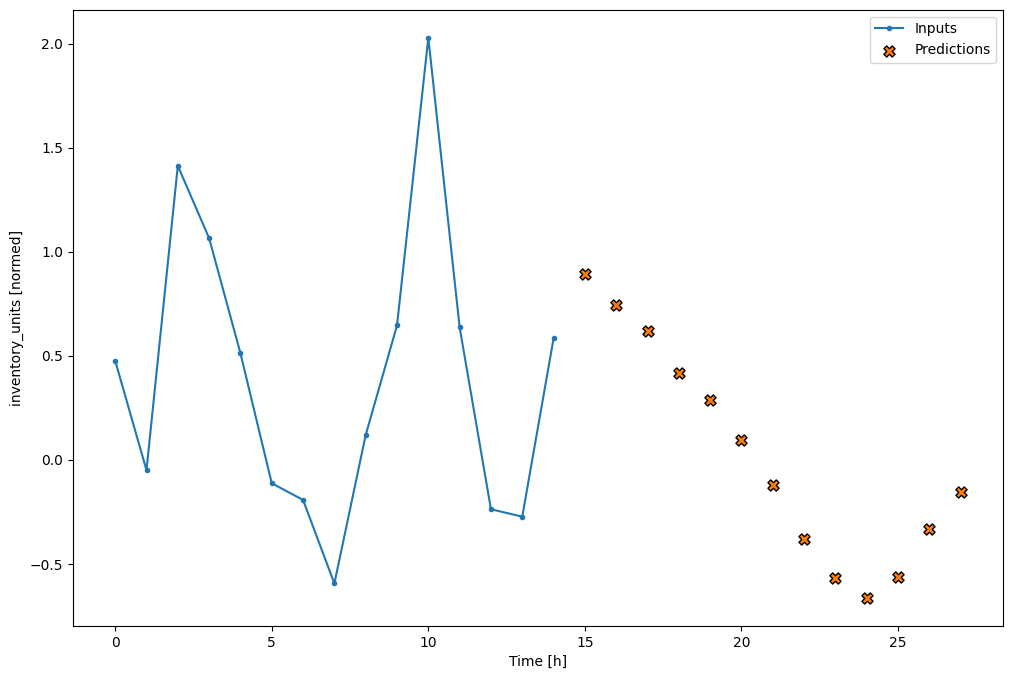

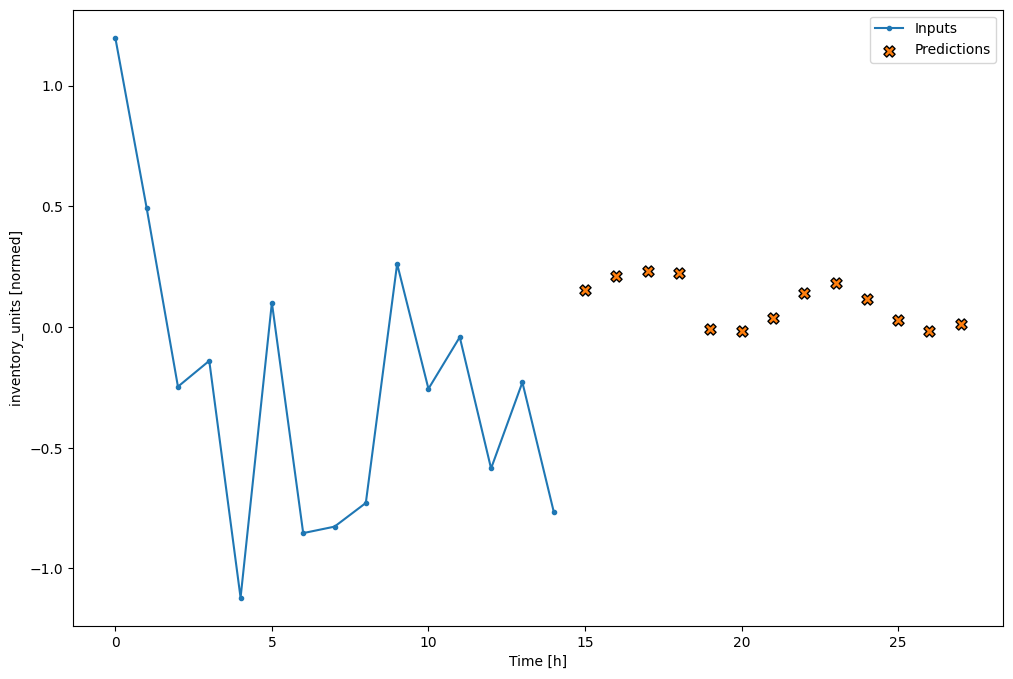

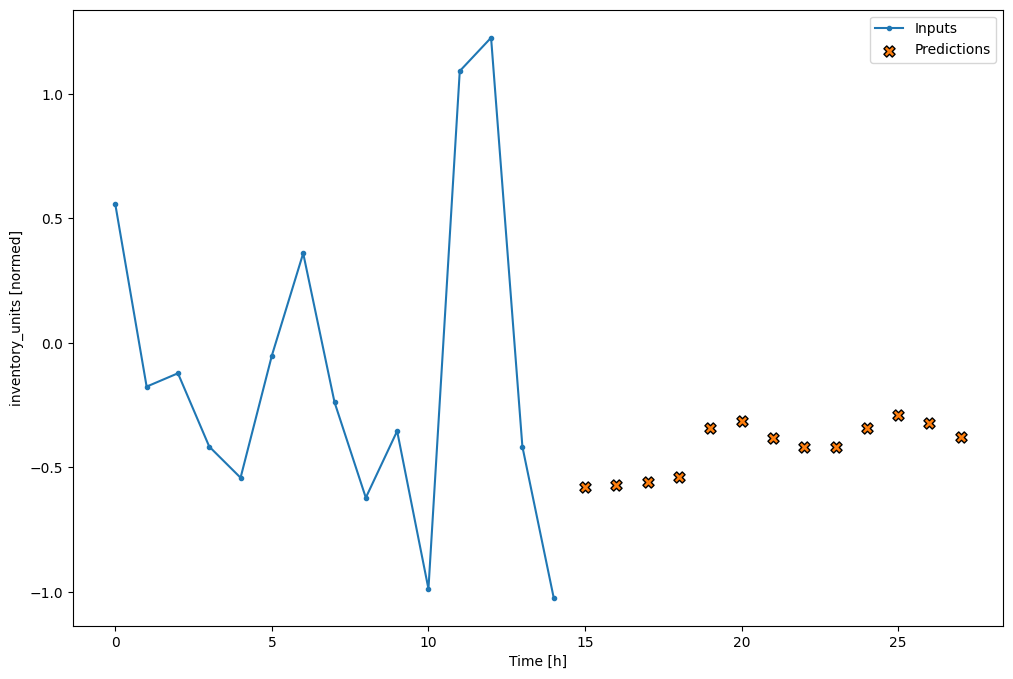

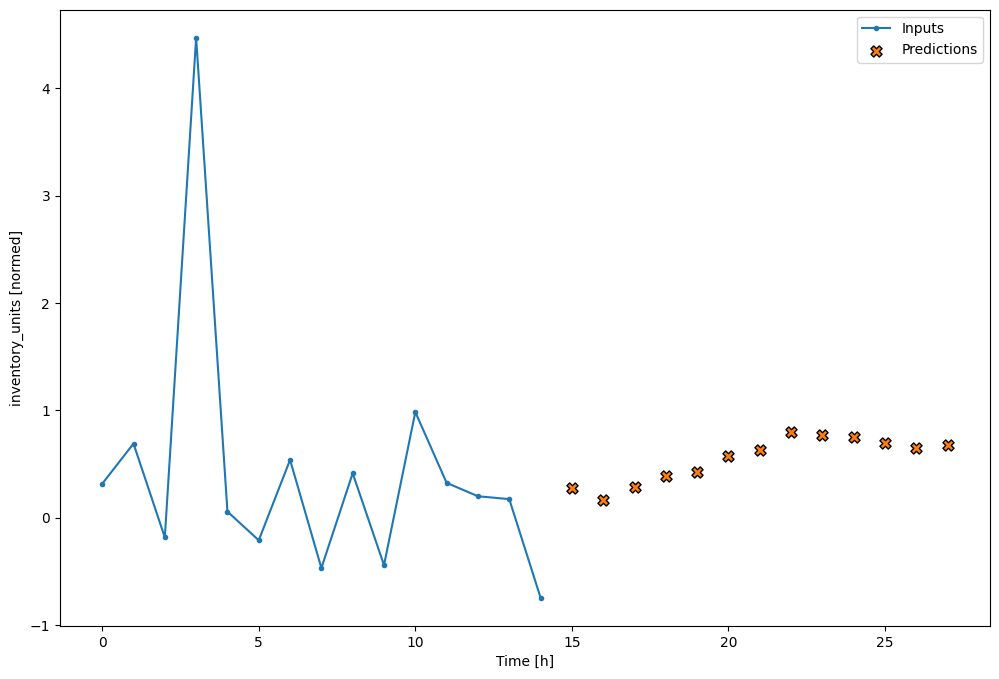

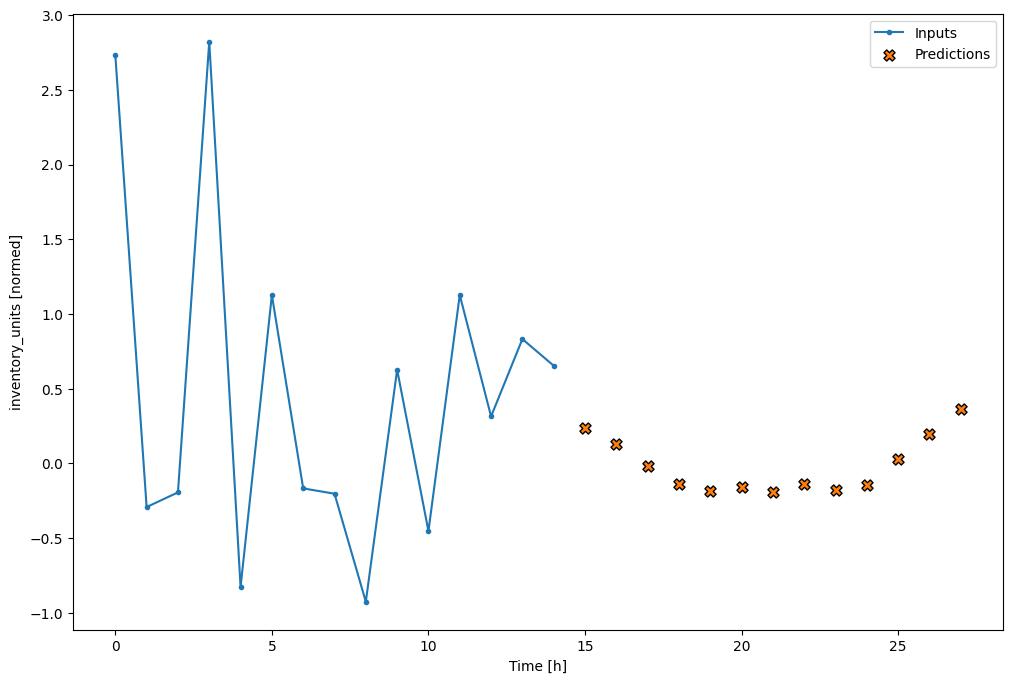

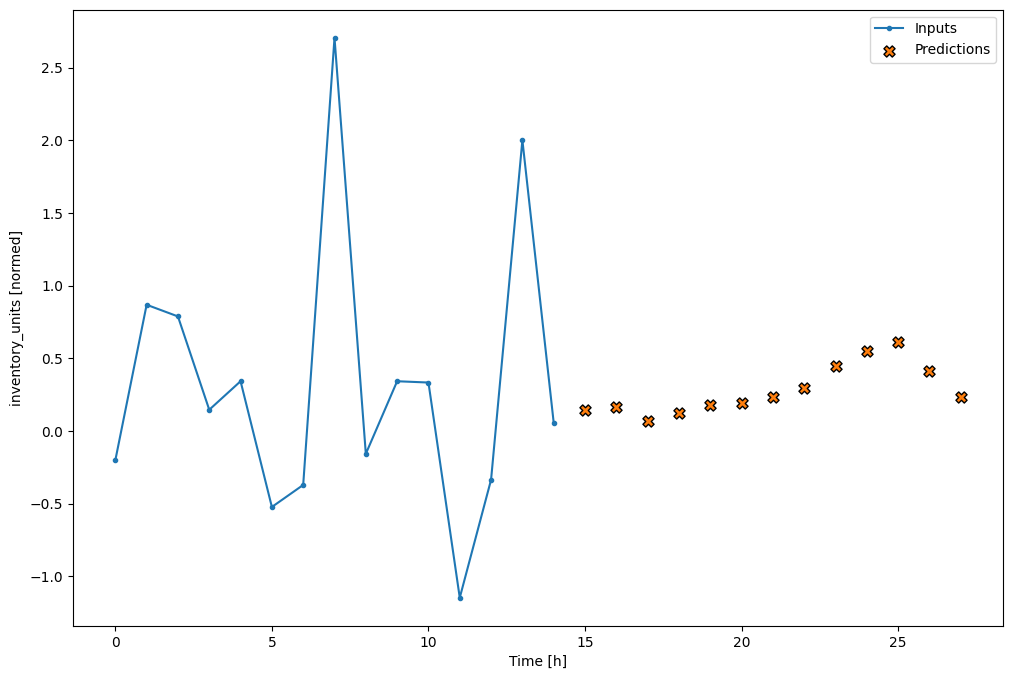

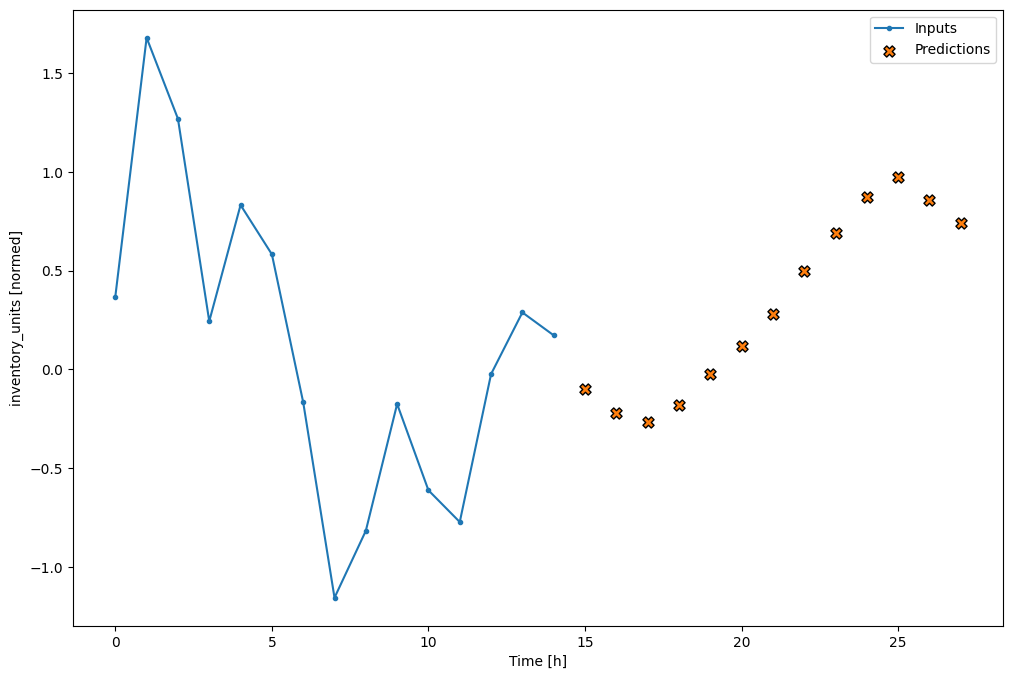

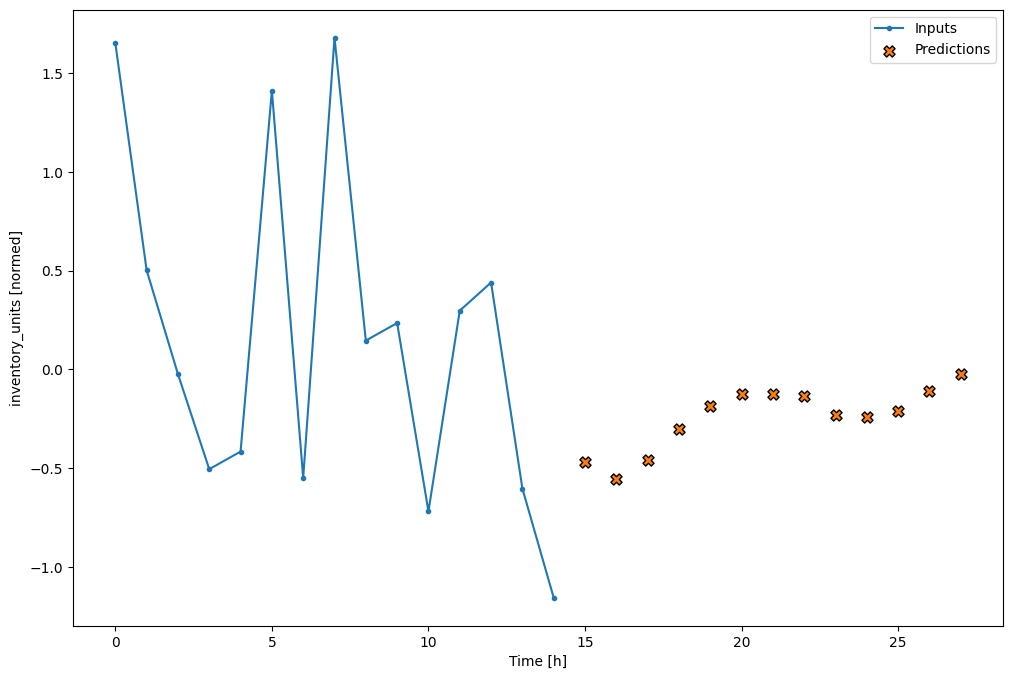

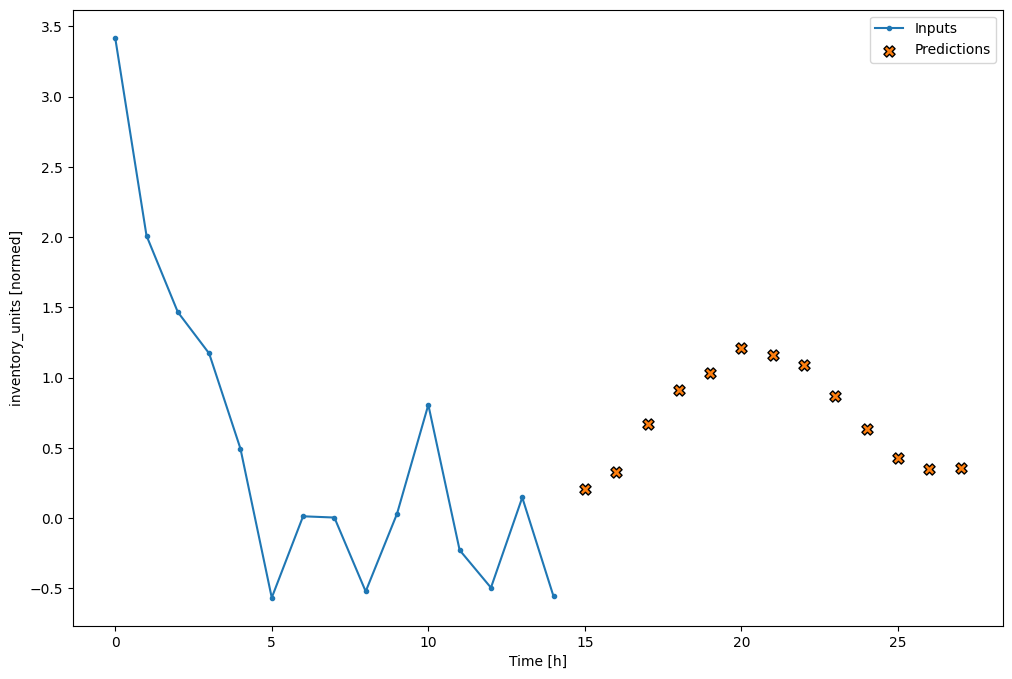

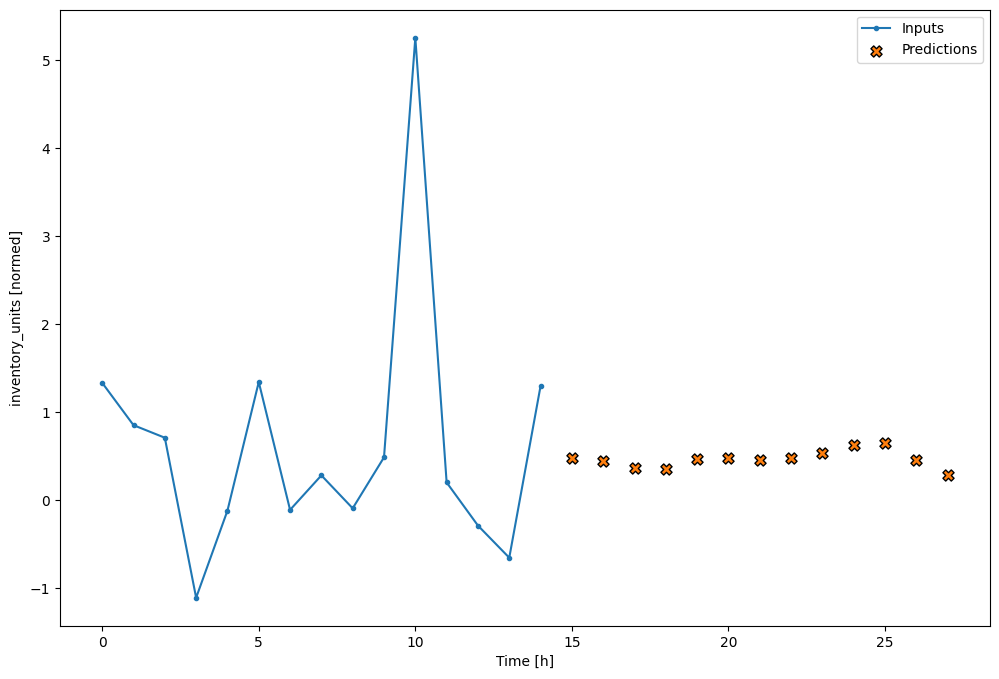

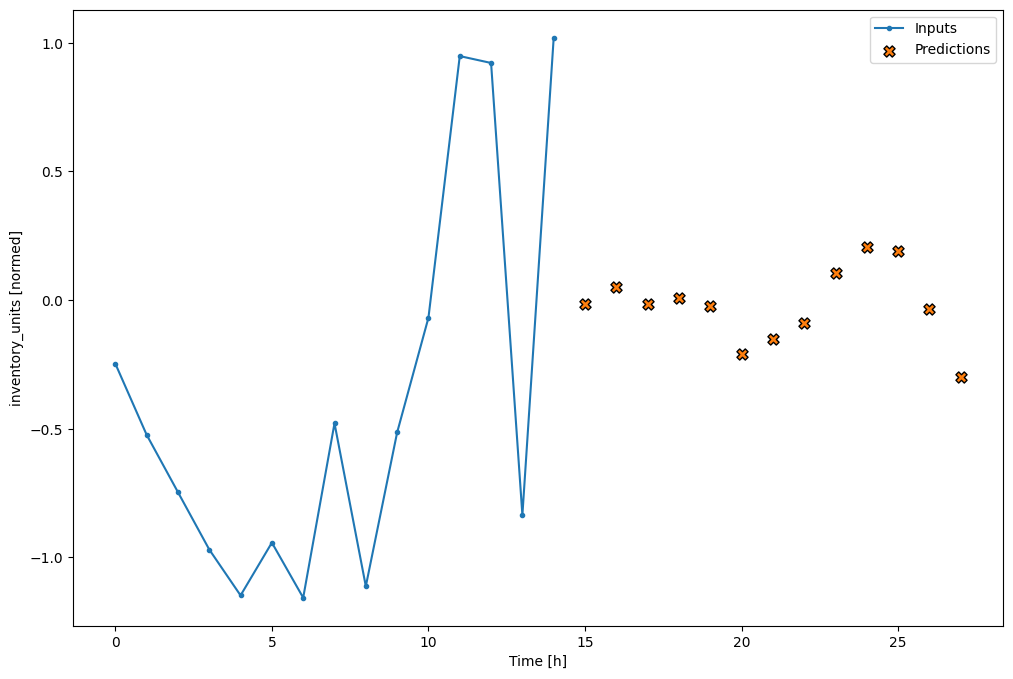

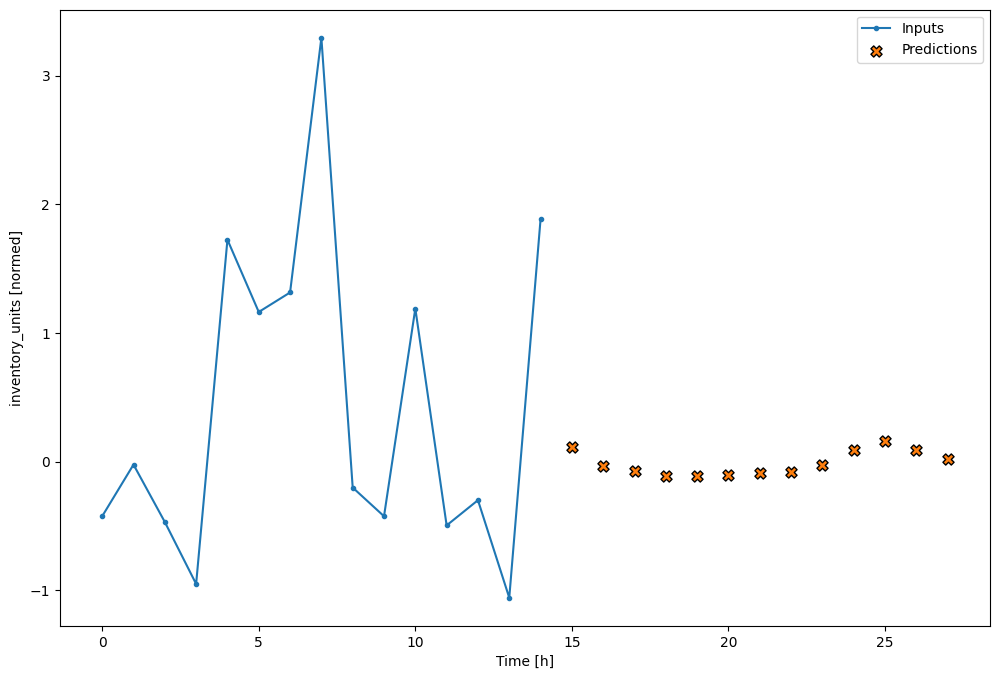

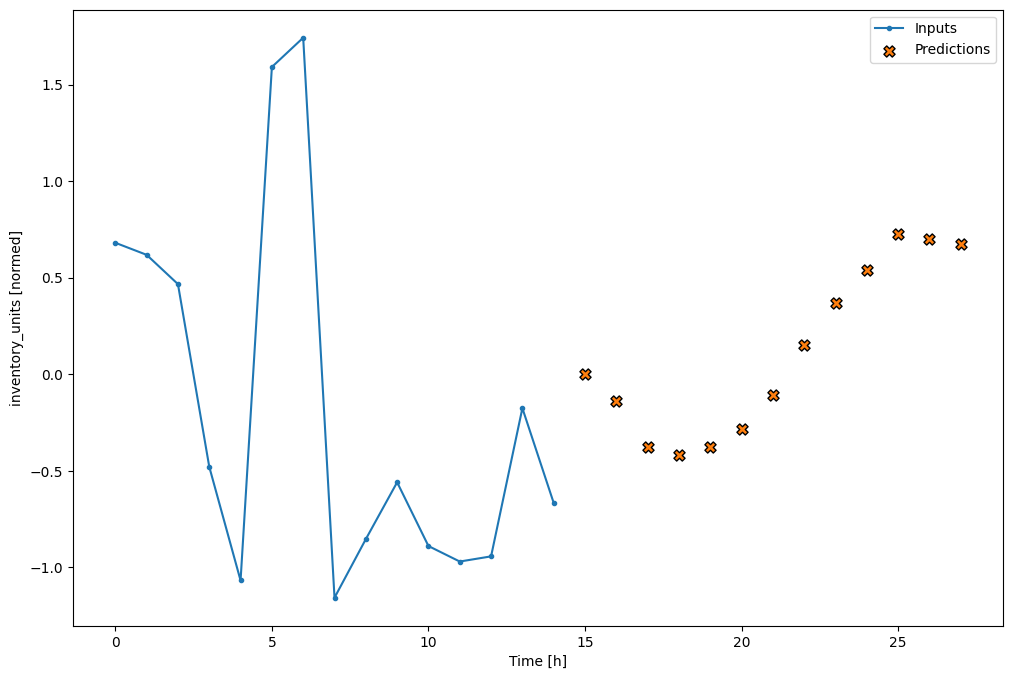

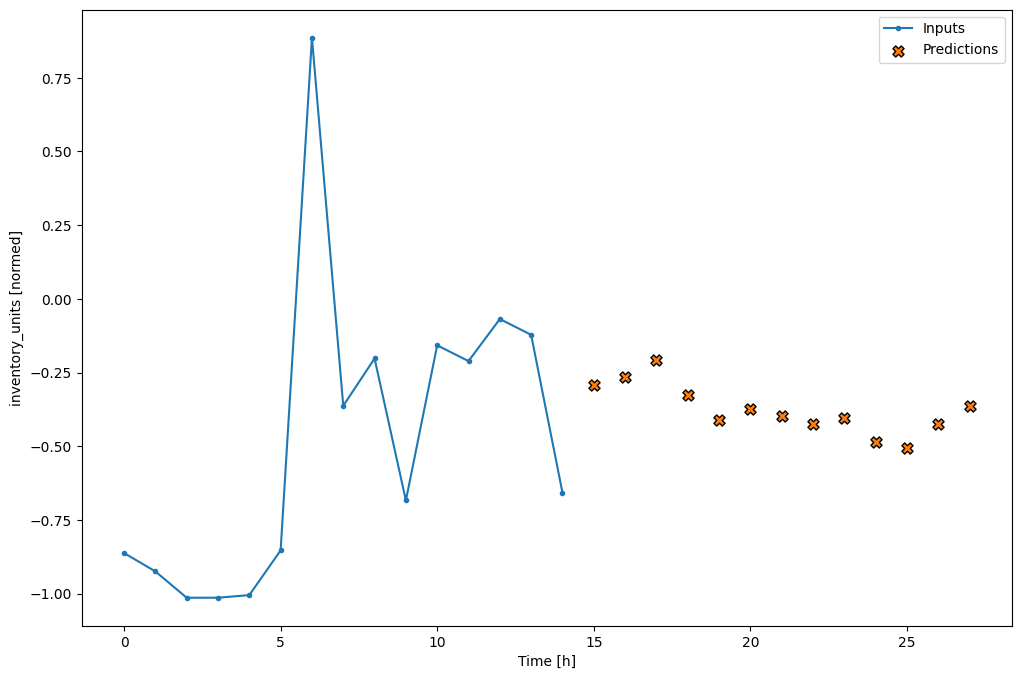

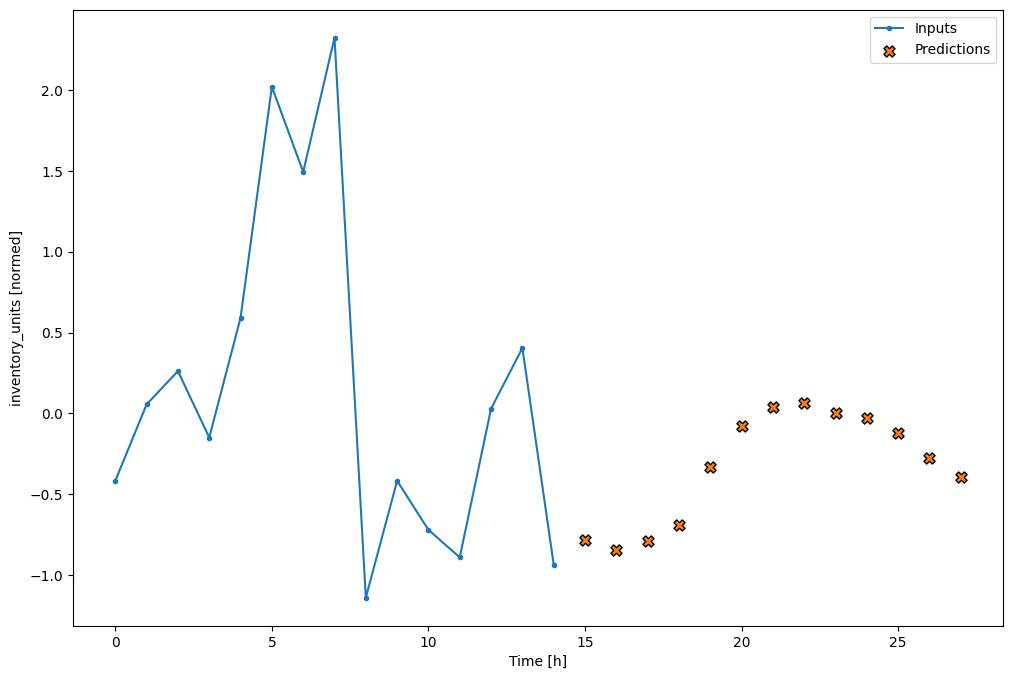

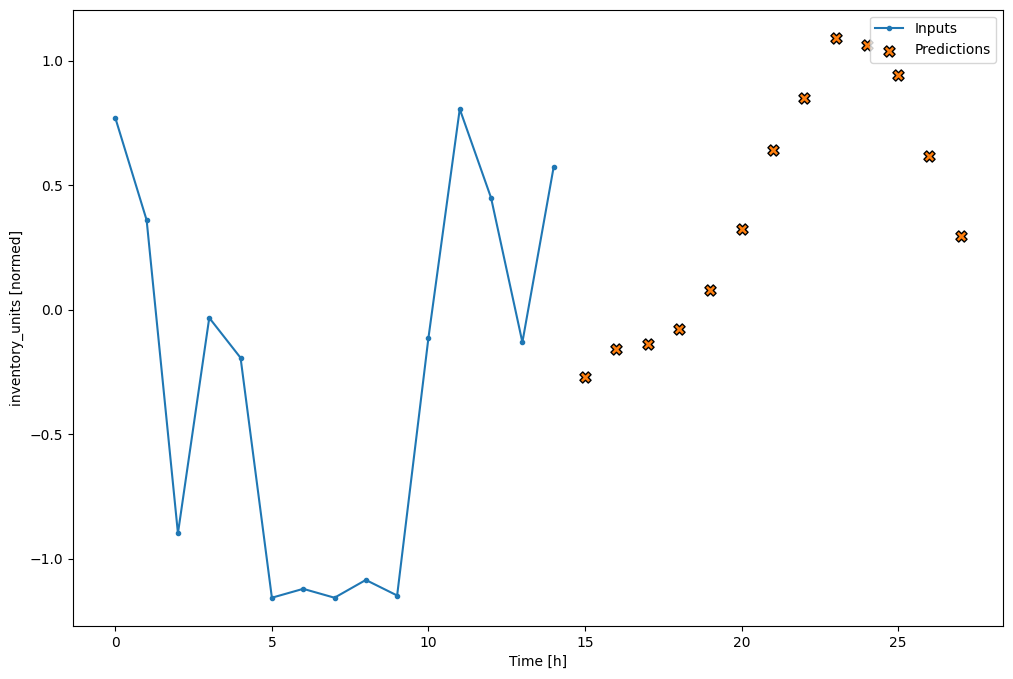

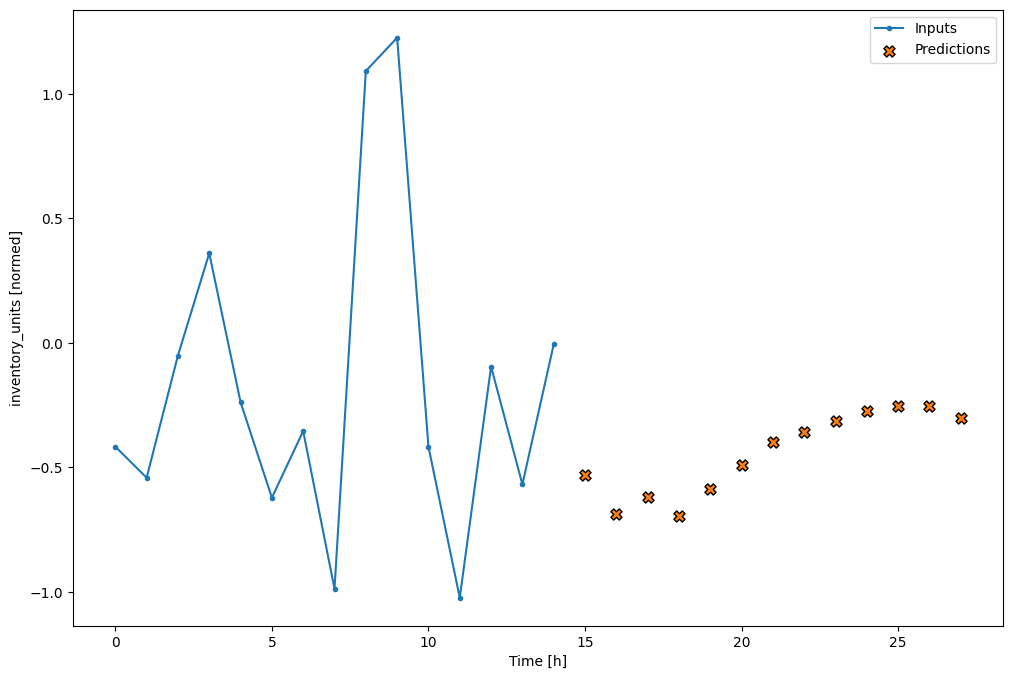

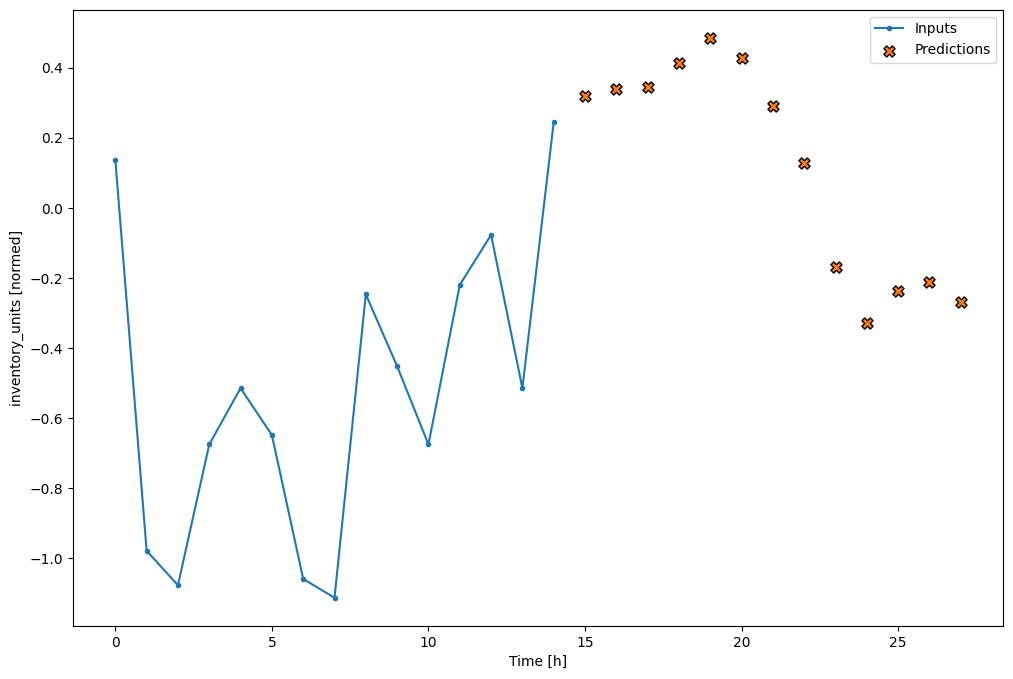

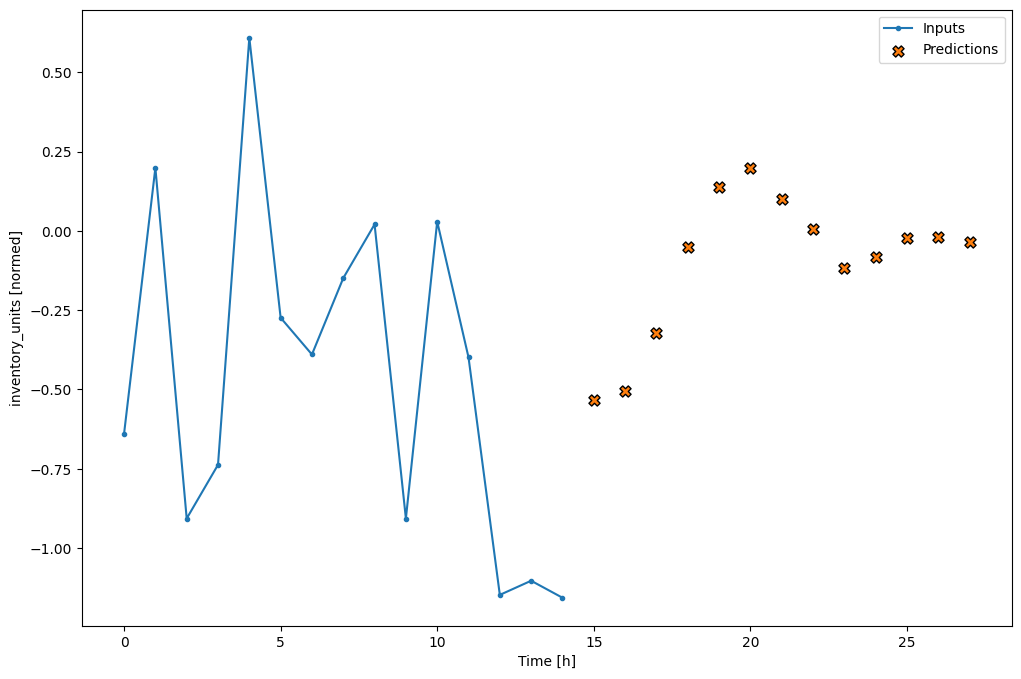

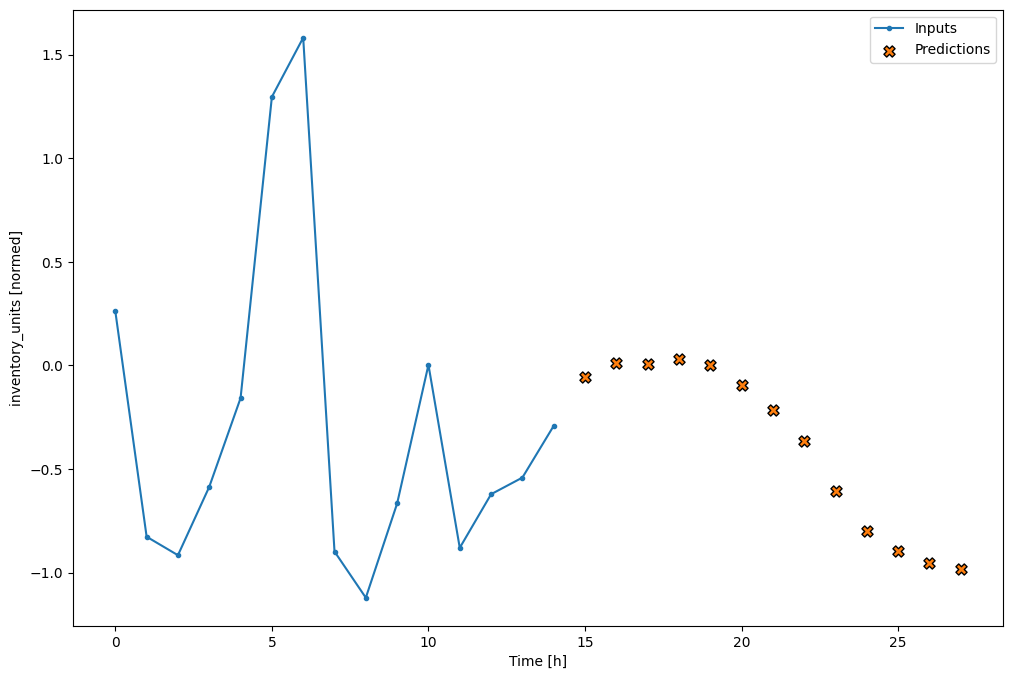

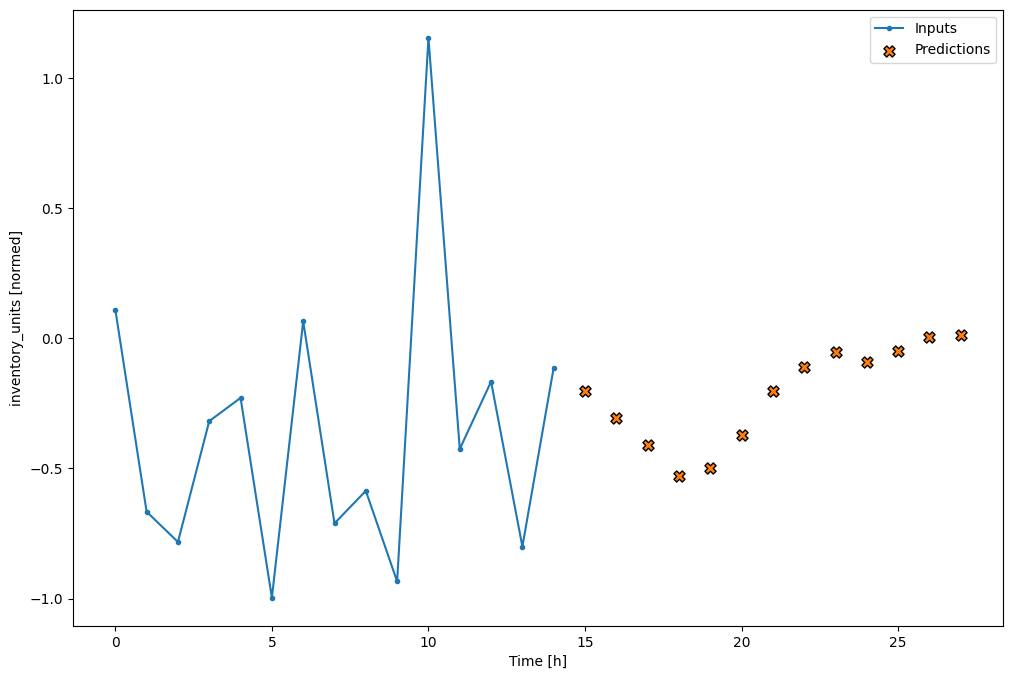

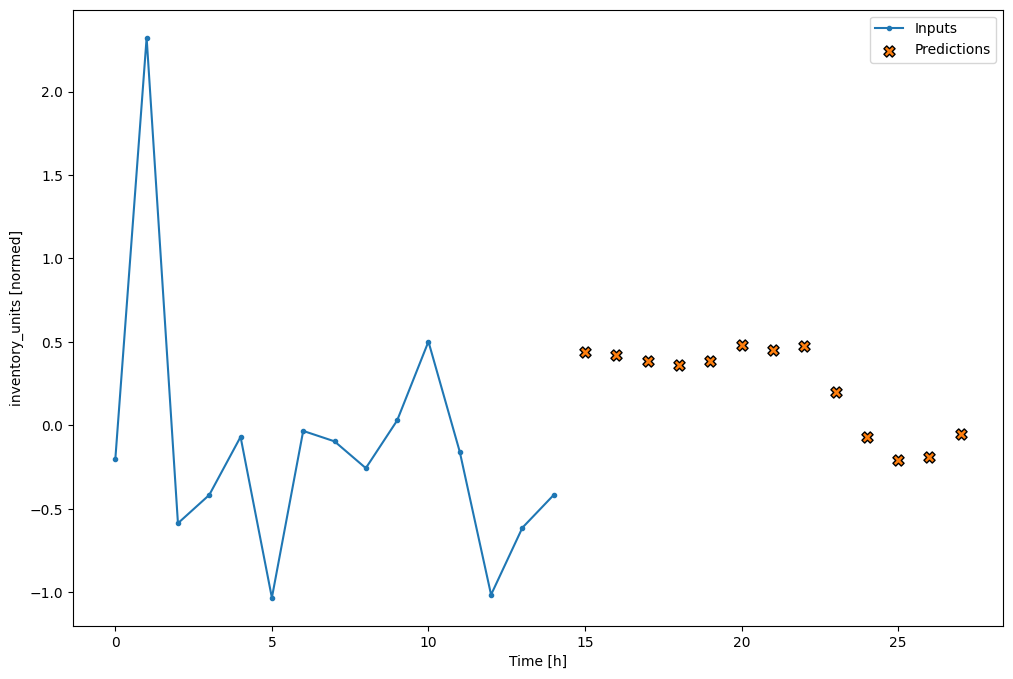

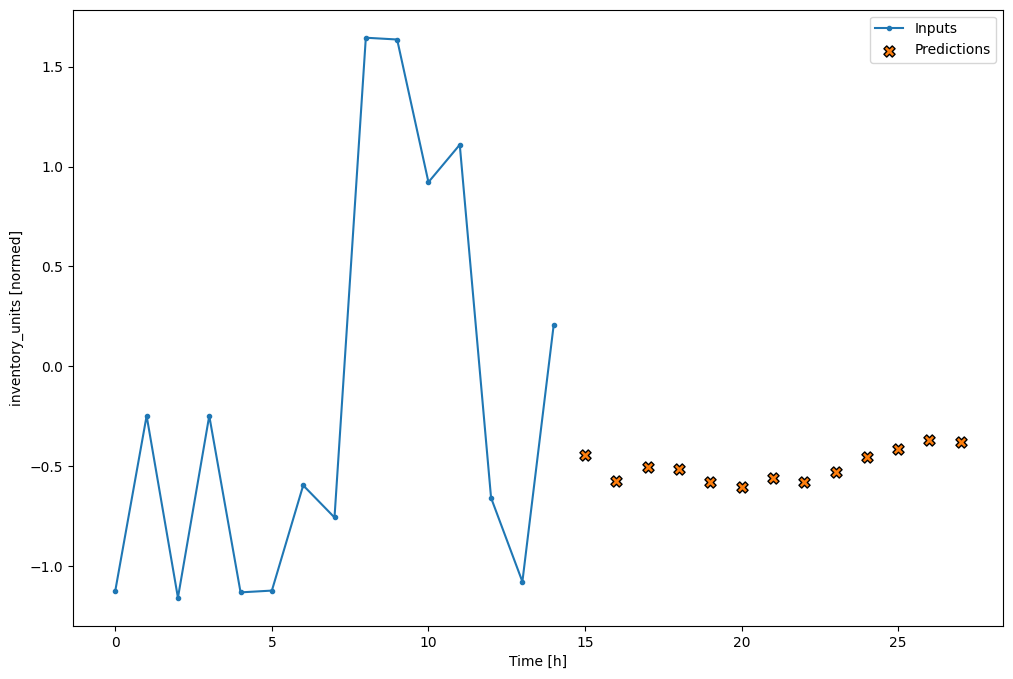

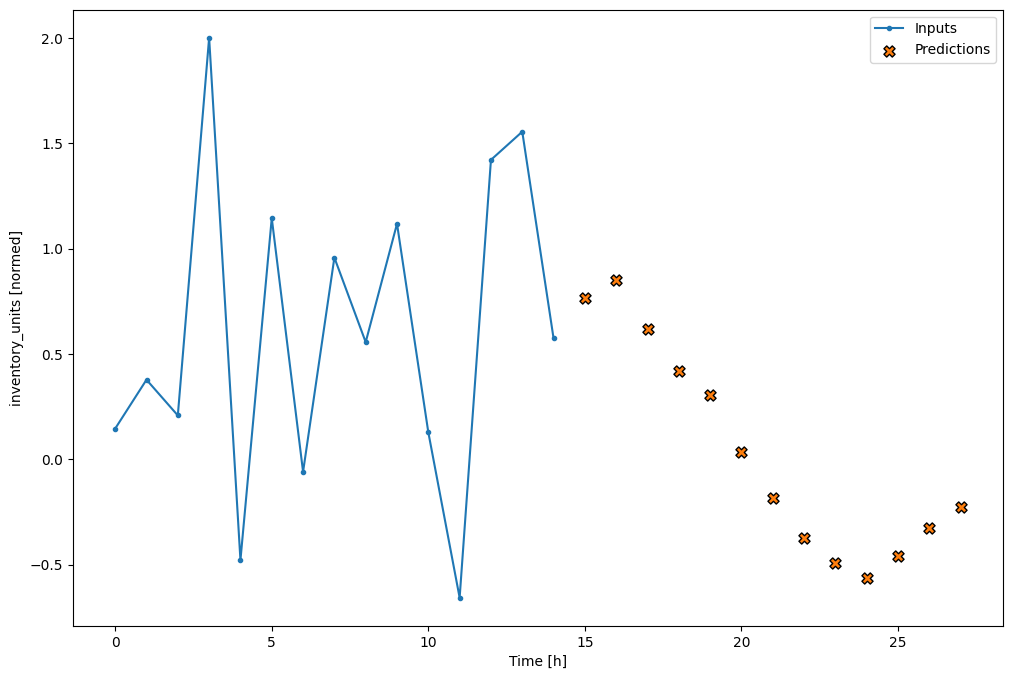

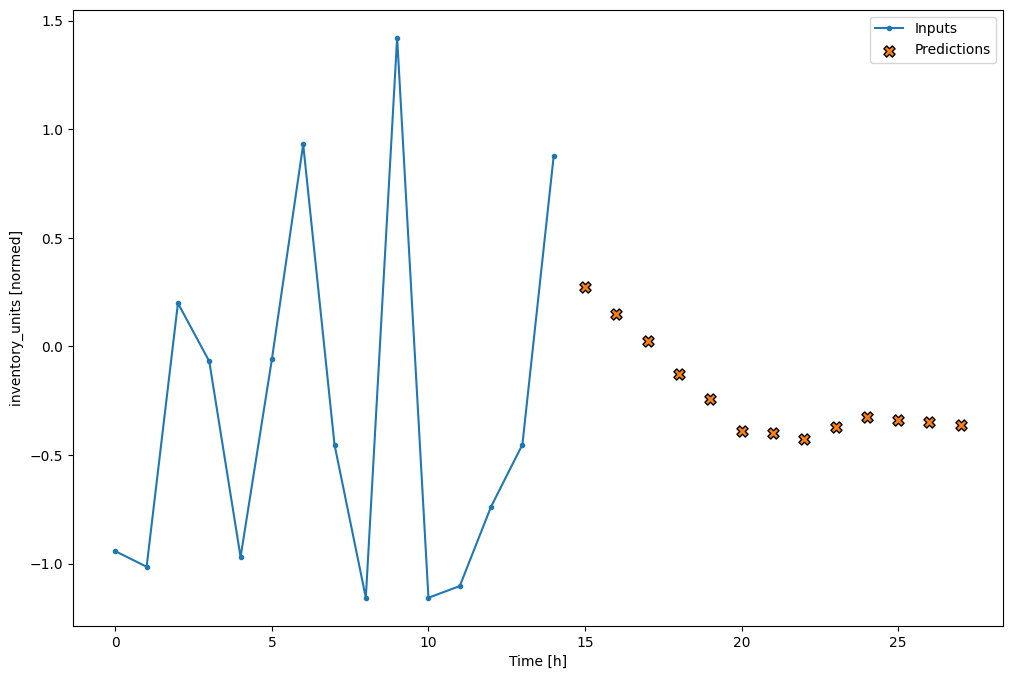

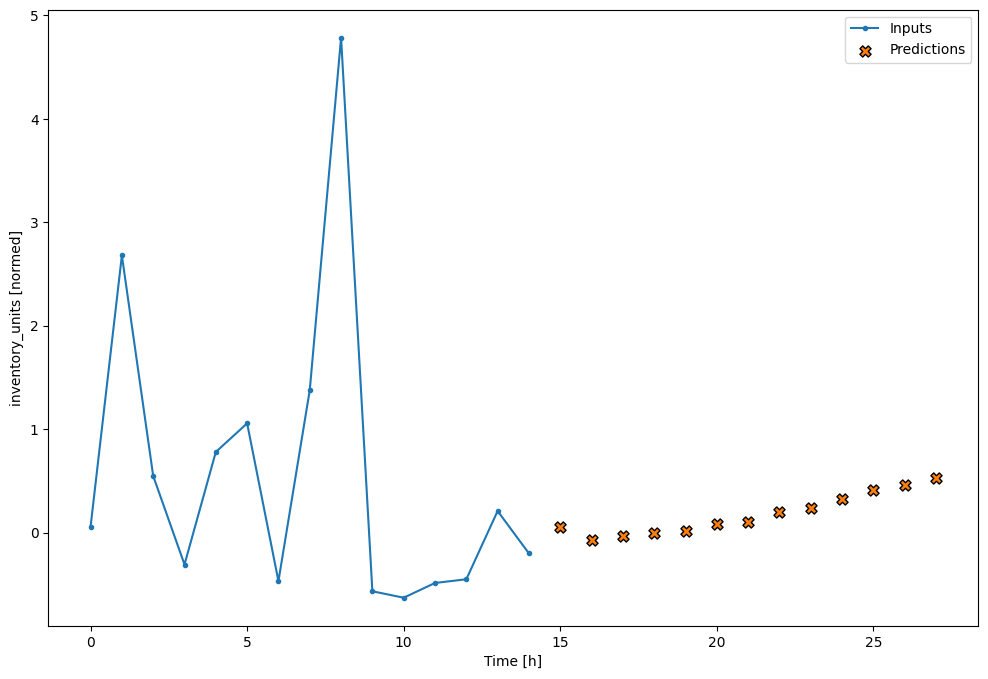

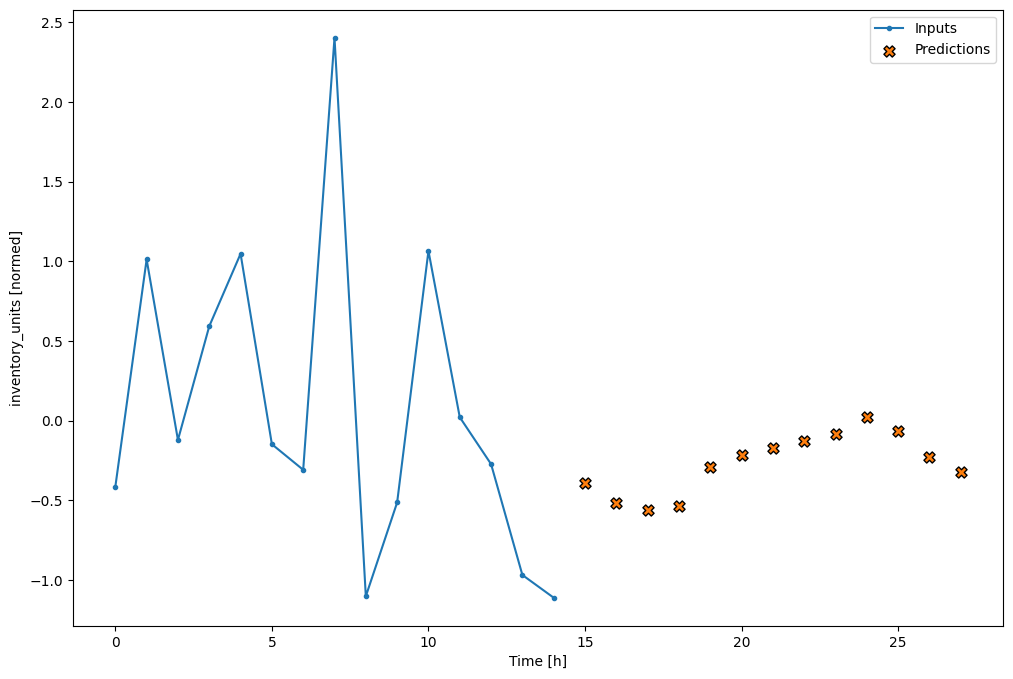

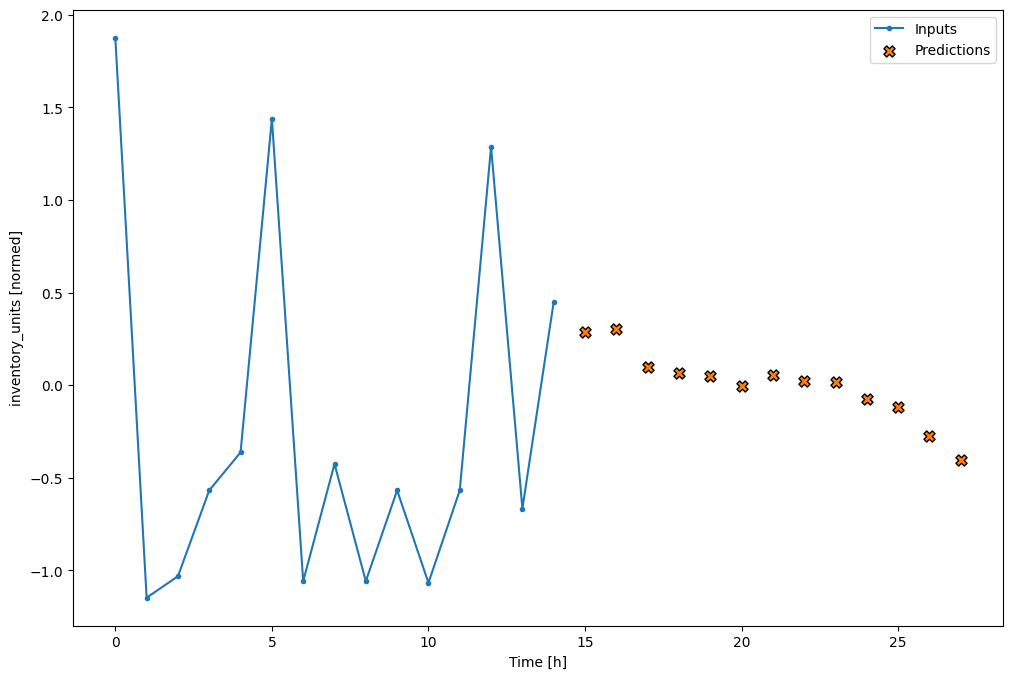

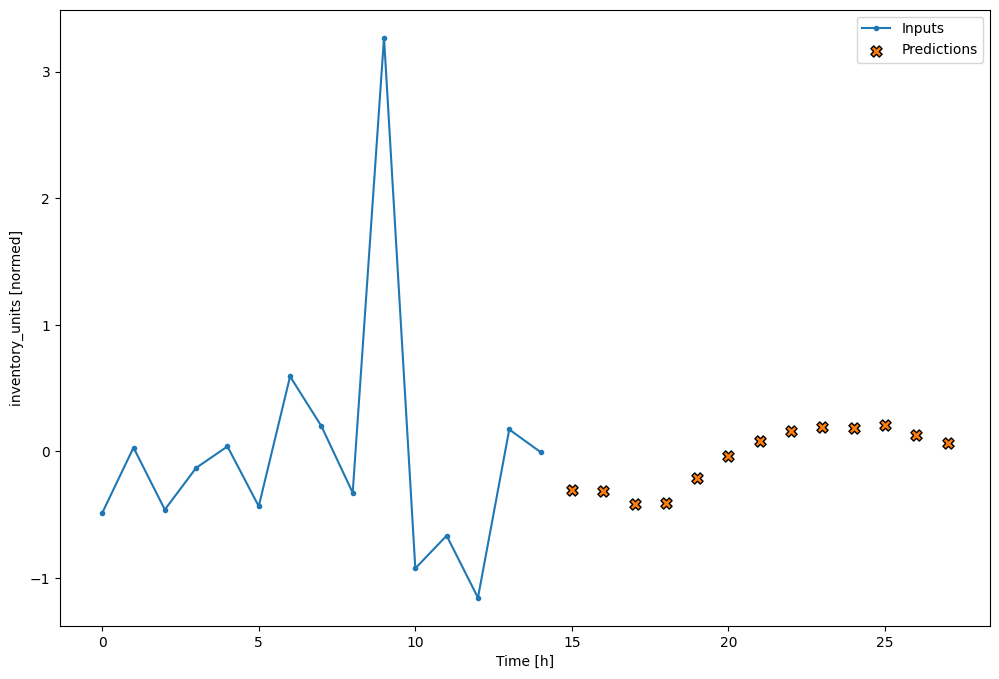

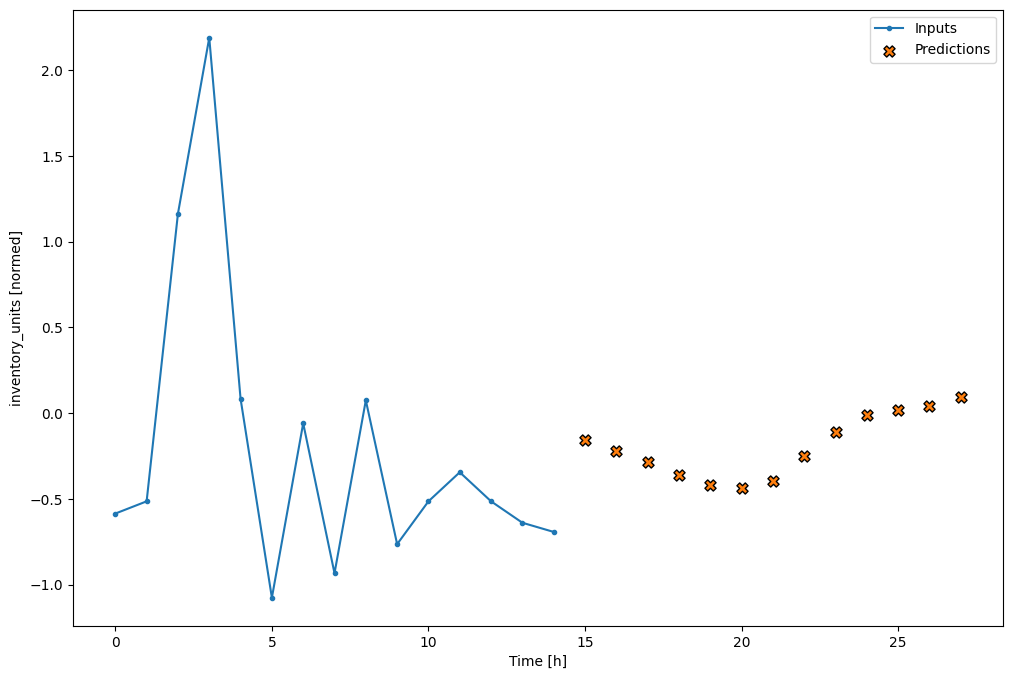

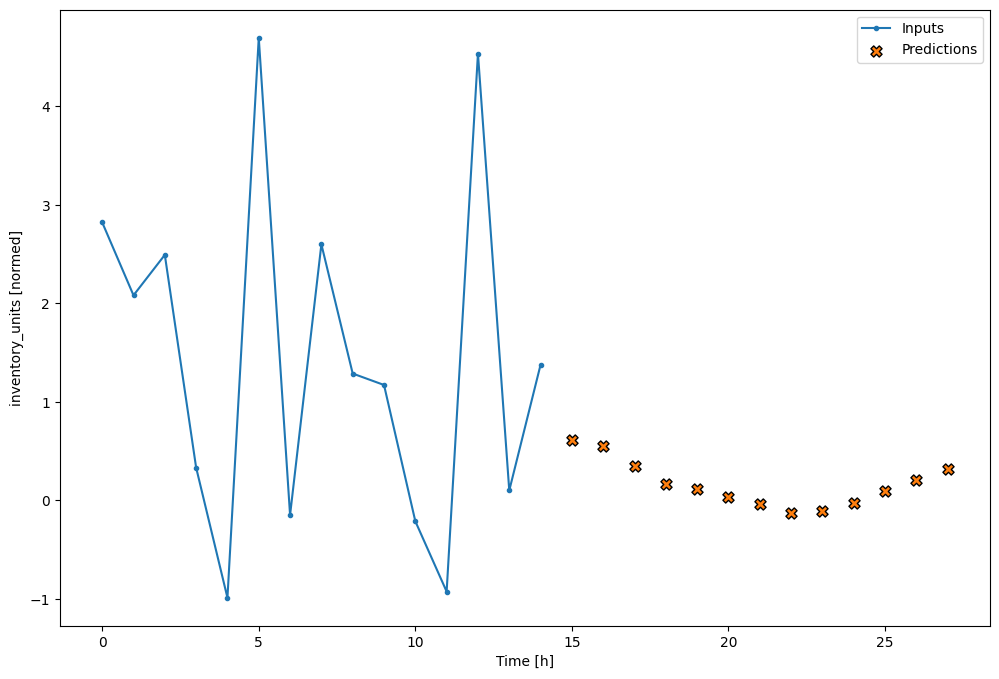

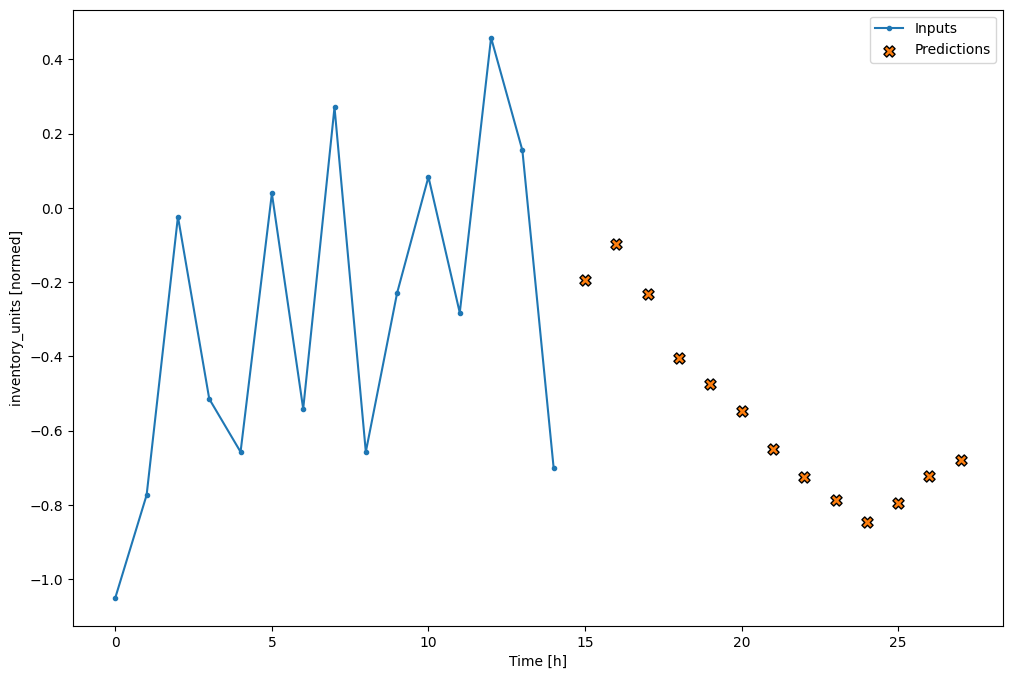

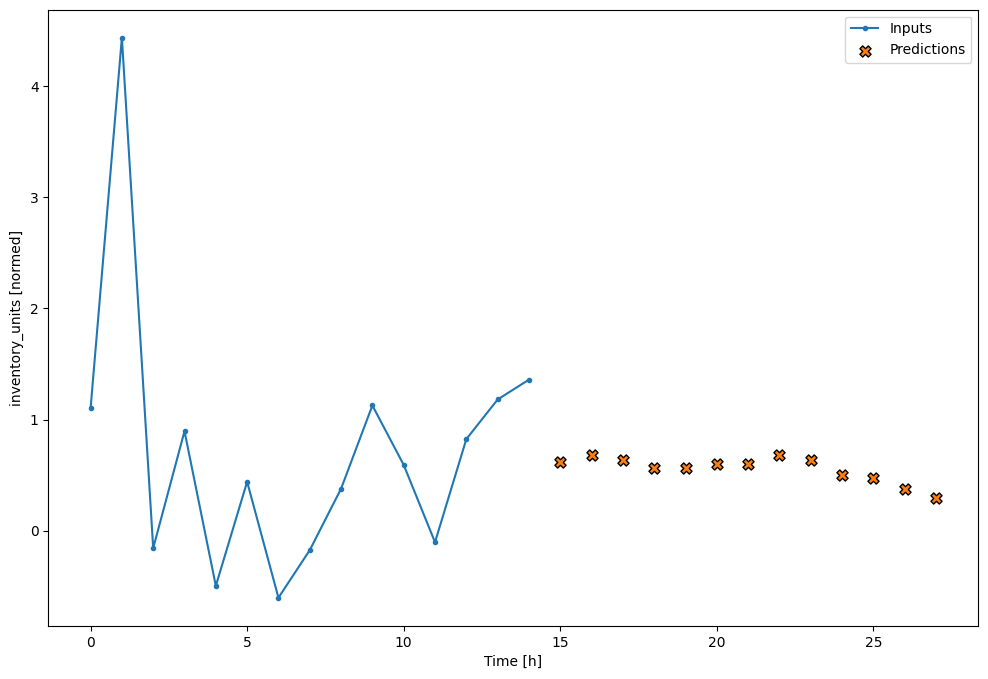

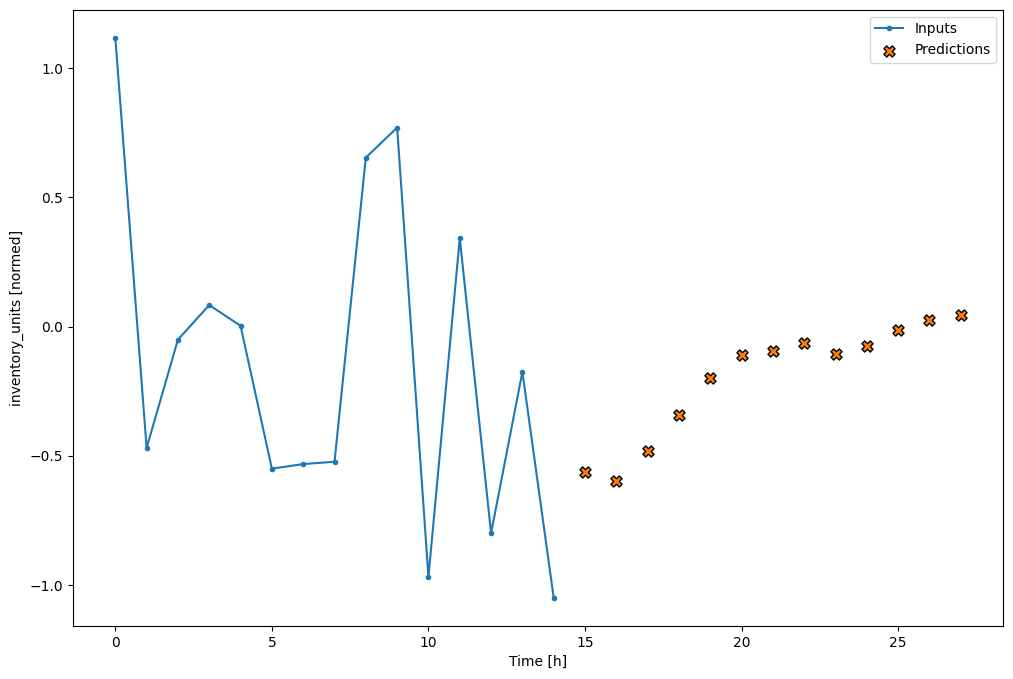

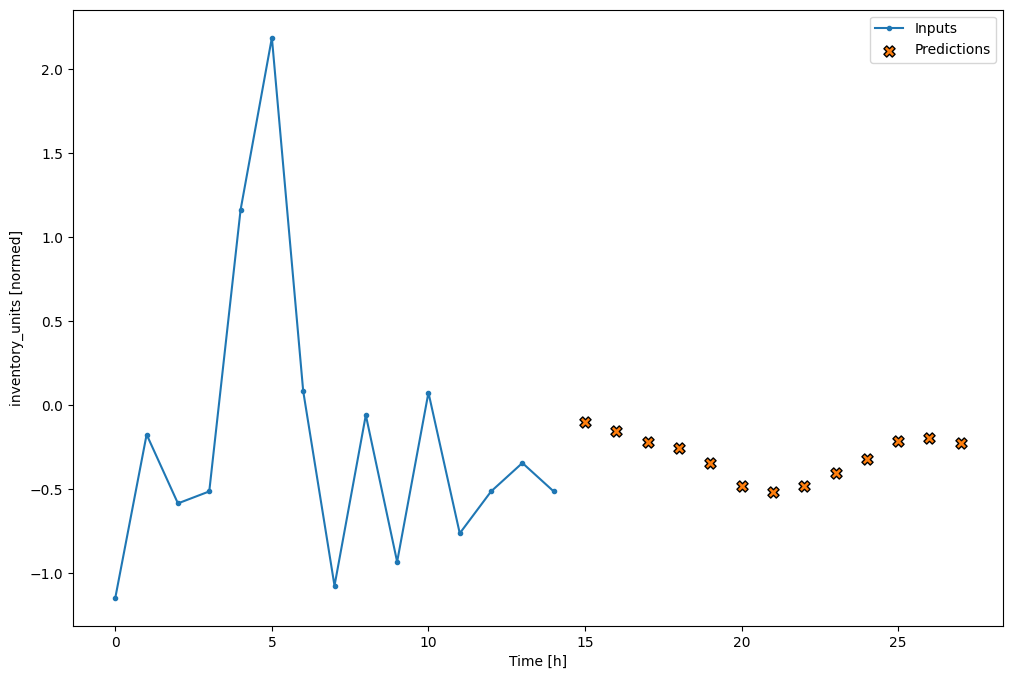

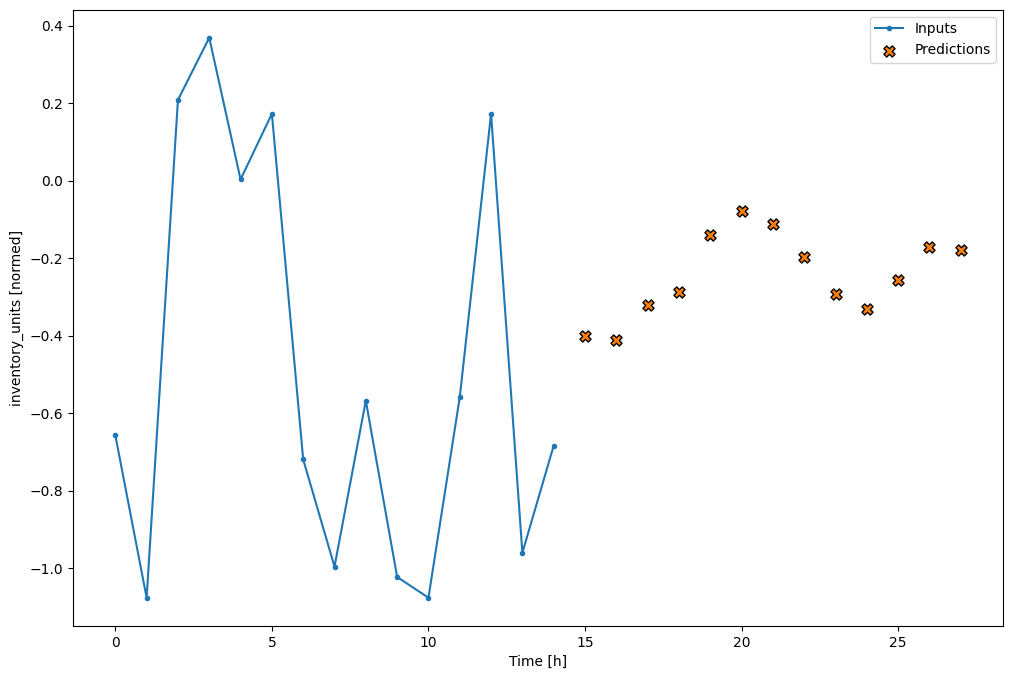

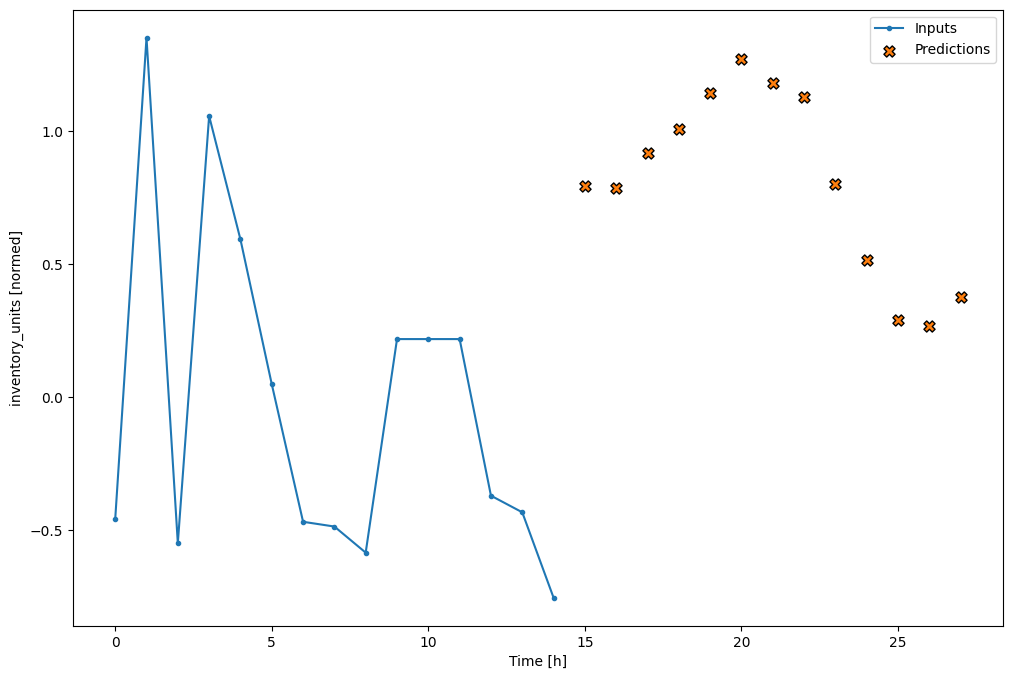

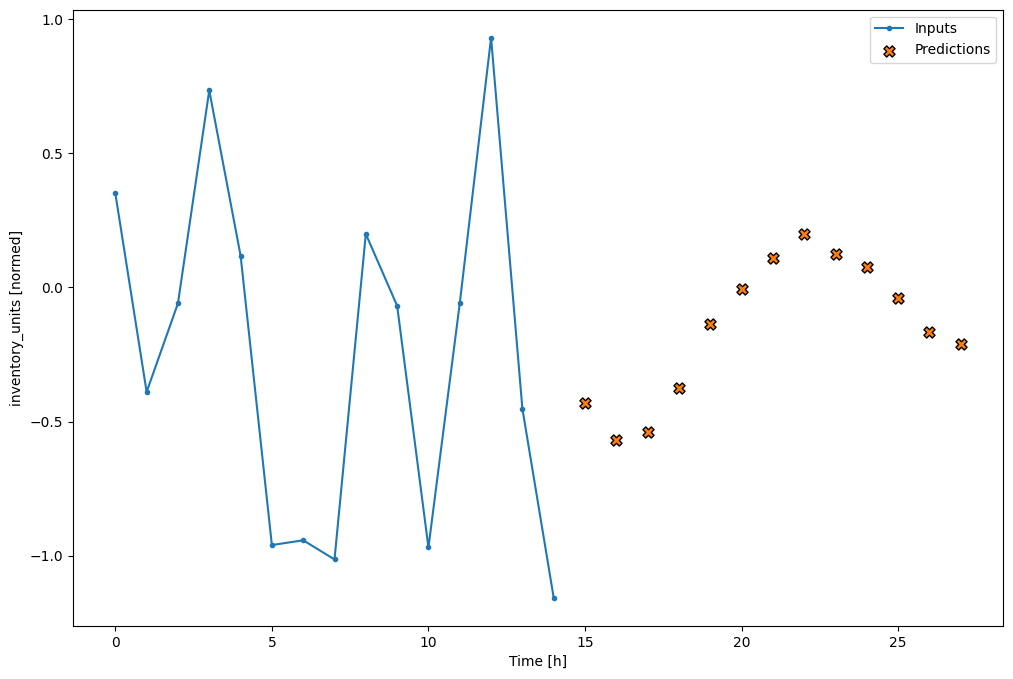

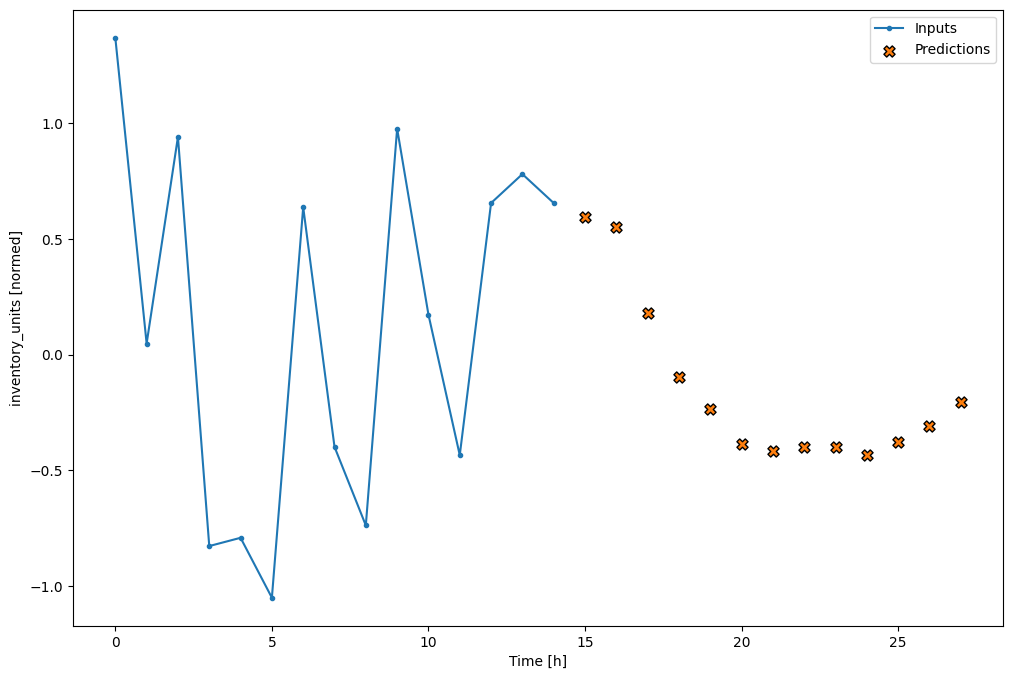

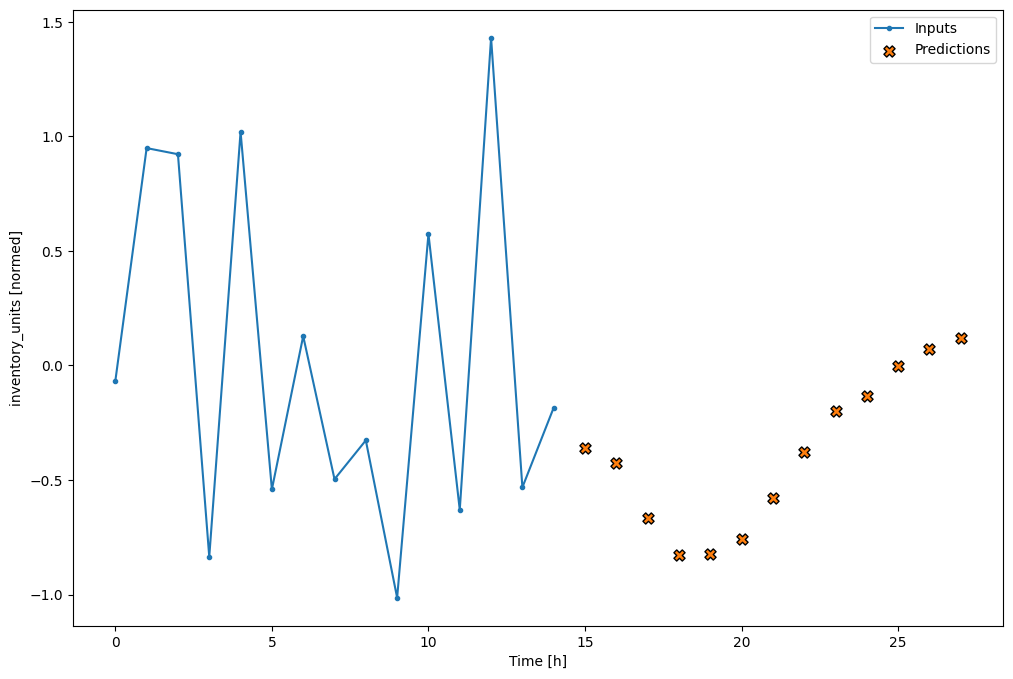

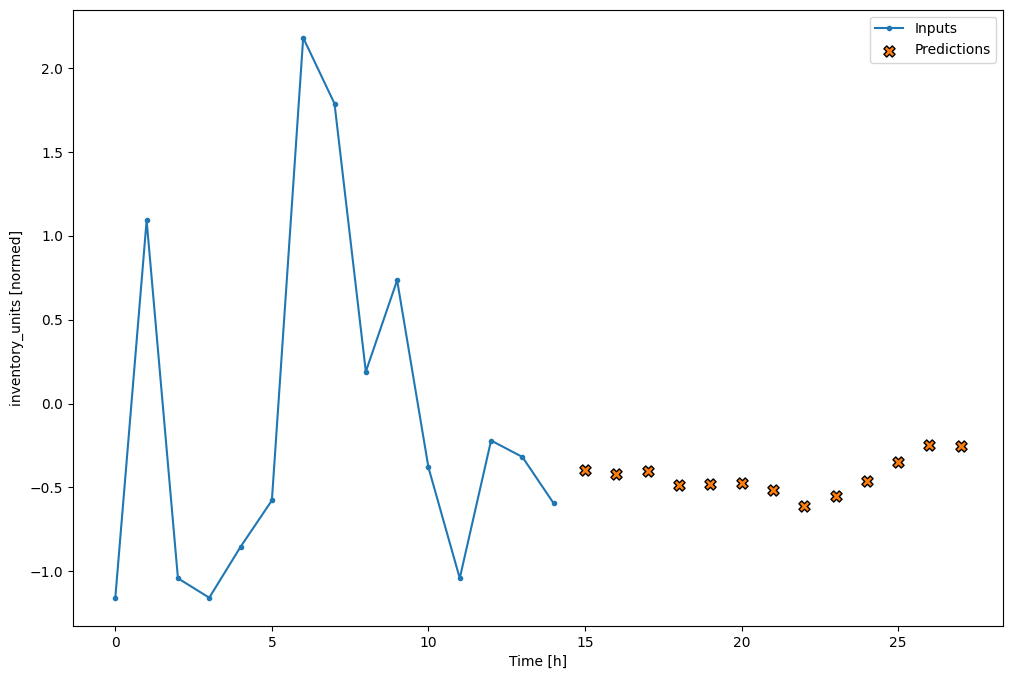

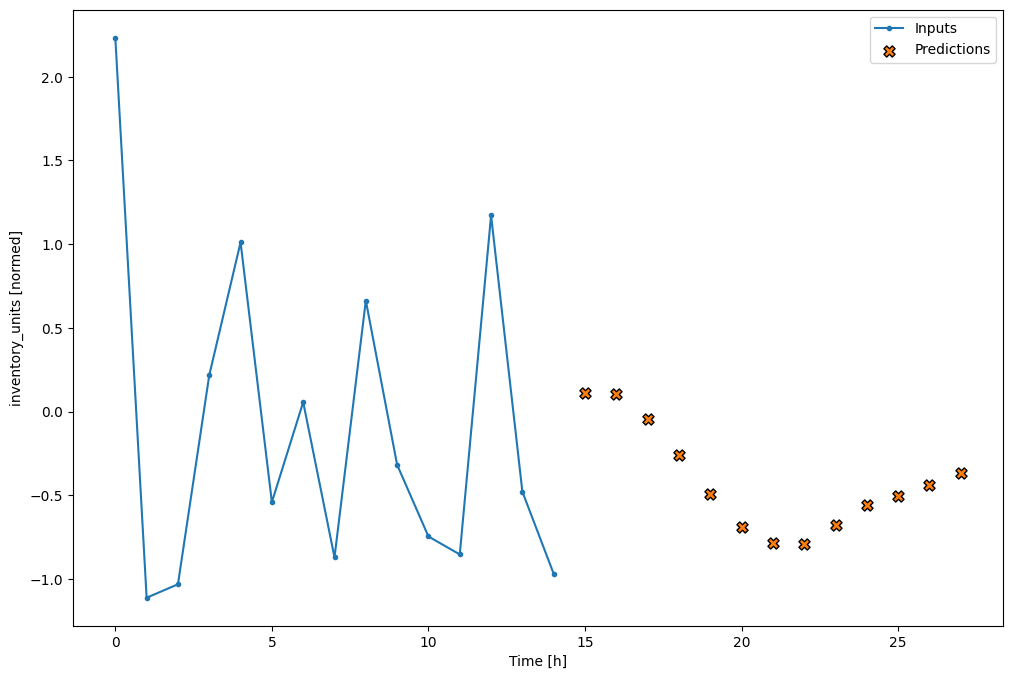

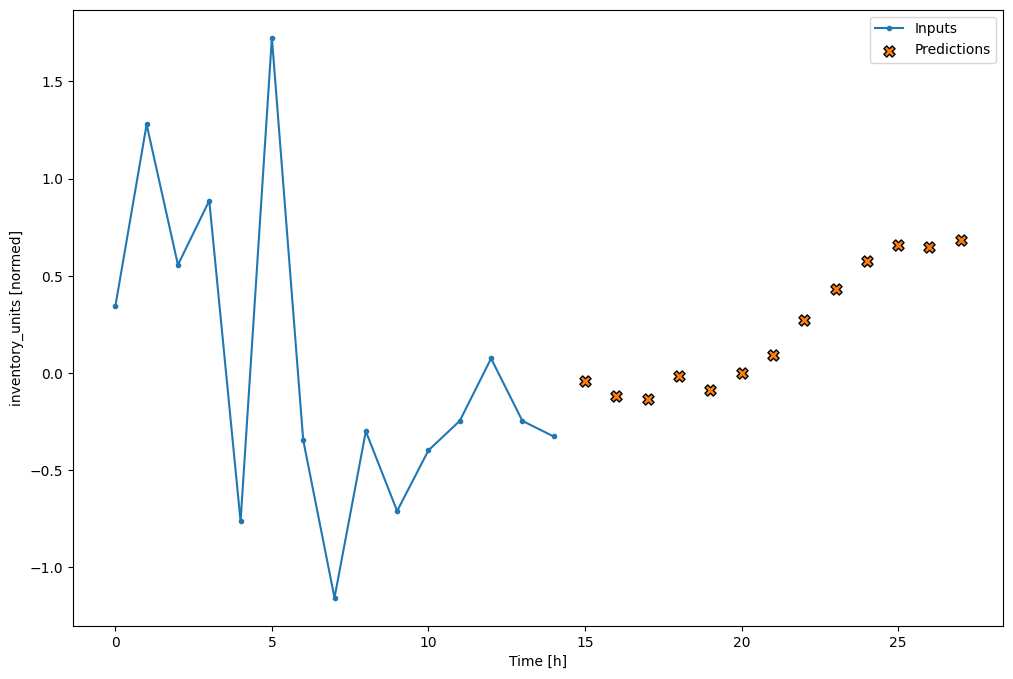

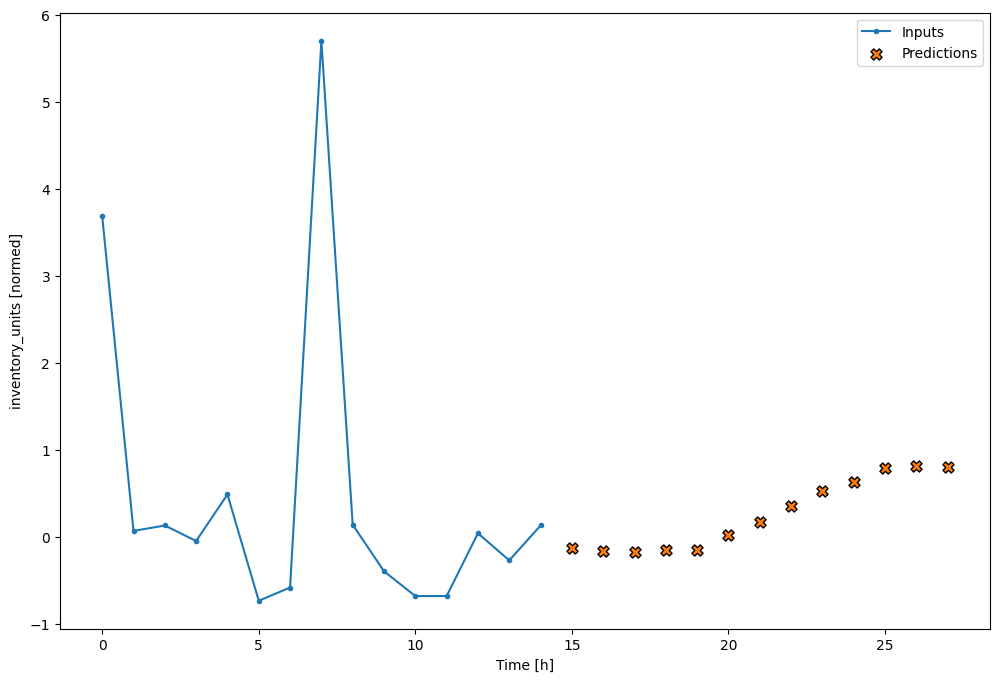

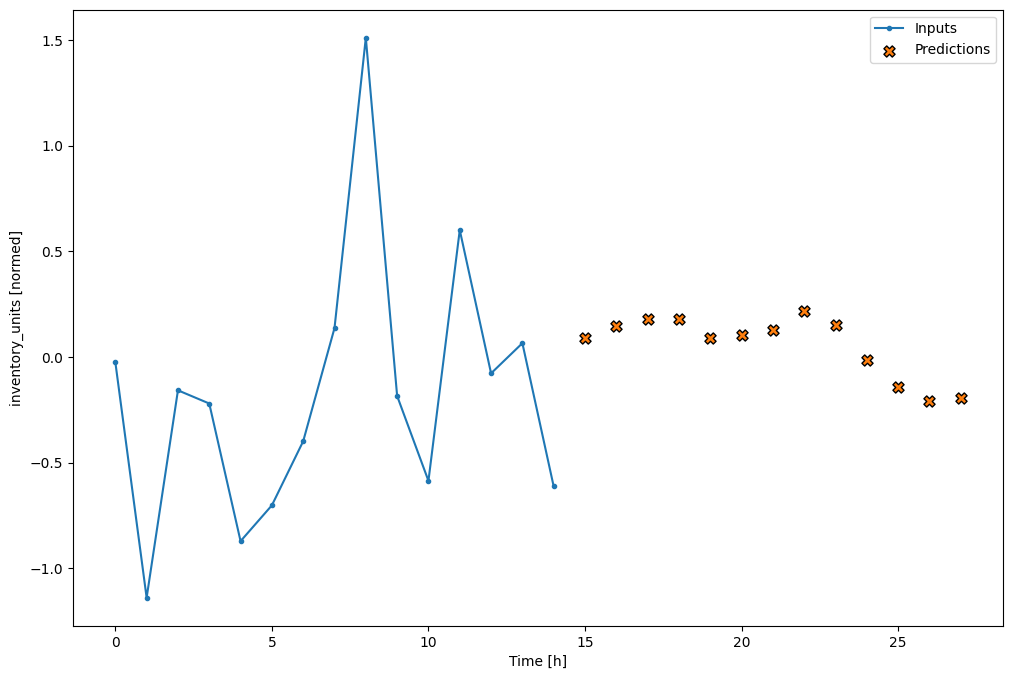

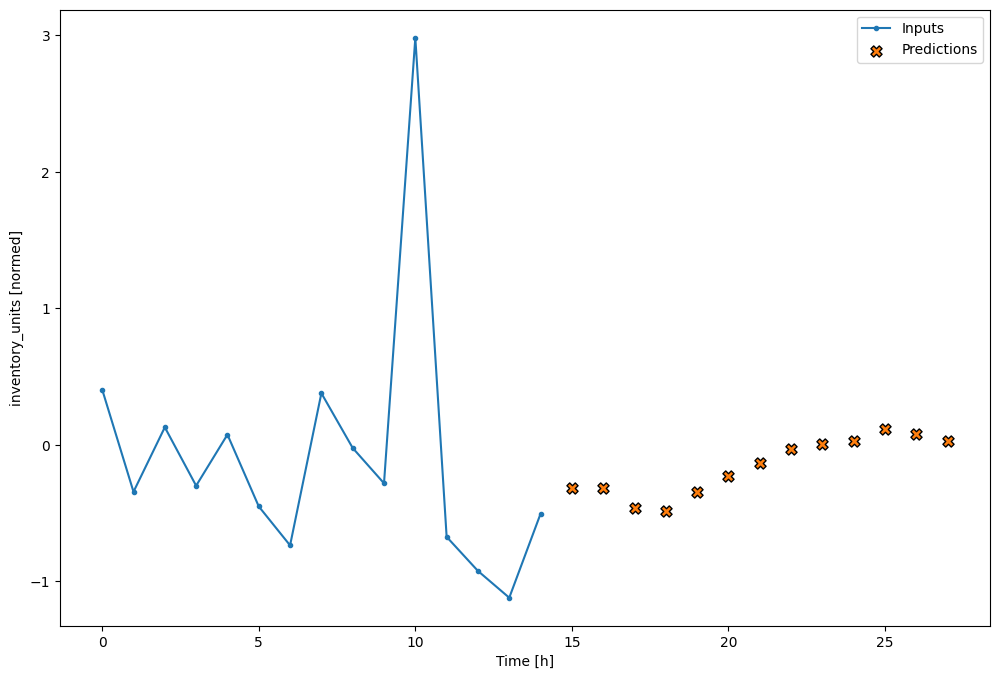

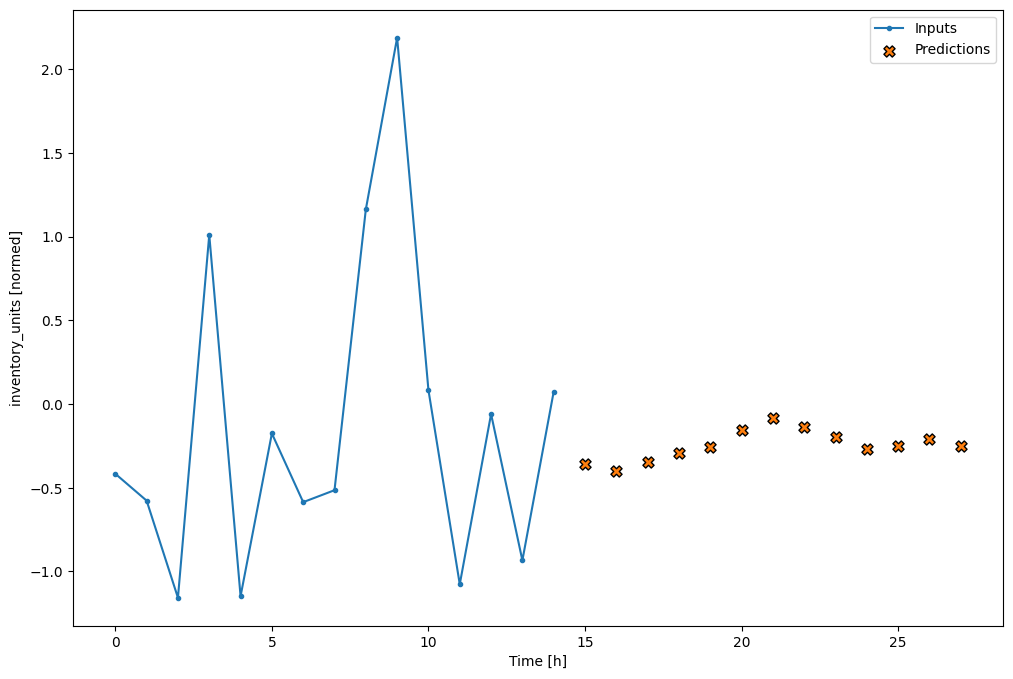

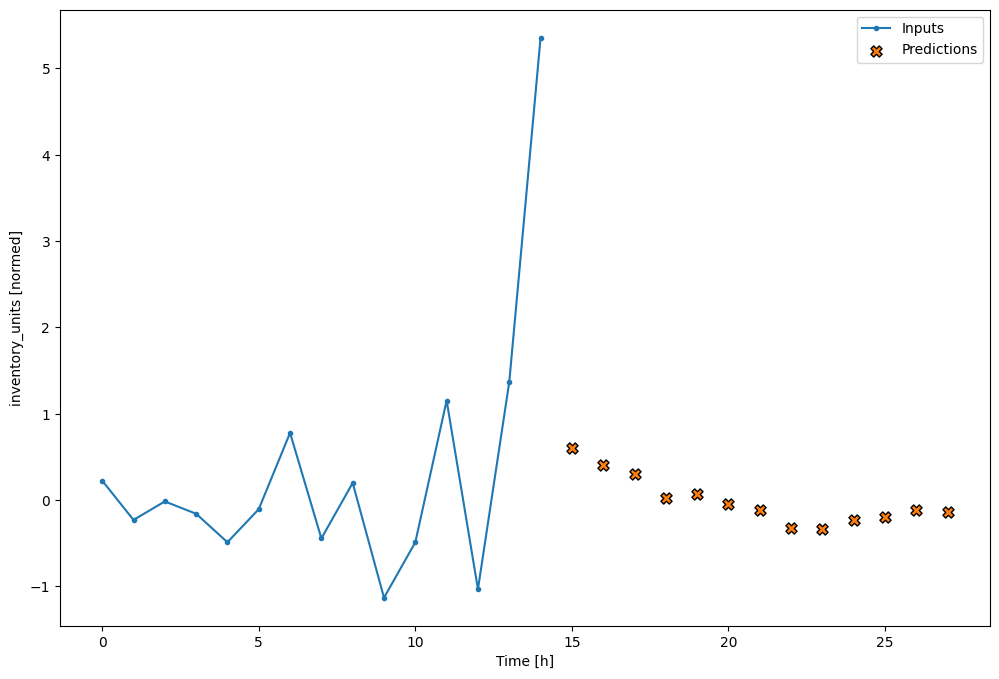

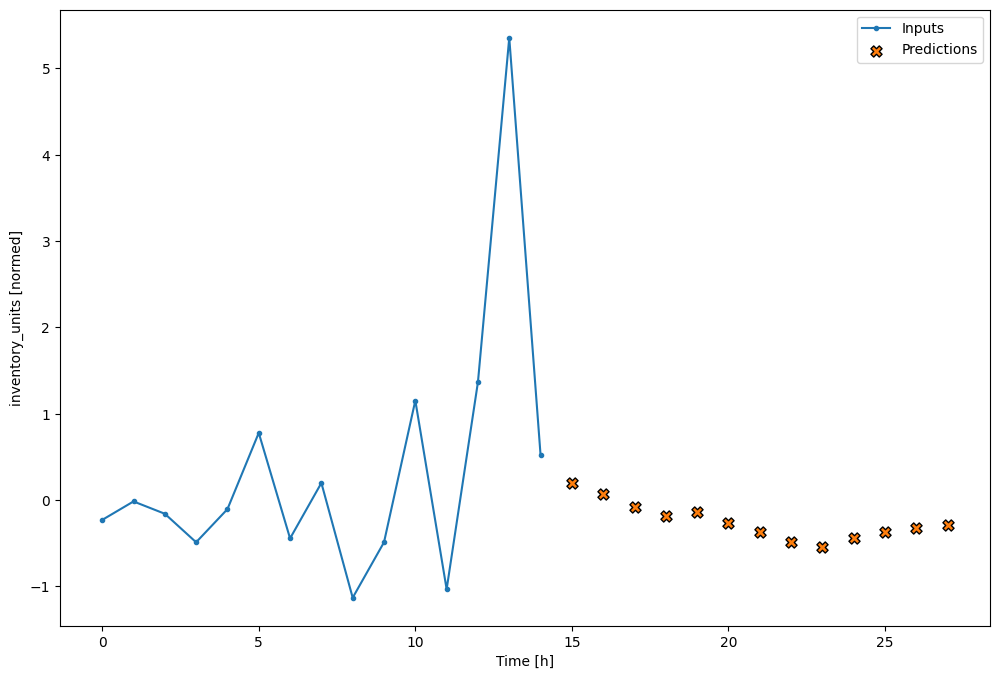

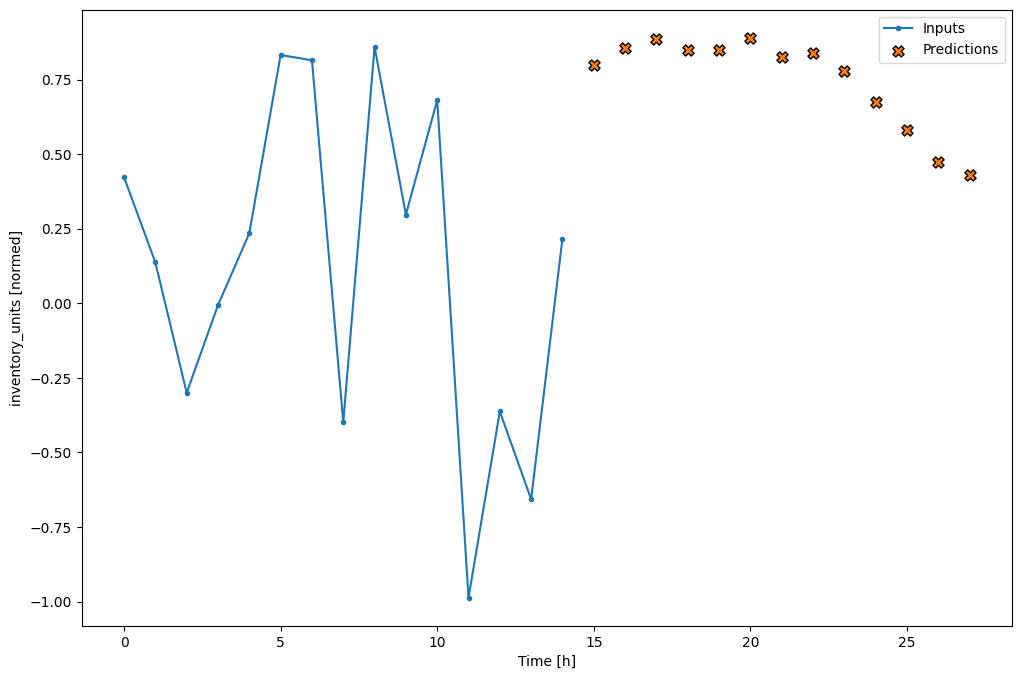

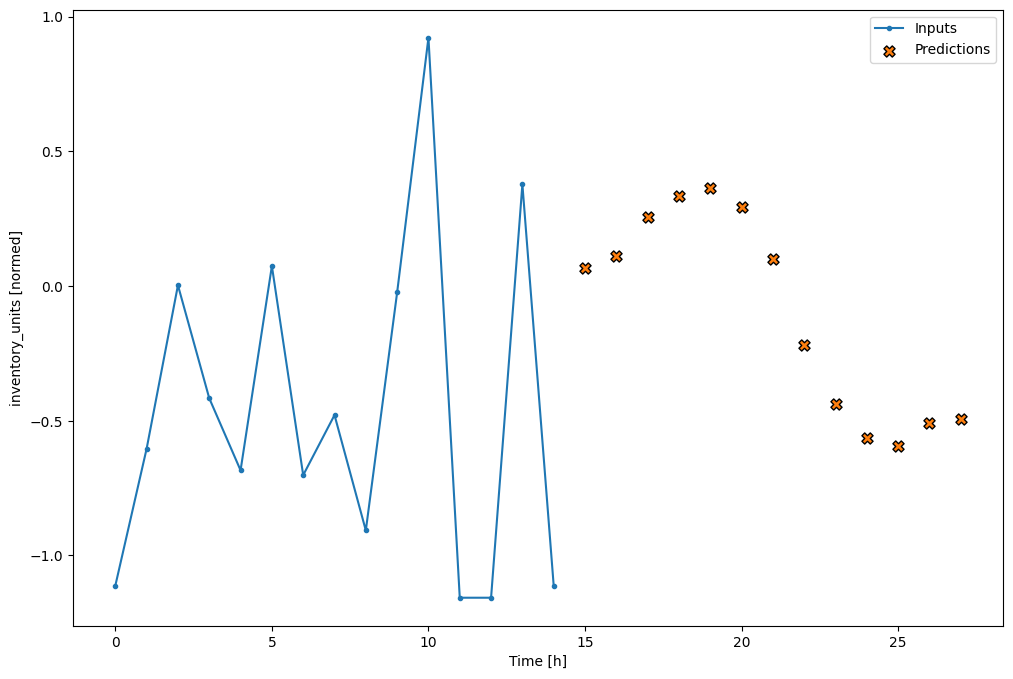

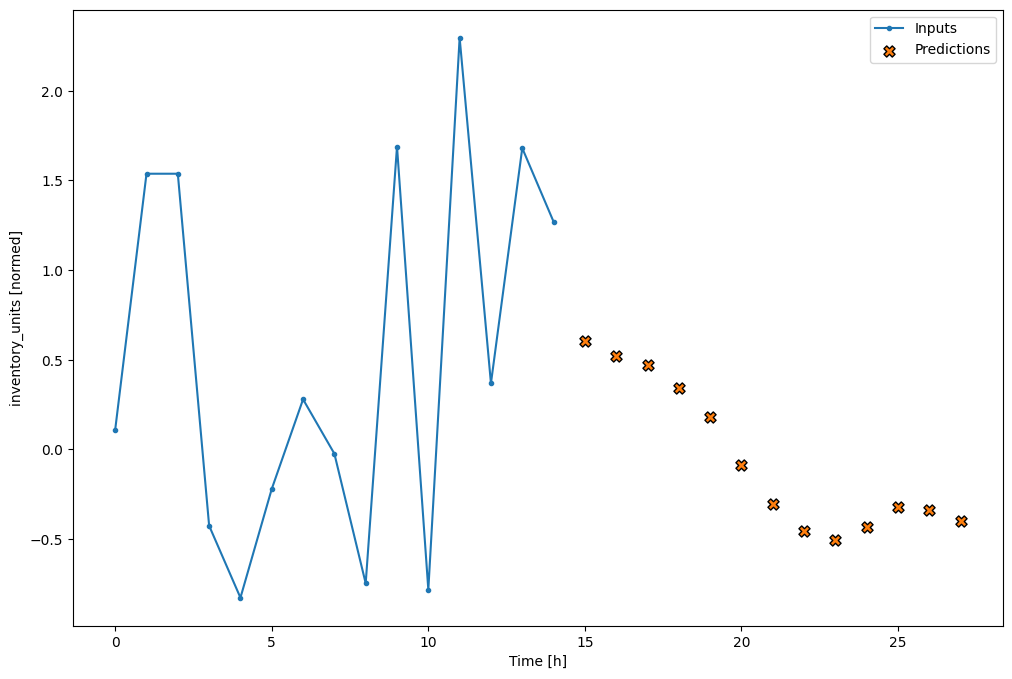

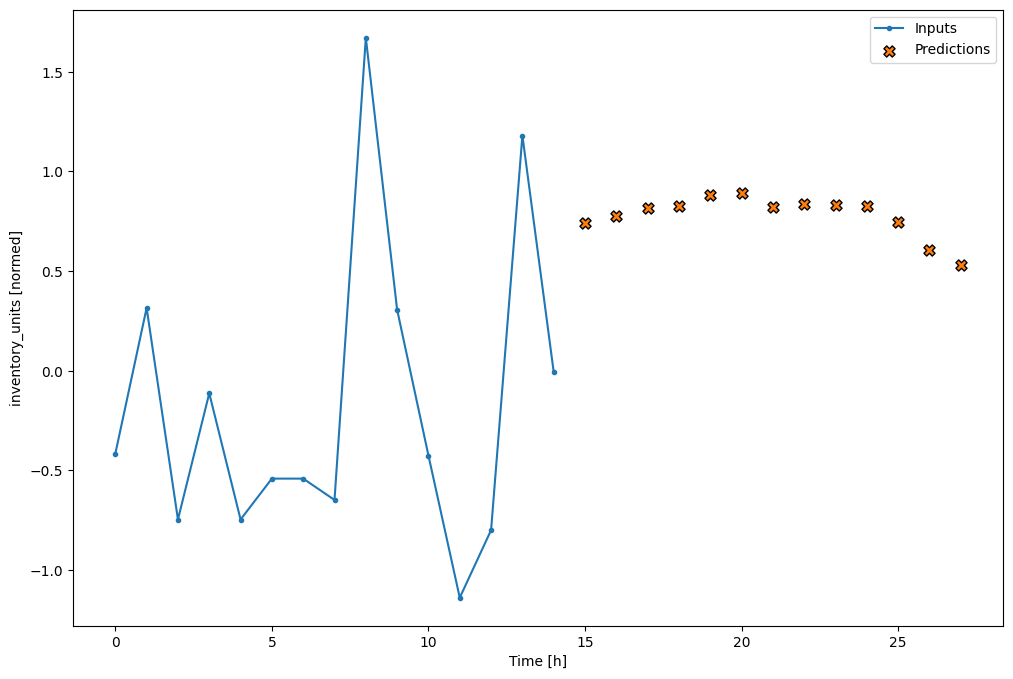

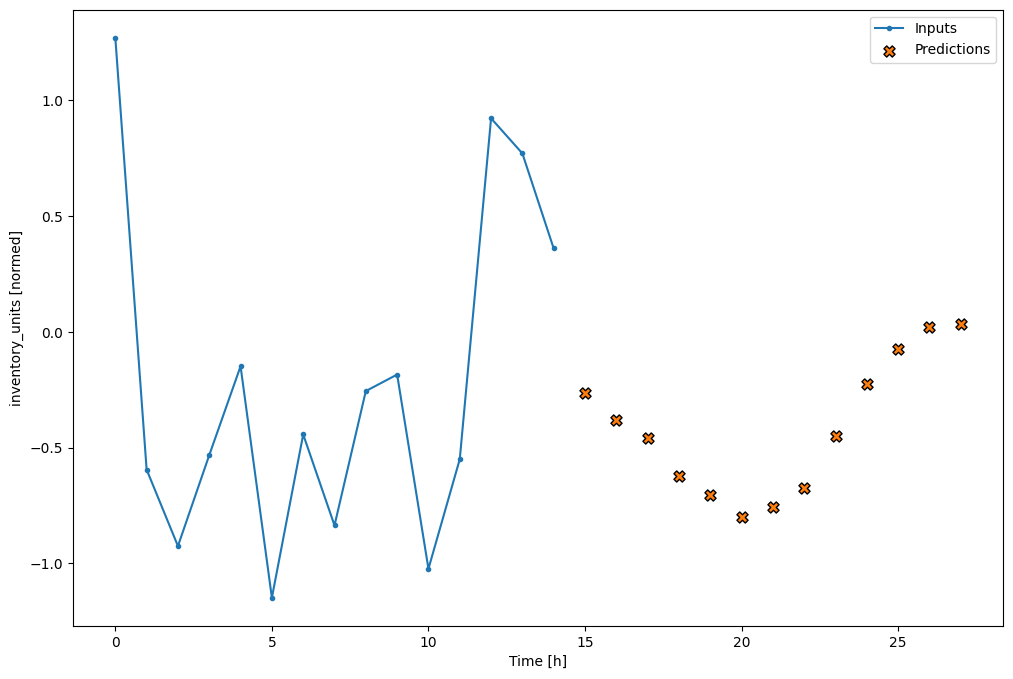

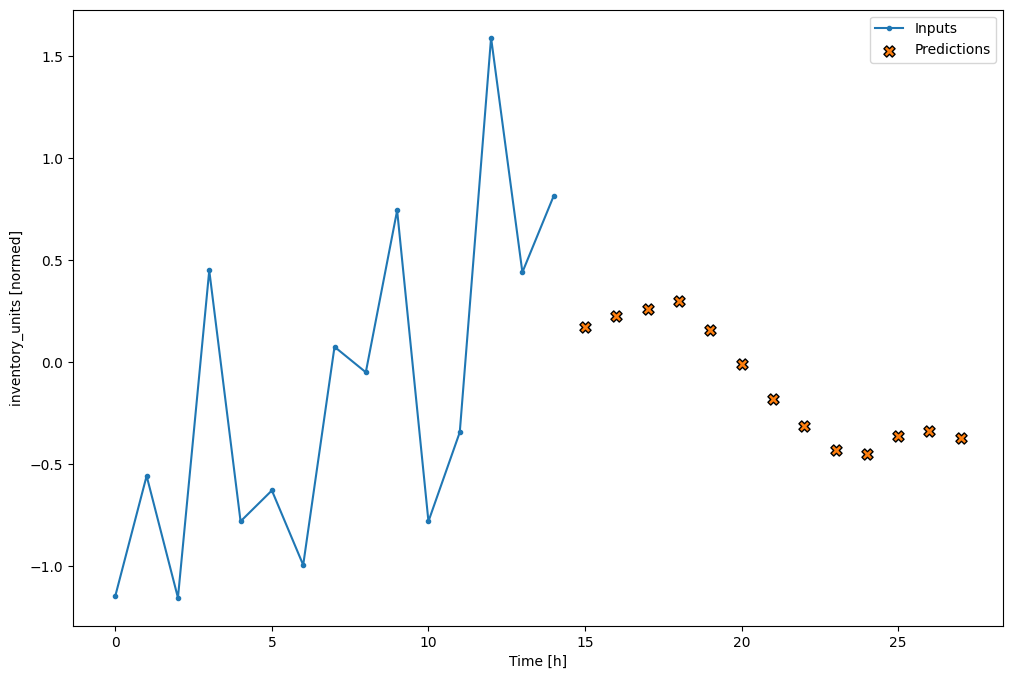

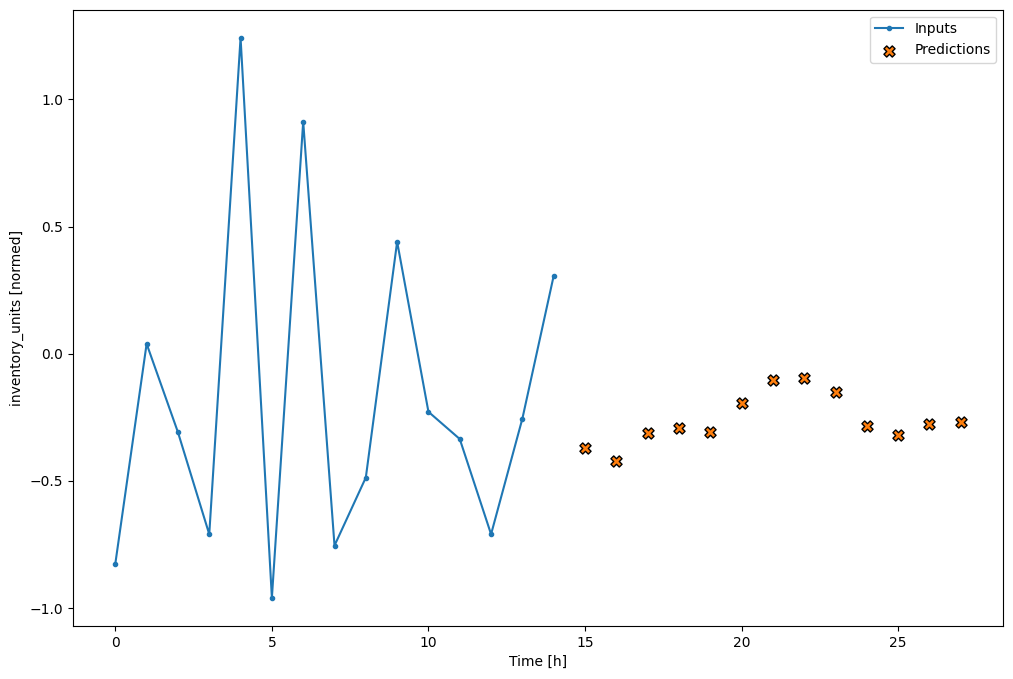

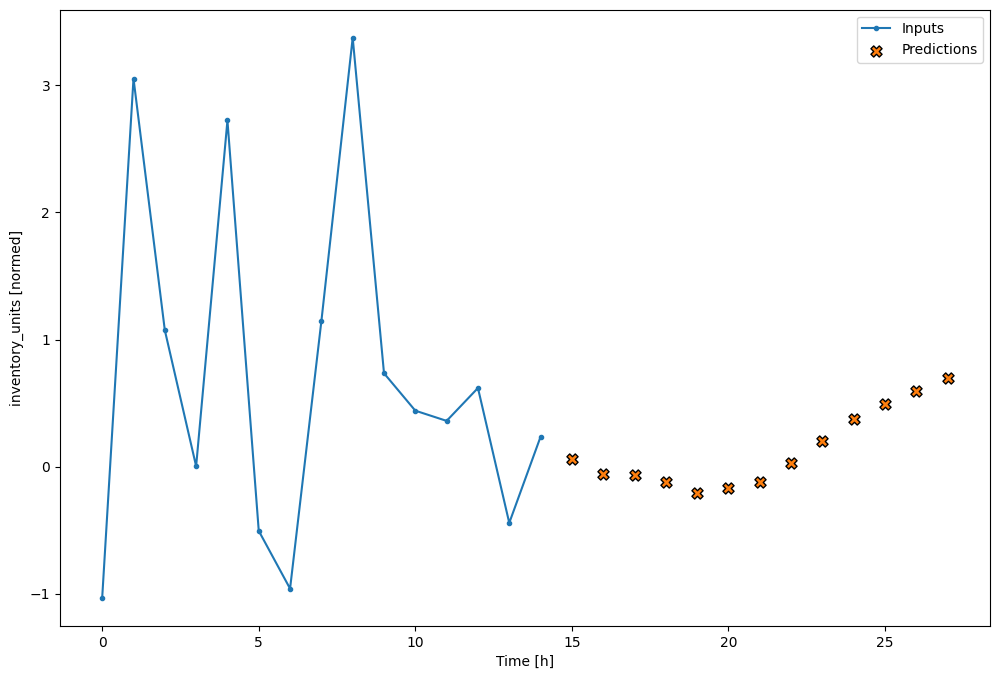

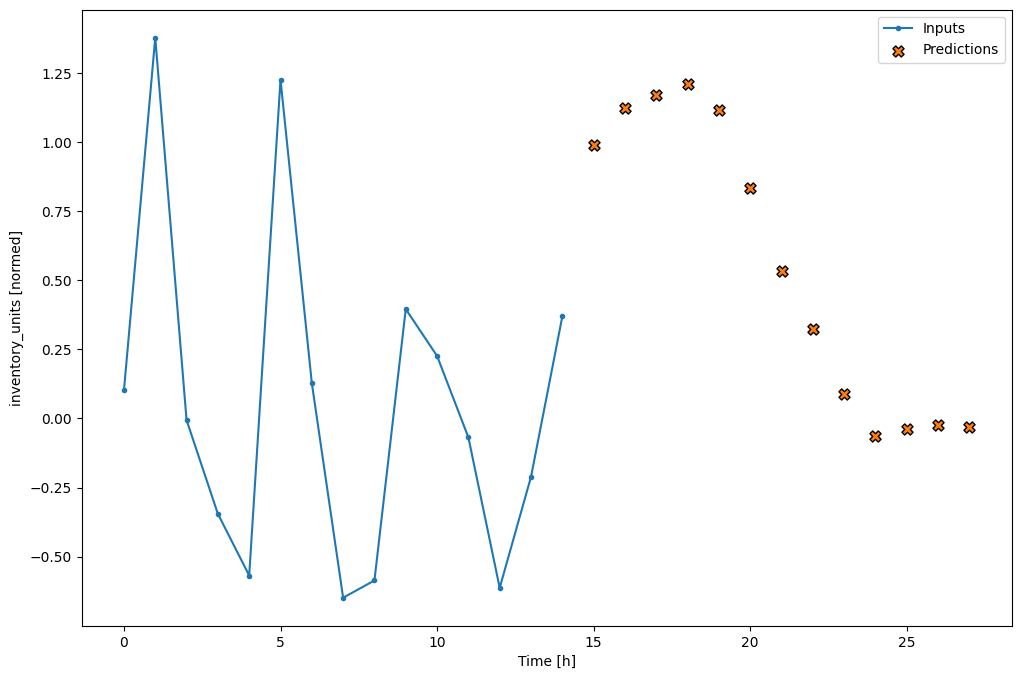

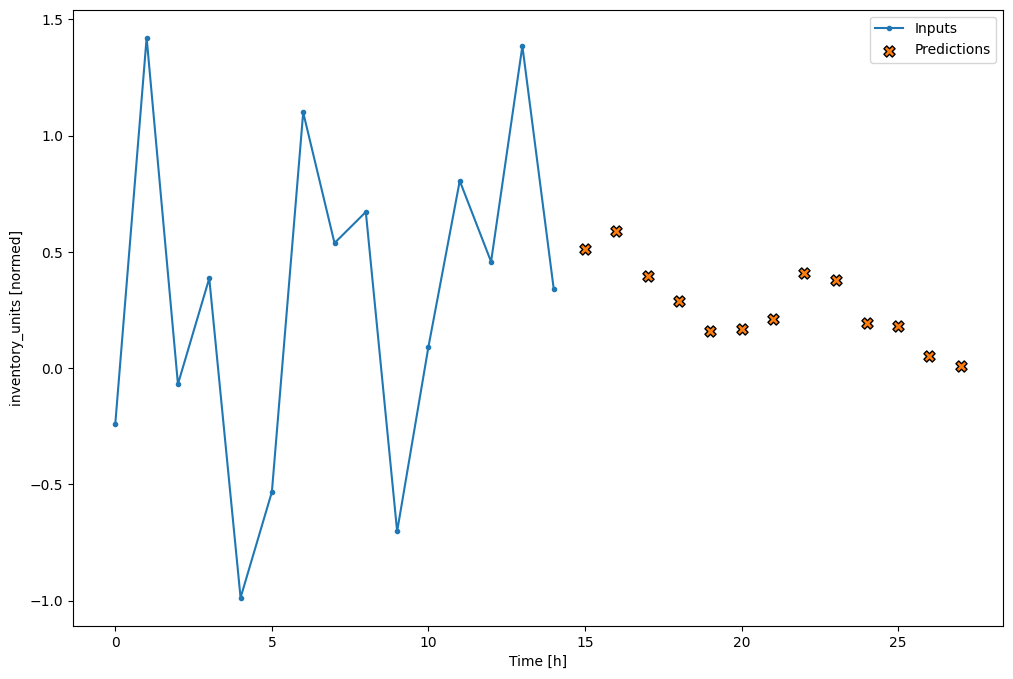

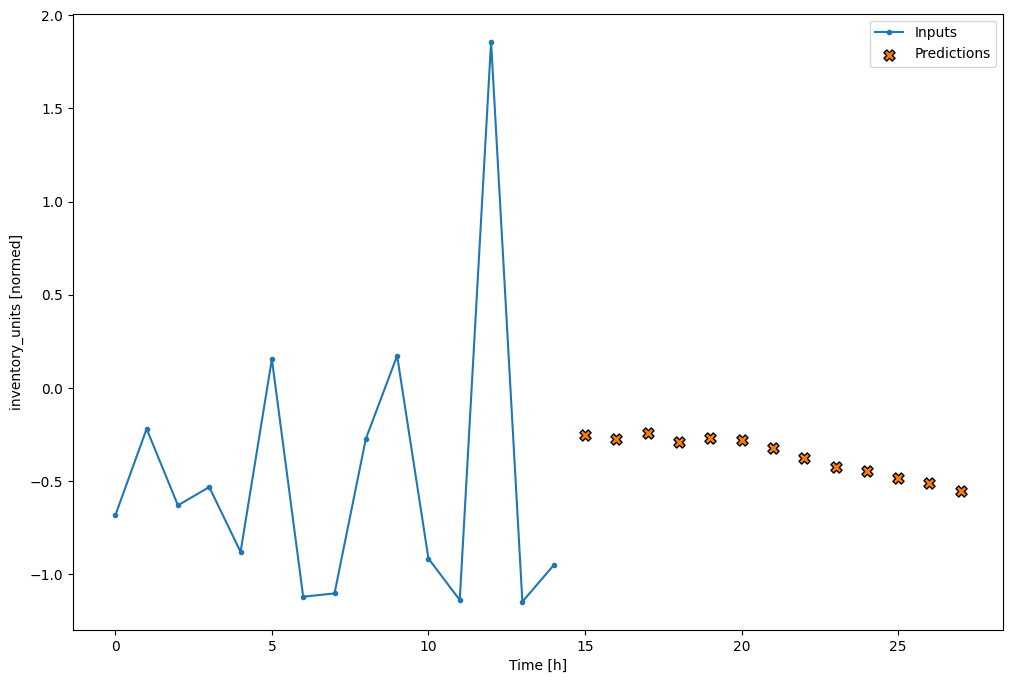

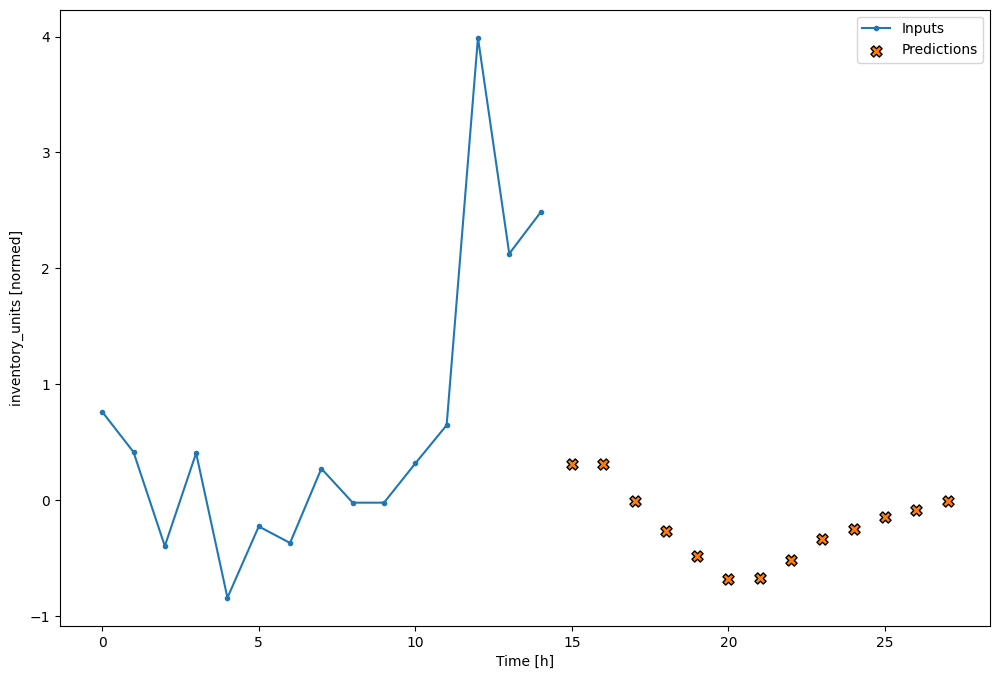

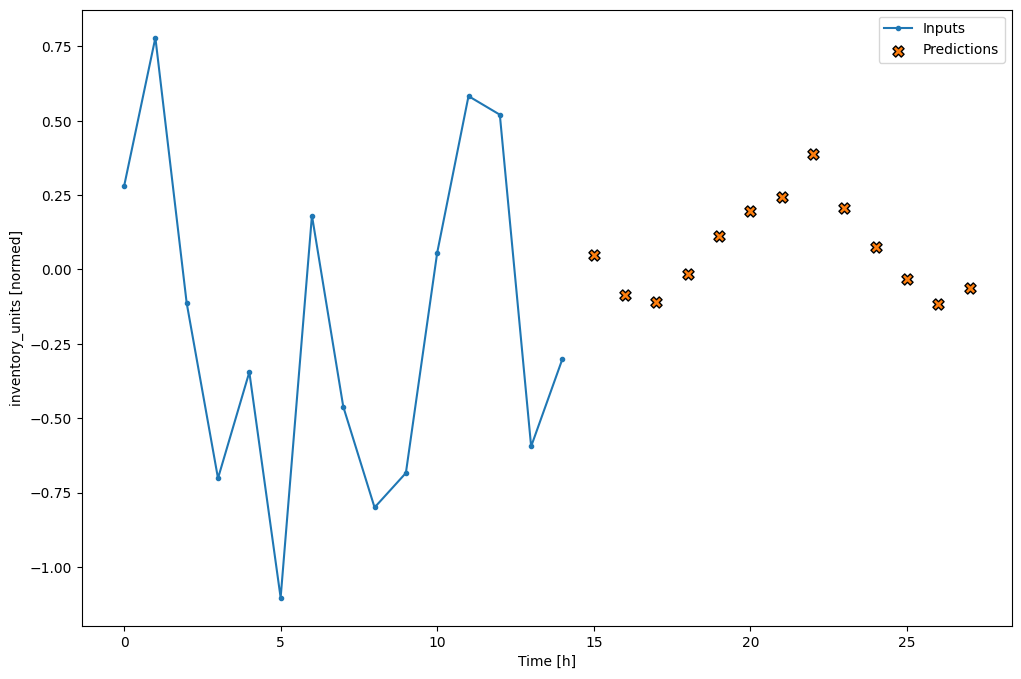

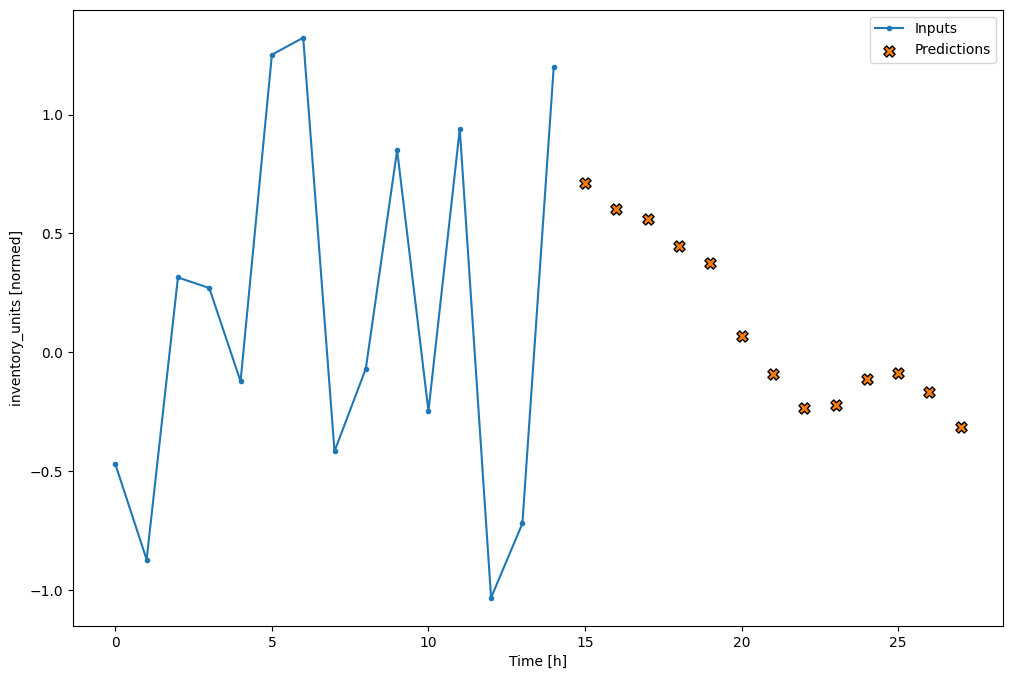

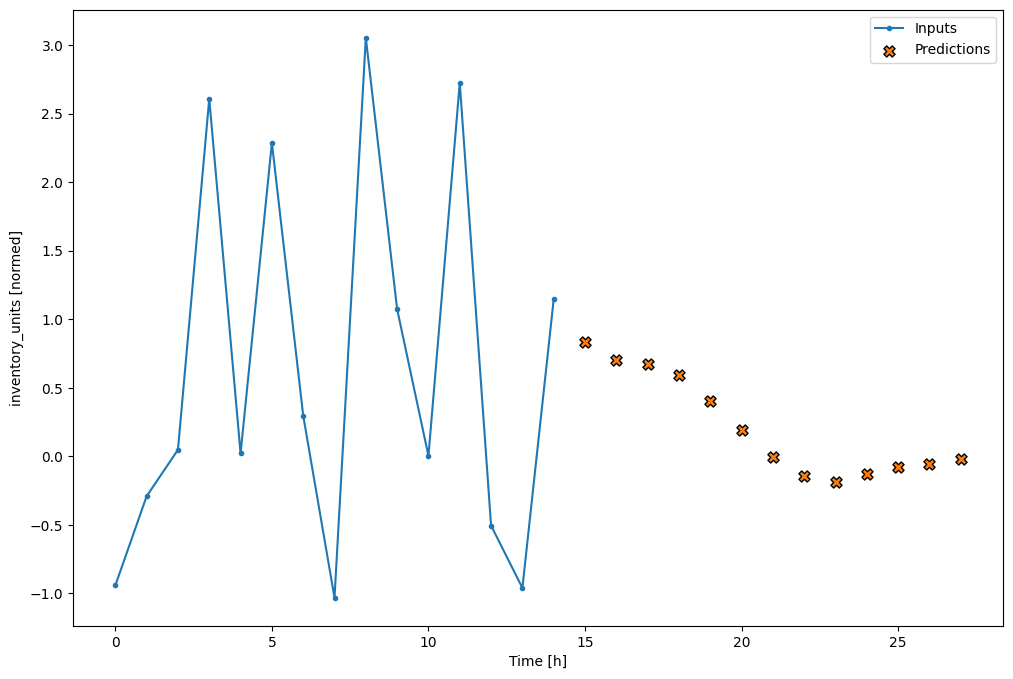

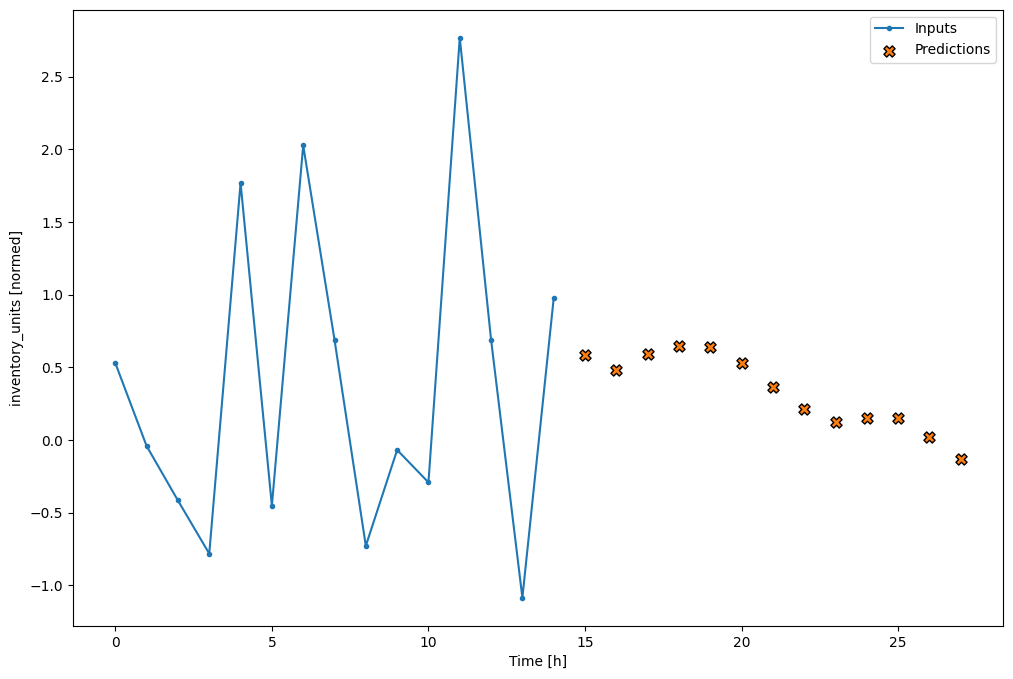

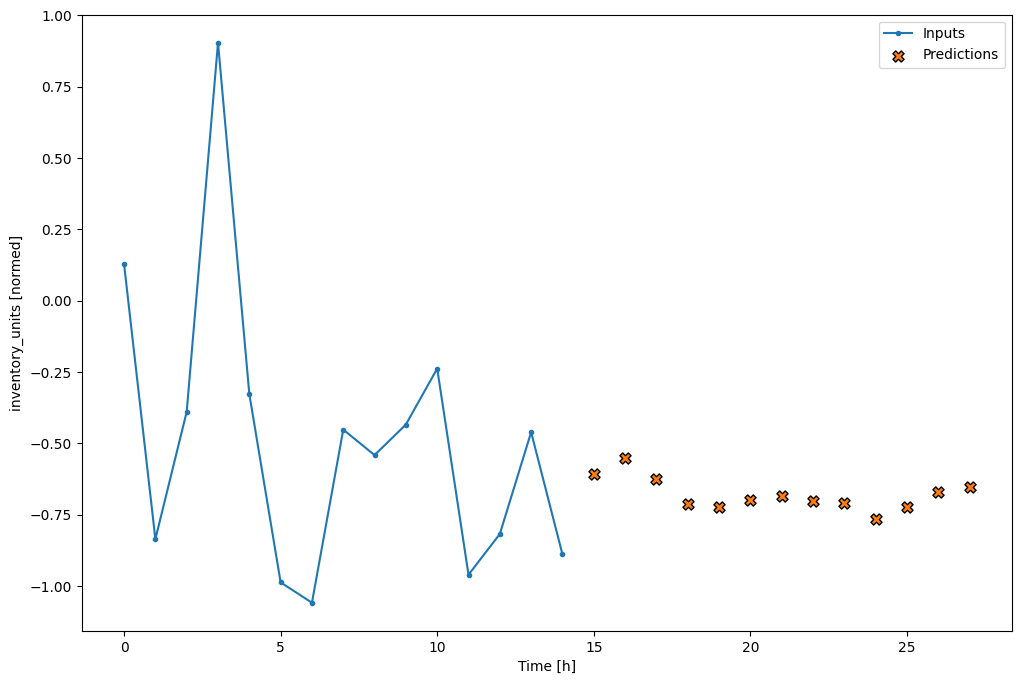

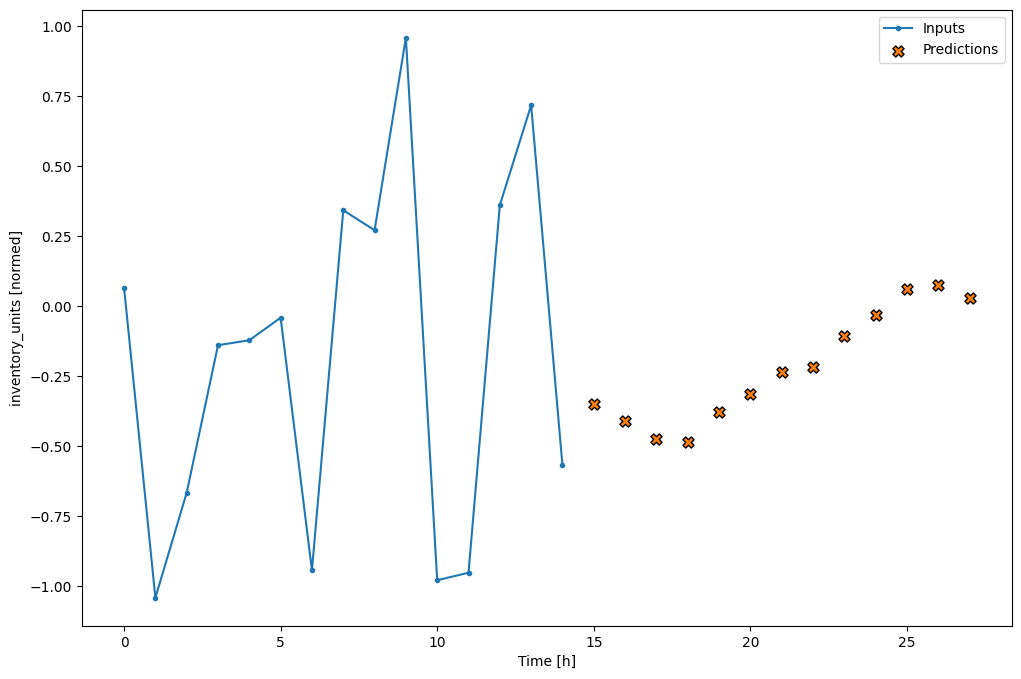

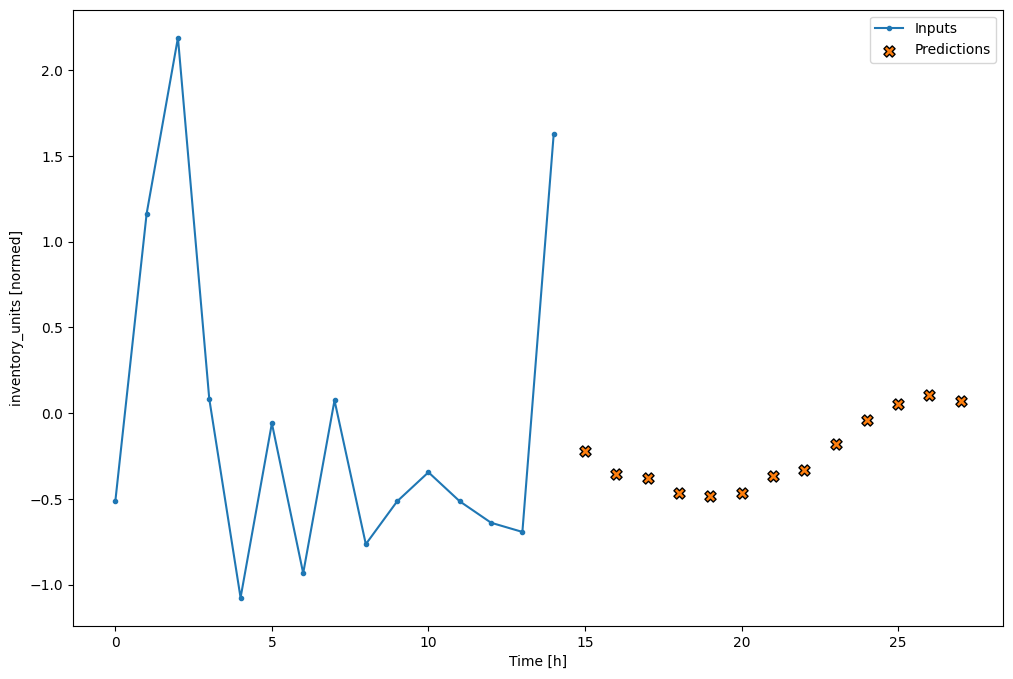

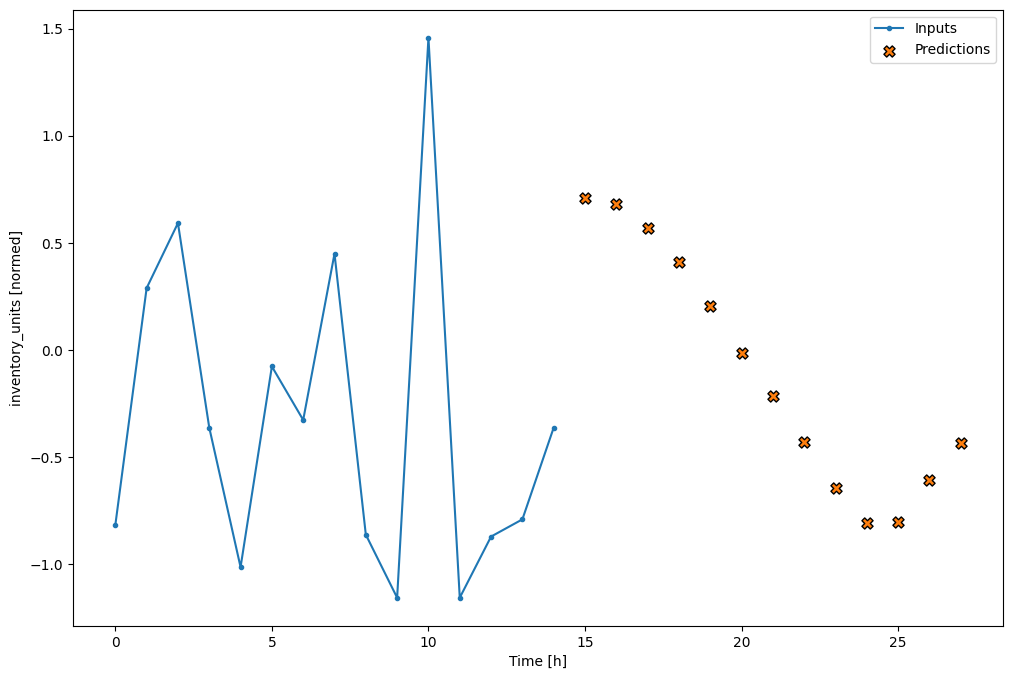

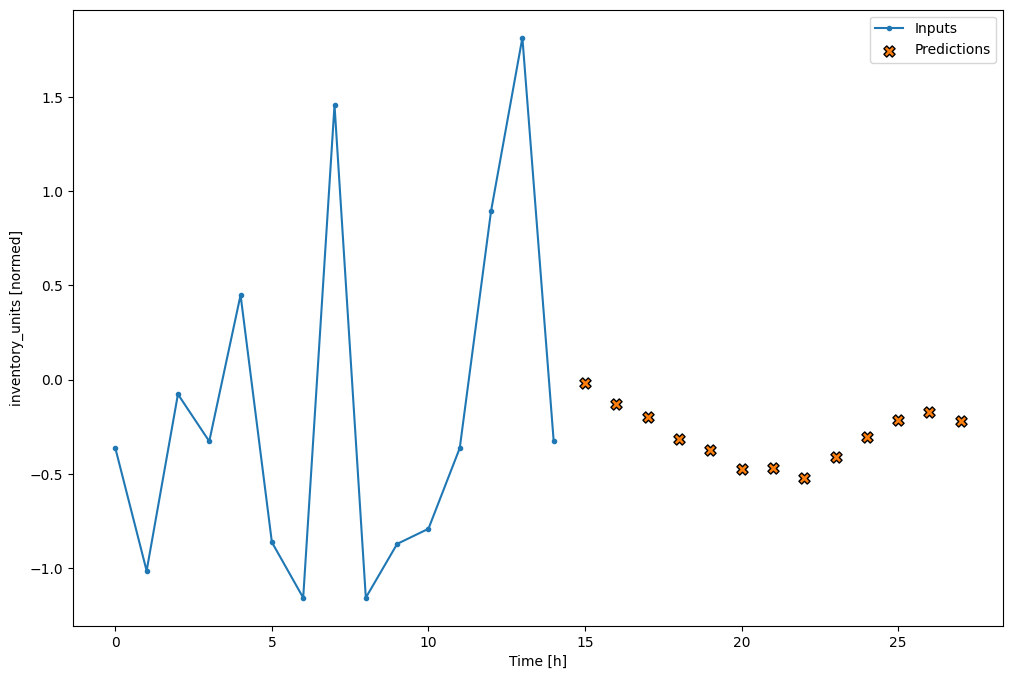

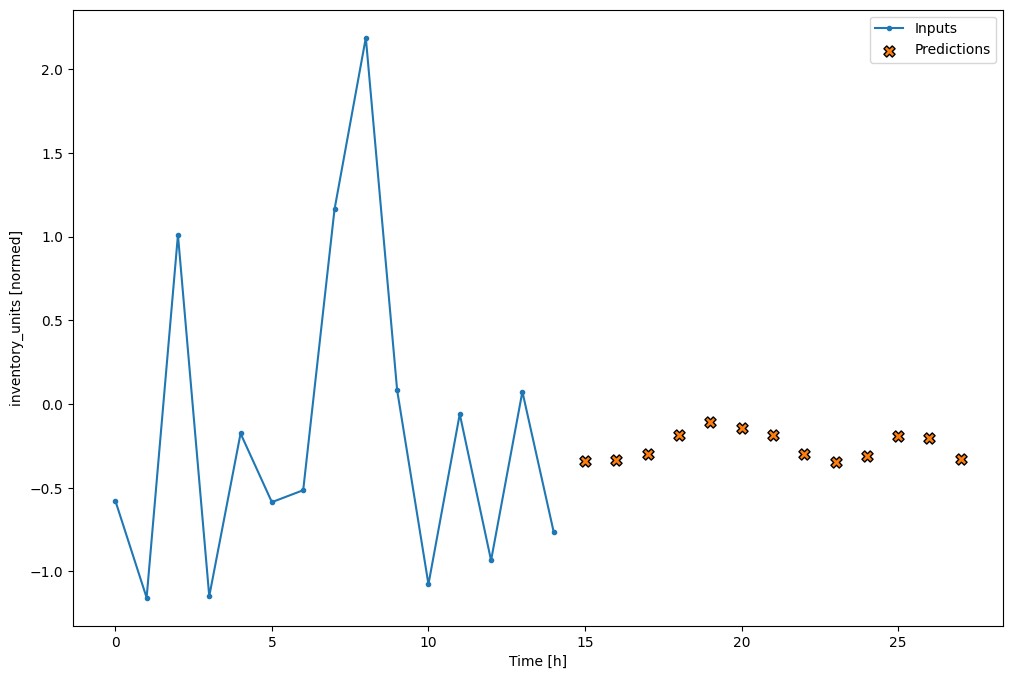

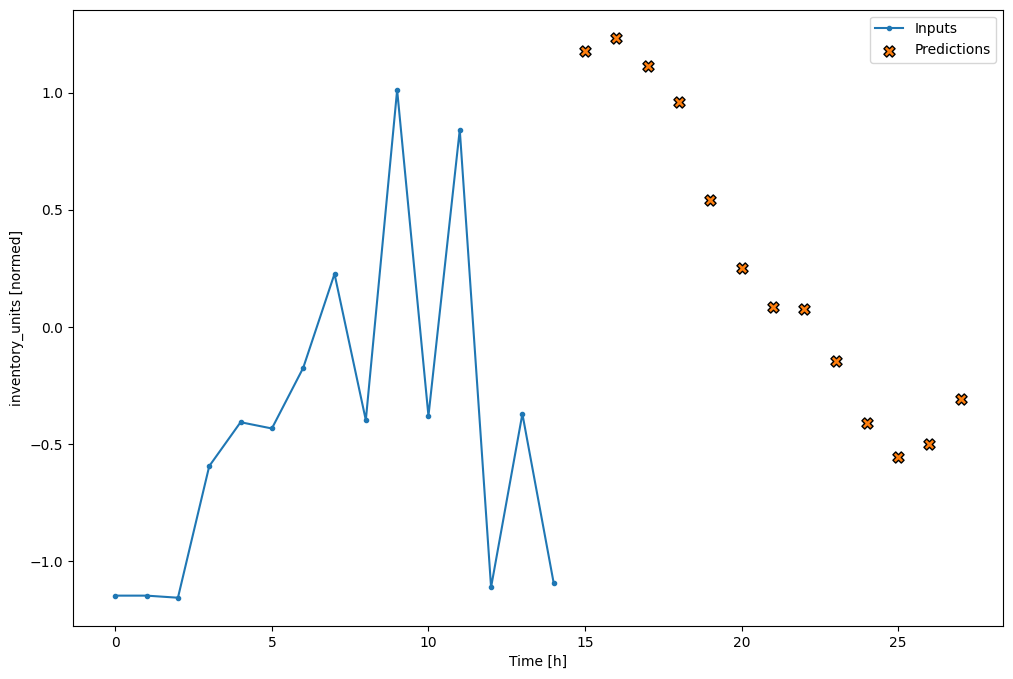

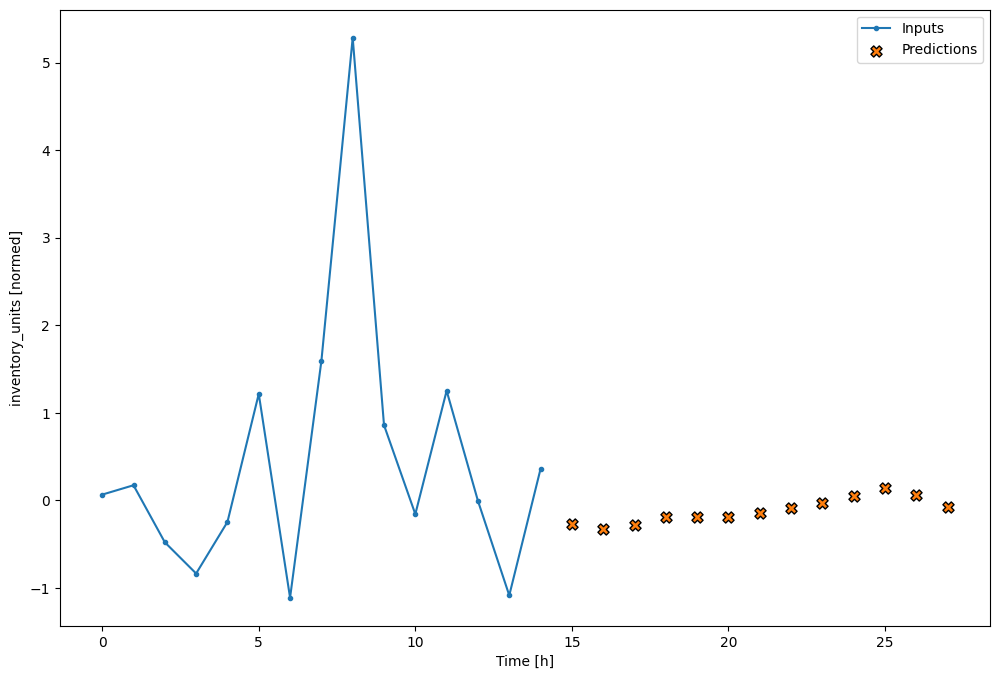

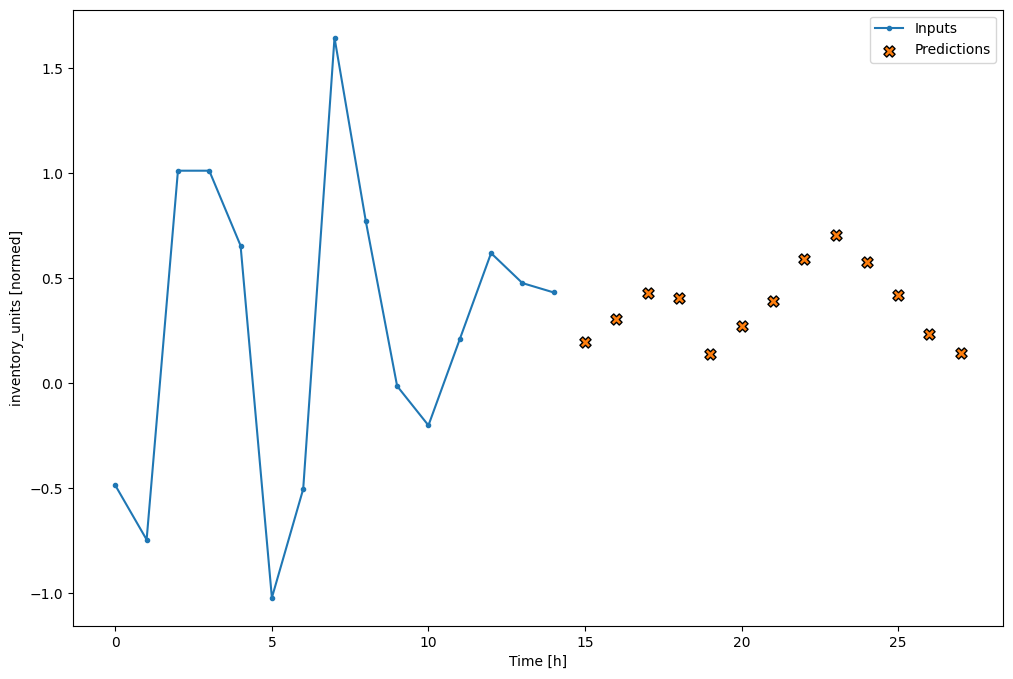

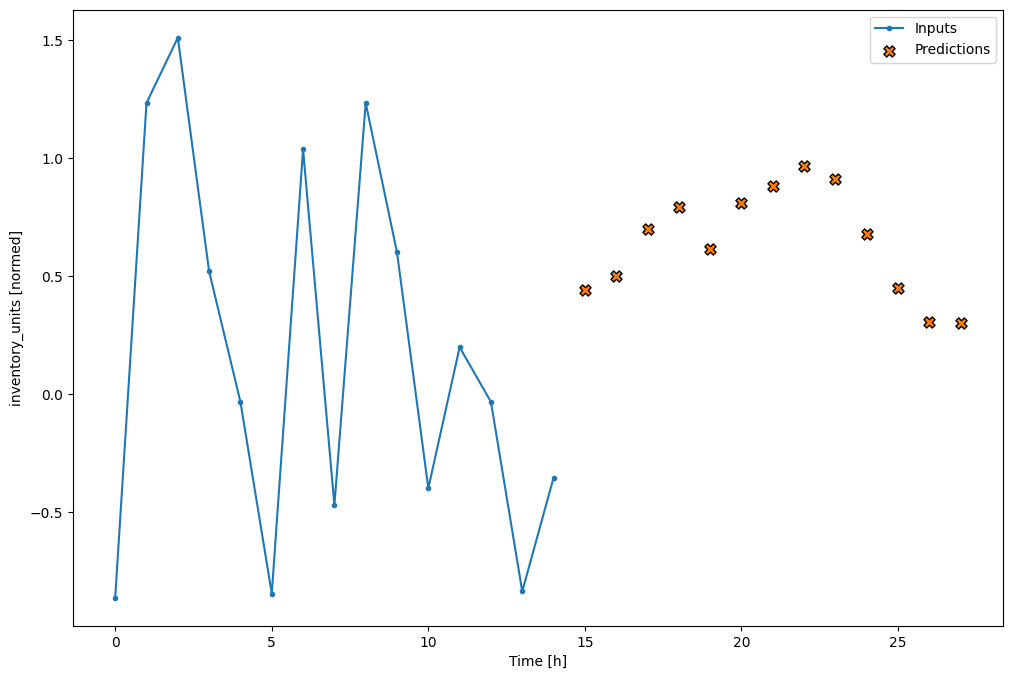

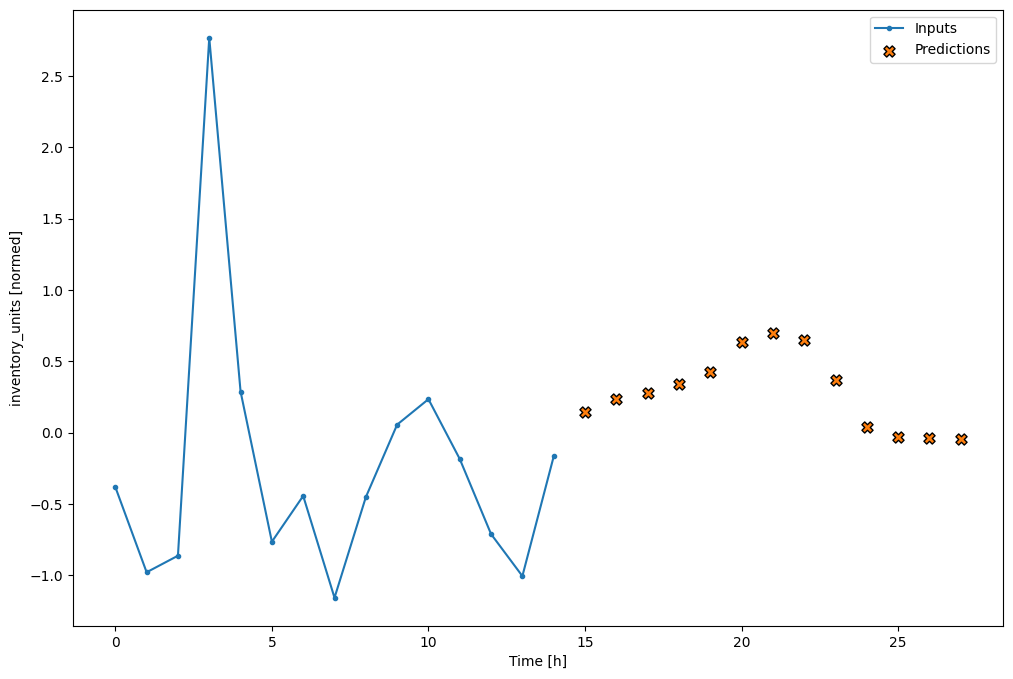

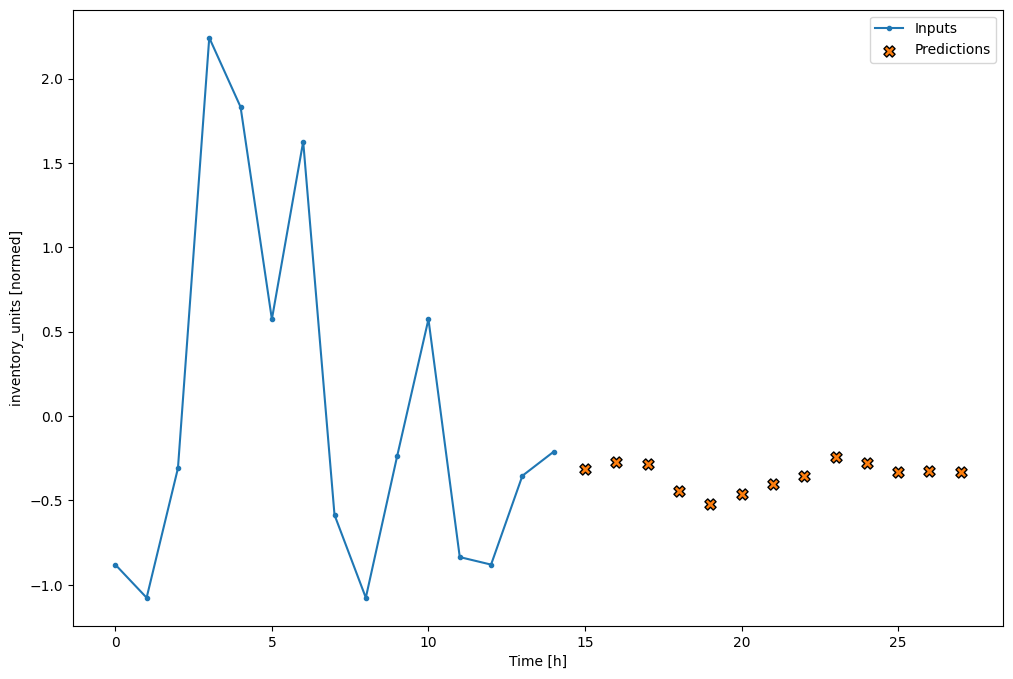

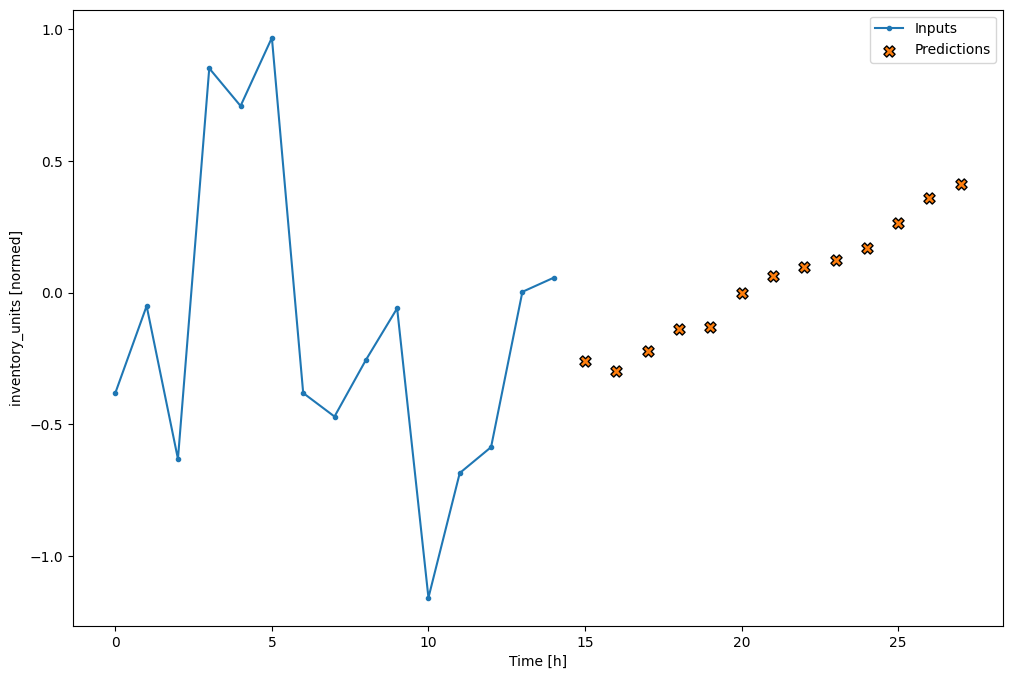

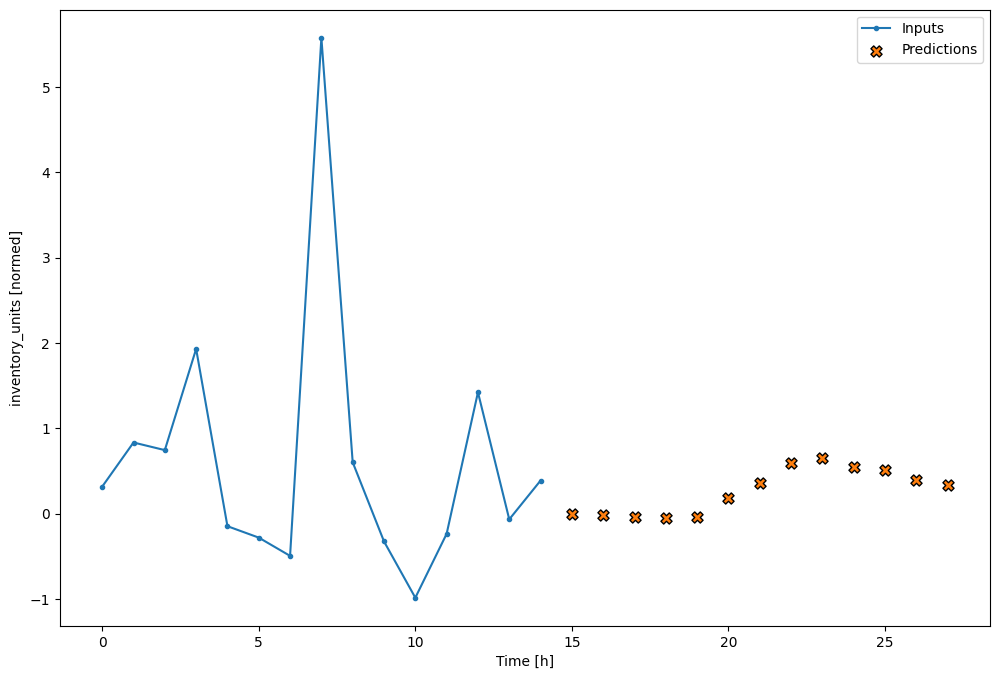

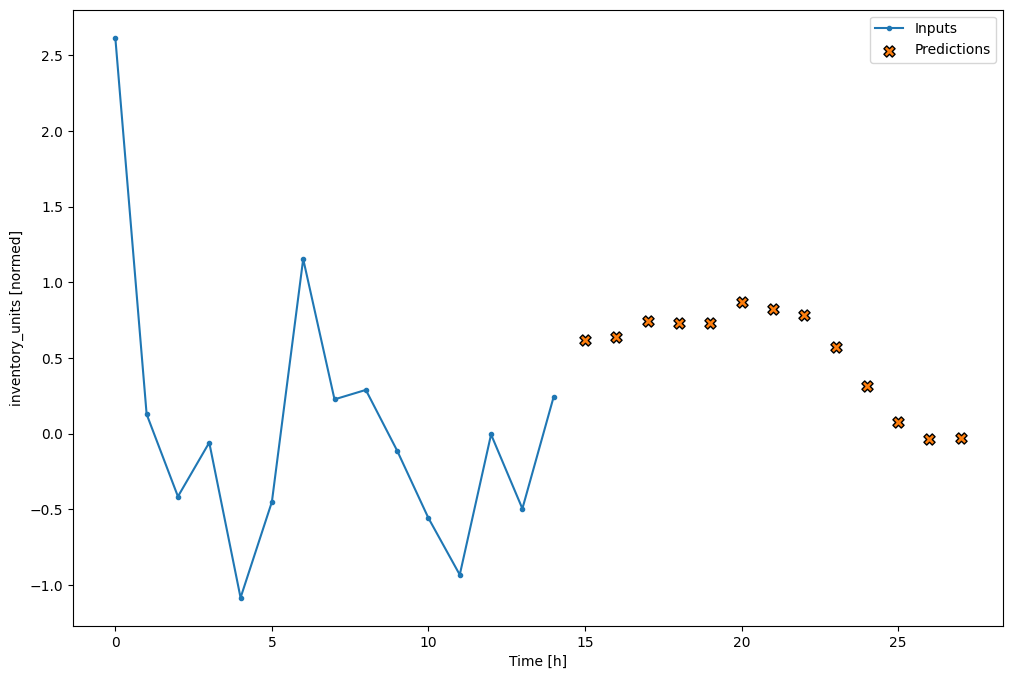

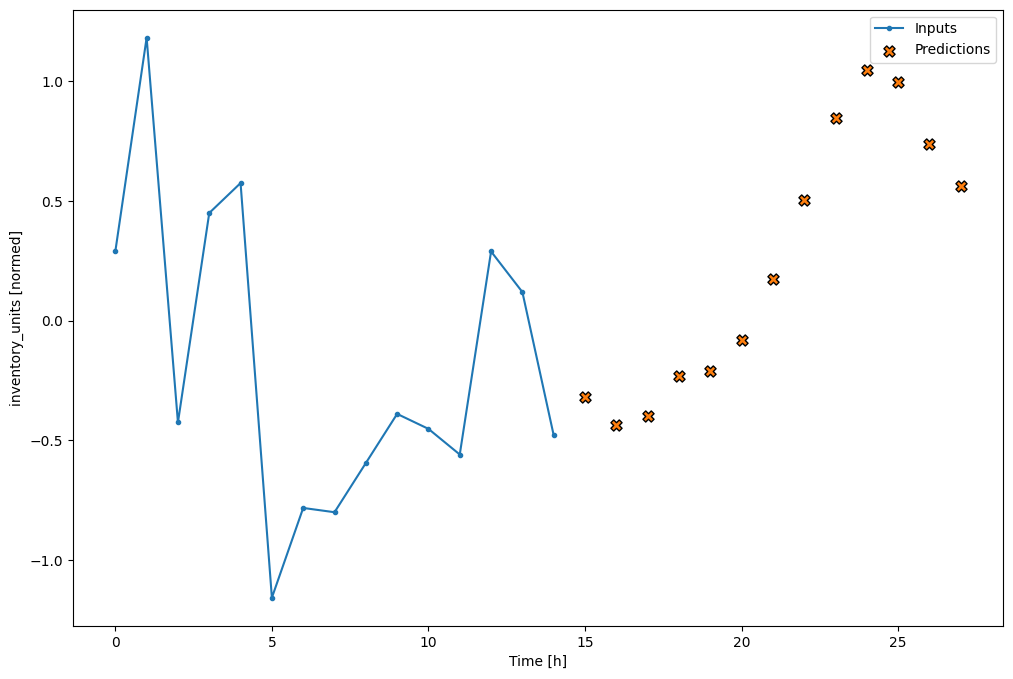

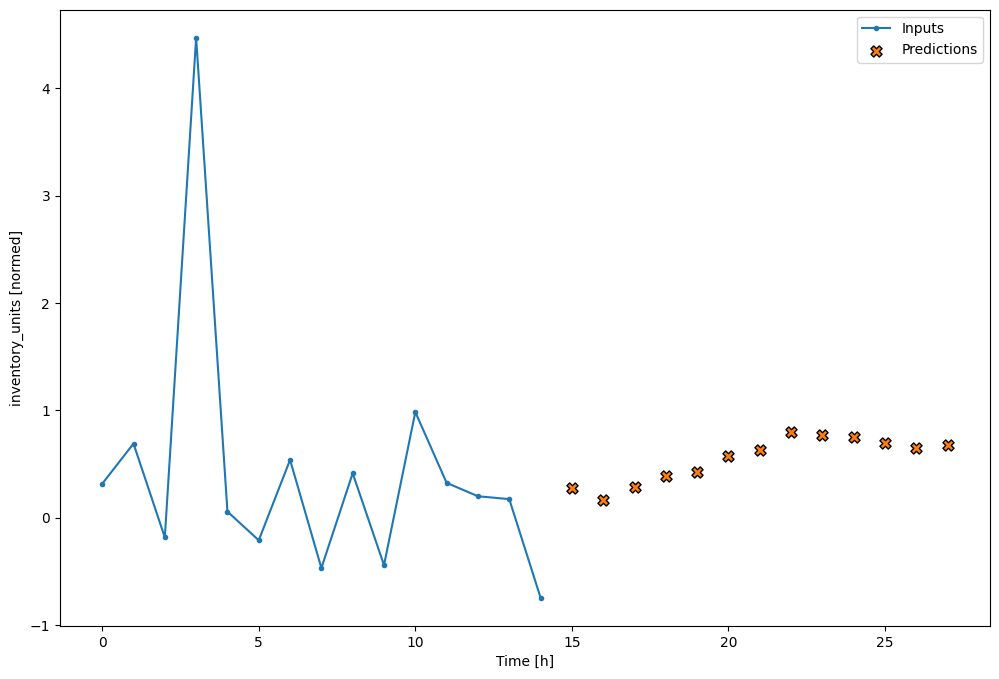

In [355]:
points = dict()
for object_number, test in test_df:
  multi_window = WindowGenerator(input_width=15,
                                label_width=13,
                                shift=13, train = X_train, val = X_val, test = test)

  points[object_number] = multi_window.plot(multi_lstm_model) * train_std.inventory_units + train_mean.inventory_units

In [356]:
points

{'product_number_6909': <tf.Tensor: shape=(13,), dtype=float32, numpy=
 array([139.83286 , 146.15506 , 149.65913 , 149.74062 , 139.65977 ,
        141.19621 , 144.04626 , 154.1187  , 146.42316 , 128.09445 ,
        113.980064, 106.19977 , 107.78424 ], dtype=float32)>,
 'product_number_7896': <tf.Tensor: shape=(13,), dtype=float32, numpy=
 array([ 51.10369 ,  45.876503,  58.953323,  75.61052 , 112.58284 ,
        134.85469 , 140.07631 , 138.15535 , 127.91    , 125.79141 ,
        132.55696 , 137.57855 , 134.95135 ], dtype=float32)>,
 'product_number_8883': <tf.Tensor: shape=(13,), dtype=float32, numpy=
 array([153.96336, 141.78488, 122.02519, 117.12803, 127.20633, 131.16191,
        135.81499, 148.98483, 156.38768, 172.56386, 196.92212, 212.15146,
        223.58047], dtype=float32)>,
 'product_number_9870': <tf.Tensor: shape=(13,), dtype=float32, numpy=
 array([166.883  , 159.33418, 136.8332 , 113.60009, 145.22244, 160.44061,
        164.24146, 157.23276, 167.3601 , 183.92212, 203.86336

In [365]:
base = 202319
results = {}
for pn, p in points.items():
  num = pn.split("_")[2]
  for i,point in enumerate(p):
    results[str(base+i) + "-" + num] = int(point)

In [367]:
len(results)

1300

In [389]:
df = pd.DataFrame([[pn, results[pn]] for pn in results.keys()], columns=['id', 'inventory_units'])
df.to_csv('results.csv', index=False)